Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with soft-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 2e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [113]:
scenario = 6
path = "."

In [114]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

acc_mv_train = np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train)
print("Accuracy of MV on train: ",acc_mv_train)

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.8196988196988197
Shape (data,annotators):  (2457, 10000)
Classes:  3


In [273]:
posib.append(acc_mv_train)
np.mean(posib)

0.6074296074296076

In [229]:
posib = []

In [10]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

In [228]:
aux2 = [0.25,0.35,0.40]
aux1 = GenerateData.conf_matrix.copy()

#### Delta Convergence criteria

In [37]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [38]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [7]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [115]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -39119.787317905095
2 	 -36133.18260144679 	0.4814	0.468054	0.076345
3 	 -35894.91149528612 	0.0543	0.153116	0.006594
4 	 -35885.187768222735 	0.0027	0.017775	0.000271
Class marginals
[0.36 0.34 0.3 ]


In [116]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.8196988196988197
ACC D&S on train: 0.9678469678469679


In [117]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV")

Trained model over soft-MV


In [118]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV")

Trained model over hard-MV


In [119]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S")

Trained model over D&S


In [120]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [11]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.65 sec)	logL: -18909.086	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -17467.008	Tol1: 0.07626	Tol2: 0.27414	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -17035.699	Tol1: 0.02469	Tol2: 0.10821	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16816.438	Tol1: 0.01287	Tol2: 0.05040	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16659.125	Tol1: 0.00935	Tol2: 0.01780	
Finished training!


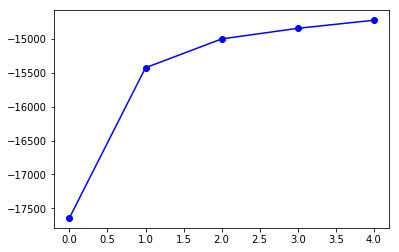

In [37]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

In [121]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 31.80 sec)	logL: -39167.758	
Iter 2/50 
M step: done,  E step: done //  (in 0.81 sec)	logL: -39144.039	Tol1: 0.00061	Tol2: 0.18667	
Iter 3/50 
M step: done,  E step: done //  (in 0.86 sec)	logL: -39131.973	Tol1: 0.00031	Tol2: 0.03931	
Iter 4/50 
M step: done,  E step: done //  (in 0.88 sec)	logL: -39128.281	Tol1: 0.00009	Tol2: 0.00582	
Finished training!
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 33.36 sec)	logL: -39166.961	
Iter 2/50 
M step: done,  E step: done //  (in 0.73 sec)	logL: -39136.246	Tol1: 0.00078	Tol2: 0.19022	
Iter 3/50 
M step: done,  E step: done //  (in 0.77 sec)	logL: -39125.258	Tol1: 0.00028	Tol2: 0.03390	
Iter 4/50 
M step: done,  E step: done //  (in 0.79 sec)	logL: -39121.730	Tol1: 0.00009	Tol2: 0.00484	
Finished tr

M step: done,  E step: done //  (in 0.70 sec)	logL: -39122.422	Tol1: 0.00009	Tol2: 0.00528	
Finished training!
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 32.86 sec)	logL: -39167.398	
Iter 2/50 
M step: done,  E step: done //  (in 0.68 sec)	logL: -39140.688	Tol1: 0.00068	Tol2: 0.18712	
Iter 3/50 
M step: done,  E step: done //  (in 0.81 sec)	logL: -39130.188	Tol1: 0.00027	Tol2: 0.03750	
Iter 4/50 
M step: done,  E step: done //  (in 0.76 sec)	logL: -39126.609	Tol1: 0.00009	Tol2: 0.00574	
Finished training!
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 33.50 sec)	logL: -39168.270	
Iter 2/50 
M step: done,  E step: done //  (in 0.67 sec)	logL: -39143.836	Tol1: 0.00062	Tol2: 0.18466	
Iter 3/50 
M step: done,  E step: done //  (in 0.71 sec)	logL: -39131.938	Tol1: 0.00030	Tol2: 0.03855	
Iter 4/50 
M step: done,  E step: done //  

### Our Proposed

In [122]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[10  3 24]
 [ 3 24 16]
 [11  0 25]
 ...
 [13  2 19]
 [33  1 12]
 [33  1 12]]
shape: (2457, 3)


In [123]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Bayesian gaussian mixture say is 20 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 6 clusters
Annotators PCA of annotations shape:  (10000, 4)
Normalized entropy (0-1) of repeats annotations: 0.6790690913572507
CPU times: user 7min 43s, sys: 29 s, total: 8min 12s
Wall time: 48 s


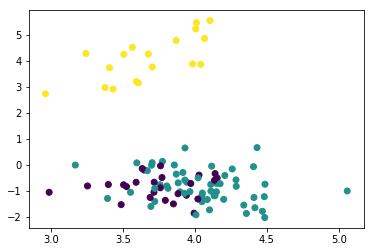

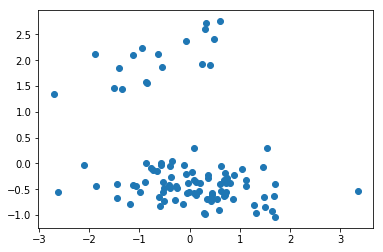

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [73]:
M_seted = 3

In [124]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.015181 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 32.72 sec)	logL: -103489.852	
Iter 2/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -100799.882	Tol1: 0.02599	Tol2: 0.18141	Tol3: 0.01464	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -100040.644	Tol1: 0.00753	Tol2: 0.04203	Tol3: 0.00285	
Iter 4/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -99376.861	Tol1: 0.00664	Tol2: 0.02850	Tol3: 0.00115	
Iter 5/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -98715.790	Tol1: 0.00665	Tol2: 0.02476	Tol3: 0.00110	
Iter 6/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -98011.030	Tol1: 0.00714	Tol2: 0.03125	Tol3: 0.00115	
Iter 7/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -97209.566	Tol1: 0

M step: done,  E step: done //  (in 0.28 sec)	logL: -84139.239	Tol1: 0.00258	Tol2: 0.04217	Tol3: 0.00049	
Iter 30/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -83937.349	Tol1: 0.00240	Tol2: 0.04007	Tol3: 0.00054	
Iter 31/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -83772.944	Tol1: 0.00196	Tol2: 0.03831	Tol3: 0.00053	
Iter 32/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -83621.521	Tol1: 0.00181	Tol2: 0.03749	Tol3: 0.00045	
Iter 33/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -83481.485	Tol1: 0.00167	Tol2: 0.04101	Tol3: 0.00049	
Iter 34/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -83360.352	Tol1: 0.00145	Tol2: 0.04559	Tol3: 0.00036	
Iter 35/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -83263.463	Tol1: 0.00116	Tol2: 0.05033	Tol3: 0.00035	
Iter 36/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -83183.885	Tol1: 0.00096	Tol2: 0.05274	Tol3: 0.00025	
Iter 37/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -83103.702	T

M step: done,  E step: done //  (in 0.39 sec)	logL: -85911.058	Tol1: 0.00987	Tol2: 0.12660	Tol3: 0.00049	
Iter 12/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -85203.013	Tol1: 0.00824	Tol2: 0.12479	Tol3: 0.00025	
Iter 13/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -84601.342	Tol1: 0.00706	Tol2: 0.11972	Tol3: 0.00013	
Iter 14/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -84102.470	Tol1: 0.00590	Tol2: 0.11183	Tol3: 0.00011	
Iter 15/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -83704.285	Tol1: 0.00473	Tol2: 0.10115	Tol3: 0.00016	
Iter 16/50
M step: done,  E step: done //  (in 0.43 sec)	logL: -83363.803	Tol1: 0.00407	Tol2: 0.08928	Tol3: 0.00024	
Iter 17/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -83071.240	Tol1: 0.00351	Tol2: 0.07630	Tol3: 0.00032	
Iter 18/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -82811.481	Tol1: 0.00313	Tol2: 0.06372	Tol3: 0.00048	
Iter 19/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -82596.347	T

M step: done,  E step: done //  (in 0.25 sec)	logL: -80662.854	Tol1: 0.00196	Tol2: 0.05346	Tol3: 0.00024	
Iter 30/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -80514.485	Tol1: 0.00184	Tol2: 0.05380	Tol3: 0.00027	
Iter 31/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -80375.526	Tol1: 0.00173	Tol2: 0.05450	Tol3: 0.00032	
Iter 32/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -80244.564	Tol1: 0.00163	Tol2: 0.05411	Tol3: 0.00041	
Iter 33/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -80125.332	Tol1: 0.00149	Tol2: 0.05328	Tol3: 0.00029	
Iter 34/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -80016.328	Tol1: 0.00136	Tol2: 0.05216	Tol3: 0.00024	
Iter 35/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -79919.354	Tol1: 0.00121	Tol2: 0.05242	Tol3: 0.00033	
Iter 36/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79836.920	Tol1: 0.00103	Tol2: 0.05174	Tol3: 0.00026	
Iter 37/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79776.180	T

M step: done,  E step: done //  (in 32.64 sec)	logL: -99600.399	
Iter 2/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -96067.975	Tol1: 0.03547	Tol2: 0.20836	Tol3: 0.00675	
Iter 3/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -93893.051	Tol1: 0.02264	Tol2: 0.15310	Tol3: 0.00111	
Iter 4/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -92048.566	Tol1: 0.01964	Tol2: 0.13450	Tol3: 0.00059	
Iter 5/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -90317.686	Tol1: 0.01880	Tol2: 0.13288	Tol3: 0.00111	
Iter 6/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -88727.340	Tol1: 0.01761	Tol2: 0.13696	Tol3: 0.00150	
Iter 7/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -87309.390	Tol1: 0.01598	Tol2: 0.13963	Tol3: 0.00173	
Iter 8/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -86066.723	Tol1: 0.01423	Tol2: 0.13726	Tol3: 0.00188	
Iter 9/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -85004.709	Tol1: 0.01234	Tol2: 0.12754	Tol3: 0.00181	
Iter 10

M step: done,  E step: done //  (in 0.27 sec)	logL: -88746.471	Tol1: 0.00872	Tol2: 0.08701	Tol3: 0.00118	
Iter 14/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -87973.997	Tol1: 0.00870	Tol2: 0.08212	Tol3: 0.00108	
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -87213.837	Tol1: 0.00864	Tol2: 0.07478	Tol3: 0.00091	
Iter 16/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -86440.172	Tol1: 0.00887	Tol2: 0.06549	Tol3: 0.00061	
Iter 17/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -85671.765	Tol1: 0.00889	Tol2: 0.05743	Tol3: 0.00040	
Iter 18/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -84880.559	Tol1: 0.00924	Tol2: 0.05048	Tol3: 0.00023	
Iter 19/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -84109.148	Tol1: 0.00909	Tol2: 0.04534	Tol3: 0.00013	
Iter 20/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -83375.673	Tol1: 0.00872	Tol2: 0.04124	Tol3: 0.00034	
Iter 21/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -82727.319	T

M step: done,  E step: done //  (in 33.51 sec)	logL: -98306.846	
Iter 2/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -97354.134	Tol1: 0.00969	Tol2: 0.07181	Tol3: 0.00160	
Iter 3/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -96594.516	Tol1: 0.00780	Tol2: 0.05661	Tol3: 0.00051	
Iter 4/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -95727.705	Tol1: 0.00897	Tol2: 0.06629	Tol3: 0.00090	
Iter 5/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -94720.250	Tol1: 0.01052	Tol2: 0.07671	Tol3: 0.00102	
Iter 6/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -93624.471	Tol1: 0.01157	Tol2: 0.08750	Tol3: 0.00117	
Iter 7/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -92459.194	Tol1: 0.01245	Tol2: 0.09768	Tol3: 0.00122	
Iter 8/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -91266.247	Tol1: 0.01290	Tol2: 0.10651	Tol3: 0.00126	
Iter 9/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -90076.478	Tol1: 0.01304	Tol2: 0.11374	Tol3: 0.00129	
Iter 10

M step: done,  E step: done //  (in 0.33 sec)	logL: -79318.594	Tol1: 0.00011	Tol2: 0.03177	Tol3: 0.00046	
Iter 35/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -79304.432	Tol1: 0.00018	Tol2: 0.03228	Tol3: 0.00049	
Iter 36/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79288.188	Tol1: 0.00020	Tol2: 0.03119	Tol3: 0.00035	
Iter 37/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79269.759	Tol1: 0.00023	Tol2: 0.03052	Tol3: 0.00017	
Iter 38/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79277.428	Tol1: 0.00010	Tol2: 0.03131	Tol3: 0.00028	
Iter 39/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -79273.576	Tol1: 0.00005	Tol2: 0.03201	Tol3: 0.00028	
Iter 40/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -79268.632	Tol1: 0.00006	Tol2: 0.03250	Tol3: 0.00034	
Iter 41/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79259.748	Tol1: 0.00011	Tol2: 0.03053	Tol3: 0.00017	
Iter 42/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -79256.913	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -79743.241	Tol1: 0.00120	Tol2: 0.03503	Tol3: 0.00017	
Iter 31/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79664.244	Tol1: 0.00099	Tol2: 0.03272	Tol3: 0.00018	
Iter 32/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -79610.393	Tol1: 0.00068	Tol2: 0.03031	Tol3: 0.00020	
Iter 33/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -79550.376	Tol1: 0.00075	Tol2: 0.02902	Tol3: 0.00007	
Iter 34/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -79510.418	Tol1: 0.00050	Tol2: 0.02791	Tol3: 0.00015	
Iter 35/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79473.466	Tol1: 0.00046	Tol2: 0.02645	Tol3: 0.00010	
Iter 36/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79435.552	Tol1: 0.00048	Tol2: 0.02564	Tol3: 0.00006	
Iter 37/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79420.073	Tol1: 0.00019	Tol2: 0.02546	Tol3: 0.00009	
Iter 38/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79399.025	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -82189.146	Tol1: 0.00727	Tol2: 0.06727	Tol3: 0.00095	
Iter 16/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -81681.513	Tol1: 0.00618	Tol2: 0.06445	Tol3: 0.00090	
Iter 17/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -81277.389	Tol1: 0.00495	Tol2: 0.06006	Tol3: 0.00076	
Iter 18/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -80940.284	Tol1: 0.00415	Tol2: 0.05640	Tol3: 0.00064	
Iter 19/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -80673.599	Tol1: 0.00329	Tol2: 0.05536	Tol3: 0.00071	
Iter 20/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -80449.265	Tol1: 0.00278	Tol2: 0.04901	Tol3: 0.00057	
Iter 21/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -80275.105	Tol1: 0.00216	Tol2: 0.04603	Tol3: 0.00054	
Iter 22/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -80125.845	Tol1: 0.00186	Tol2: 0.04466	Tol3: 0.00061	
Iter 23/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -80001.149	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -79832.638	Tol1: 0.00061	Tol2: 0.03447	Tol3: 0.00020	
Iter 34/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79793.554	Tol1: 0.00049	Tol2: 0.03197	Tol3: 0.00019	
Iter 35/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -79753.256	Tol1: 0.00051	Tol2: 0.03029	Tol3: 0.00017	
Iter 36/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -79723.841	Tol1: 0.00037	Tol2: 0.03090	Tol3: 0.00028	
Iter 37/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79695.754	Tol1: 0.00035	Tol2: 0.02887	Tol3: 0.00021	
Iter 38/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79665.091	Tol1: 0.00038	Tol2: 0.02999	Tol3: 0.00025	
Iter 39/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79645.549	Tol1: 0.00025	Tol2: 0.02754	Tol3: 0.00014	
Iter 40/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79627.645	Tol1: 0.00022	Tol2: 0.02783	Tol3: 0.00008	
Iter 41/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -79596.891	T

M step: done,  E step: done //  (in 0.27 sec)	logL: -82167.609	Tol1: 0.00682	Tol2: 0.11491	Tol3: 0.00028	
Iter 17/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -81688.209	Tol1: 0.00583	Tol2: 0.10386	Tol3: 0.00011	
Iter 18/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -81291.867	Tol1: 0.00485	Tol2: 0.09384	Tol3: 0.00008	
Iter 19/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -80982.545	Tol1: 0.00381	Tol2: 0.08888	Tol3: 0.00012	
Iter 20/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -80714.882	Tol1: 0.00331	Tol2: 0.08693	Tol3: 0.00012	
Iter 21/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -80463.001	Tol1: 0.00312	Tol2: 0.08346	Tol3: 0.00010	
Iter 22/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -80274.807	Tol1: 0.00234	Tol2: 0.07739	Tol3: 0.00007	
Iter 23/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -80097.374	Tol1: 0.00221	Tol2: 0.07206	Tol3: 0.00011	
Iter 24/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -79980.621	T

M step: done,  E step: done //  (in 0.27 sec)	logL: -79019.701	Tol1: 0.00027	Tol2: 0.02154	Tol3: 0.00011	
Iter 45/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -78999.112	Tol1: 0.00026	Tol2: 0.02128	Tol3: 0.00018	
Iter 46/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -78967.540	Tol1: 0.00040	Tol2: 0.02034	Tol3: 0.00009	
Iter 47/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -78948.503	Tol1: 0.00024	Tol2: 0.01852	Tol3: 0.00006	
Finished training!


In [125]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.015314 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.   0.07 0.55]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 35.47 sec)	logL: -111115.166	
Iter 2/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -106752.142	Tol1: 0.03927	Tol2: 0.35514	Tol3: 0.01921	
Iter 3/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -103759.669	Tol1: 0.02803	Tol2: 0.20689	Tol3: 0.02094	
Iter 4/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -101556.903	Tol1: 0.02123	Tol2: 0.12993	Tol3: 0.01597	
Iter 5/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -99743.905	Tol1: 0.01785	Tol2: 0.08835	Tol3: 0.00984	
Iter 6/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -98162.823	Tol1: 0.01585	Tol2: 0.06408	Tol3: 0.00469	
Iter 7/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -96670.036	

M step: done,  E step: done //  (in 0.26 sec)	logL: -80055.900	Tol1: 0.00163	Tol2: 0.03155	Tol3: 0.00132	
Iter 37/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79938.771	Tol1: 0.00146	Tol2: 0.03177	Tol3: 0.00131	
Iter 38/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79829.390	Tol1: 0.00137	Tol2: 0.03278	Tol3: 0.00126	
Iter 39/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79726.656	Tol1: 0.00129	Tol2: 0.03313	Tol3: 0.00123	
Iter 40/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79617.271	Tol1: 0.00137	Tol2: 0.03256	Tol3: 0.00128	
Iter 41/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -79524.116	Tol1: 0.00117	Tol2: 0.03368	Tol3: 0.00124	
Iter 42/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -79446.499	Tol1: 0.00098	Tol2: 0.03428	Tol3: 0.00116	
Iter 43/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -79400.206	Tol1: 0.00058	Tol2: 0.03383	Tol3: 0.00109	
Iter 44/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -79345.342	T

M step: done,  E step: done //  (in 0.37 sec)	logL: -100447.231	Tol1: 0.01611	Tol2: 0.09950	Tol3: 0.01044	
Iter 4/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -99152.406	Tol1: 0.01289	Tol2: 0.06898	Tol3: 0.00694	
Iter 5/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -98038.448	Tol1: 0.01123	Tol2: 0.05961	Tol3: 0.00440	
Iter 6/50
M step: done,  E step: done //  (in 0.50 sec)	logL: -96985.599	Tol1: 0.01074	Tol2: 0.06410	Tol3: 0.00249	
Iter 7/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -95957.956	Tol1: 0.01060	Tol2: 0.06981	Tol3: 0.00084	
Iter 8/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -94945.943	Tol1: 0.01055	Tol2: 0.07464	Tol3: 0.00111	
Iter 9/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -93911.237	Tol1: 0.01090	Tol2: 0.07846	Tol3: 0.00236	
Iter 10/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -92853.229	Tol1: 0.01127	Tol2: 0.08222	Tol3: 0.00356	
Iter 11/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -91830.399	Tol1: 

M step: done,  E step: done //  (in 0.33 sec)	logL: -79536.562	Tol1: 0.00027	Tol2: 0.03097	Tol3: 0.00080	
Iter 35/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -79536.529	Tol1: 0.00000	Tol2: 0.03124	Tol3: 0.00089	
Iter 36/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -79506.927	Tol1: 0.00037	Tol2: 0.03467	Tol3: 0.00104	
Iter 37/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -79485.347	Tol1: 0.00027	Tol2: 0.03211	Tol3: 0.00079	
Iter 38/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79449.626	Tol1: 0.00045	Tol2: 0.03320	Tol3: 0.00086	
Iter 39/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79433.100	Tol1: 0.00021	Tol2: 0.03456	Tol3: 0.00079	
Iter 40/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -79412.234	Tol1: 0.00026	Tol2: 0.03933	Tol3: 0.00090	
Iter 41/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79404.820	Tol1: 0.00009	Tol2: 0.03812	Tol3: 0.00077	
Iter 42/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79390.044	T

M step: done,  E step: done //  (in 0.25 sec)	logL: -79353.483	Tol1: 0.00038	Tol2: 0.04688	Tol3: 0.00245	
Iter 29/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79318.898	Tol1: 0.00044	Tol2: 0.04533	Tol3: 0.00255	
Iter 30/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79287.021	Tol1: 0.00040	Tol2: 0.04225	Tol3: 0.00226	
Iter 31/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79270.544	Tol1: 0.00021	Tol2: 0.03801	Tol3: 0.00195	
Iter 32/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -79238.136	Tol1: 0.00041	Tol2: 0.03502	Tol3: 0.00196	
Iter 33/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -79204.189	Tol1: 0.00043	Tol2: 0.03508	Tol3: 0.00213	
Iter 34/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -79167.071	Tol1: 0.00047	Tol2: 0.03399	Tol3: 0.00205	
Iter 35/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -79135.122	Tol1: 0.00040	Tol2: 0.03363	Tol3: 0.00190	
Iter 36/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -79115.780	T

M step: done,  E step: done //  (in 0.25 sec)	logL: -94700.197	Tol1: 0.01258	Tol2: 0.07329	Tol3: 0.00787	
Iter 6/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -93332.405	Tol1: 0.01444	Tol2: 0.08627	Tol3: 0.00843	
Iter 7/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -91804.781	Tol1: 0.01637	Tol2: 0.09919	Tol3: 0.00850	
Iter 8/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -90119.683	Tol1: 0.01836	Tol2: 0.11127	Tol3: 0.00826	
Iter 9/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -88384.581	Tol1: 0.01925	Tol2: 0.12233	Tol3: 0.00785	
Iter 10/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -86822.304	Tol1: 0.01768	Tol2: 0.13078	Tol3: 0.00712	
Iter 11/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -85476.059	Tol1: 0.01551	Tol2: 0.13362	Tol3: 0.00618	
Iter 12/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -84386.521	Tol1: 0.01275	Tol2: 0.13075	Tol3: 0.00515	
Iter 13/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -83504.521	Tol1:

M step: done,  E step: done //  (in 0.33 sec)	logL: -79332.735	Tol1: 0.00029	Tol2: 0.02314	Tol3: 0.00014	
Iter 47/50
M step: done,  E step: done //  (in 0.39 sec)	logL: -79307.932	Tol1: 0.00031	Tol2: 0.02293	Tol3: 0.00019	
Iter 48/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -79289.588	Tol1: 0.00023	Tol2: 0.02276	Tol3: 0.00021	
Iter 49/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79261.674	Tol1: 0.00035	Tol2: 0.02040	Tol3: 0.00017	
Iter 50/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79244.803	Tol1: 0.00021	Tol2: 0.01825	Tol3: 0.00006	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.71 0.57 0.01]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 38.88 sec)	logL: -101337.855	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -97539.287	Tol1: 0.03748	Tol2: 0.24879	Tol3: 0.02709	
Iter 3/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.28 sec)	logL: -83144.314	Tol1: 0.00970	Tol2: 0.10542	Tol3: 0.00098	
Iter 14/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -82475.703	Tol1: 0.00804	Tol2: 0.09495	Tol3: 0.00060	
Iter 15/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -81921.603	Tol1: 0.00672	Tol2: 0.08257	Tol3: 0.00041	
Iter 16/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -81487.014	Tol1: 0.00530	Tol2: 0.06960	Tol3: 0.00040	
Iter 17/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -81132.483	Tol1: 0.00435	Tol2: 0.06139	Tol3: 0.00033	
Iter 18/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -80850.535	Tol1: 0.00348	Tol2: 0.05773	Tol3: 0.00008	
Iter 19/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -80628.661	Tol1: 0.00274	Tol2: 0.05383	Tol3: 0.00050	
Iter 20/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -80444.931	Tol1: 0.00228	Tol2: 0.04873	Tol3: 0.00103	
Iter 21/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -80290.098	T

M step: done,  E step: done //  (in 0.31 sec)	logL: -79443.676	Tol1: 0.00143	Tol2: 0.01906	Tol3: 0.00138	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.11 0.99 0.2 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 37.64 sec)	logL: -113540.048	
Iter 2/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -107067.173	Tol1: 0.05701	Tol2: 0.28219	Tol3: 0.08975	
Iter 3/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -104024.719	Tol1: 0.02842	Tol2: 0.17063	Tol3: 0.05996	
Iter 4/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -101674.808	Tol1: 0.02259	Tol2: 0.14232	Tol3: 0.04493	
Iter 5/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -99663.731	Tol1: 0.01978	Tol2: 0.11960	Tol3: 0.03775	
Iter 6/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -97857.116	Tol1: 0.01813	Tol2: 0.10261	Tol3: 0.03175	
Iter 7/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.31 sec)	logL: -80326.487	Tol1: 0.00076	Tol2: 0.03849	Tol3: 0.00236	
Iter 30/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -80258.125	Tol1: 0.00085	Tol2: 0.03585	Tol3: 0.00215	
Iter 31/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -80214.829	Tol1: 0.00054	Tol2: 0.03275	Tol3: 0.00193	
Iter 32/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -80165.585	Tol1: 0.00061	Tol2: 0.03357	Tol3: 0.00203	
Iter 33/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -80122.650	Tol1: 0.00054	Tol2: 0.03355	Tol3: 0.00191	
Iter 34/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -80089.888	Tol1: 0.00041	Tol2: 0.03420	Tol3: 0.00177	
Iter 35/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -80042.783	Tol1: 0.00059	Tol2: 0.03352	Tol3: 0.00175	
Iter 36/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -79994.578	Tol1: 0.00060	Tol2: 0.03432	Tol3: 0.00165	
Iter 37/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -79972.058	T

M step: done,  E step: done //  (in 0.27 sec)	logL: -79393.792	Tol1: 0.00029	Tol2: 0.01861	Tol3: 0.00125	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6  0.05 0.24]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 38.54 sec)	logL: -110317.653	
Iter 2/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -103330.932	Tol1: 0.06333	Tol2: 0.39040	Tol3: 0.03238	
Iter 3/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -99305.630	Tol1: 0.03896	Tol2: 0.19722	Tol3: 0.03043	
Iter 4/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -96772.875	Tol1: 0.02550	Tol2: 0.09797	Tol3: 0.01641	
Iter 5/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -94830.381	Tol1: 0.02007	Tol2: 0.05741	Tol3: 0.00677	
Iter 6/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -93157.913	Tol1: 0.01764	Tol2: 0.05650	Tol3: 0.00190	
Iter 7/50
M step: done,  E step: done //

M step: done,  E step: done //  (in 0.32 sec)	logL: -79858.460	Tol1: 0.00094	Tol2: 0.02549	Tol3: 0.00079	
Iter 33/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -79804.264	Tol1: 0.00068	Tol2: 0.02590	Tol3: 0.00074	
Iter 34/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -79768.189	Tol1: 0.00045	Tol2: 0.02643	Tol3: 0.00064	
Iter 35/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79741.714	Tol1: 0.00033	Tol2: 0.02519	Tol3: 0.00061	
Iter 36/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79696.735	Tol1: 0.00056	Tol2: 0.02599	Tol3: 0.00050	
Iter 37/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -79646.291	Tol1: 0.00063	Tol2: 0.02879	Tol3: 0.00035	
Iter 38/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79616.495	Tol1: 0.00037	Tol2: 0.03031	Tol3: 0.00035	
Iter 39/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -79599.839	Tol1: 0.00021	Tol2: 0.03091	Tol3: 0.00033	
Iter 40/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -79566.148	T

M step: done,  E step: done //  (in 0.28 sec)	logL: -93398.293	Tol1: 0.01326	Tol2: 0.08641	Tol3: 0.00986	
Iter 4/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -92223.086	Tol1: 0.01258	Tol2: 0.09138	Tol3: 0.00972	
Iter 5/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -91064.327	Tol1: 0.01256	Tol2: 0.09685	Tol3: 0.00855	
Iter 6/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -89892.935	Tol1: 0.01286	Tol2: 0.10156	Tol3: 0.00713	
Iter 7/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -88778.989	Tol1: 0.01239	Tol2: 0.10573	Tol3: 0.00570	
Iter 8/50
M step: done,  E step: done //  (in 0.42 sec)	logL: -87716.480	Tol1: 0.01197	Tol2: 0.10876	Tol3: 0.00441	
Iter 9/50
M step: done,  E step: done //  (in 0.39 sec)	logL: -86708.985	Tol1: 0.01149	Tol2: 0.11077	Tol3: 0.00323	
Iter 10/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -85816.077	Tol1: 0.01030	Tol2: 0.11235	Tol3: 0.00217	
Iter 11/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -84992.730	Tol1: 0

In [ ]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.779293 mins
Initializing new EM...
Pre-train network on 0 epochs...

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.74 0.73 0.82]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 41.83 sec)	logL: -107093.315	
Iter 2/50
M step: done,  E step: done //  (in 0.46 sec)	logL: -104483.153	Tol1: 0.02437	Tol2: 0.28652	Tol3: 0.00613	
Iter 3/50
M step: done,  E step: done //  (in 0.39 sec)	logL: -102850.188	Tol1: 0.01563	Tol2: 0.16631	Tol3: 0.00702	
Iter 4/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -101733.228	Tol1: 0.01086	Tol2: 0.12343	Tol3: 0.00825	
Iter 5/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -100966.696	Tol1: 0.00753	Tol2: 0.09783	Tol3: 0.00884	
Iter 6/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -100423.819	Tol1: 0.00538	Tol2: 0.08175	Tol3: 0.00910	
Iter 7/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -100002.354	Tol1: 0.00420	Tol2: 0.07133	Tol3: 0.00915	
Iter 8/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -99628.830	Tol1: 0.00374	Tol2: 0.0646

M step: done,  E step: done //  (in 0.33 sec)	logL: -85754.880	Tol1: 0.00590	Tol2: 0.04615	Tol3: 0.00193	
Iter 20/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -85266.858	Tol1: 0.00569	Tol2: 0.03915	Tol3: 0.00204	
Iter 21/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -84795.080	Tol1: 0.00553	Tol2: 0.03216	Tol3: 0.00211	
Iter 22/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -84339.545	Tol1: 0.00537	Tol2: 0.02687	Tol3: 0.00223	
Iter 23/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -83920.177	Tol1: 0.00497	Tol2: 0.02317	Tol3: 0.00229	
Iter 24/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -83527.097	Tol1: 0.00468	Tol2: 0.01944	Tol3: 0.00232	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32 0.13 0.81]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 41.13 sec)	logL: -99499.643	
Iter 2/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.33 sec)	logL: -89723.549	Tol1: 0.00585	Tol2: 0.05402	Tol3: 0.00928	
Iter 13/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -89157.199	Tol1: 0.00631	Tol2: 0.05684	Tol3: 0.00906	
Iter 14/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -88540.269	Tol1: 0.00692	Tol2: 0.05988	Tol3: 0.00898	
Iter 15/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -87857.651	Tol1: 0.00771	Tol2: 0.06257	Tol3: 0.00888	
Iter 16/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -87166.705	Tol1: 0.00786	Tol2: 0.06410	Tol3: 0.00913	
Iter 17/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -86465.265	Tol1: 0.00805	Tol2: 0.06357	Tol3: 0.00907	
Iter 18/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -85831.165	Tol1: 0.00733	Tol2: 0.06051	Tol3: 0.00795	
Iter 19/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -85298.659	Tol1: 0.00620	Tol2: 0.05766	Tol3: 0.00653	
Iter 20/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -84844.495	T

M step: done,  E step: done //  (in 0.31 sec)	logL: -80878.100	Tol1: 0.00093	Tol2: 0.02988	Tol3: 0.00158	
Iter 44/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -80769.640	Tol1: 0.00134	Tol2: 0.02886	Tol3: 0.00202	
Iter 45/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -80679.590	Tol1: 0.00111	Tol2: 0.02991	Tol3: 0.00124	
Iter 46/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -80585.910	Tol1: 0.00116	Tol2: 0.03022	Tol3: 0.00209	
Iter 47/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -80522.255	Tol1: 0.00079	Tol2: 0.03173	Tol3: 0.00200	
Iter 48/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -80451.539	Tol1: 0.00088	Tol2: 0.03195	Tol3: 0.00400	
Iter 49/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -80385.586	Tol1: 0.00082	Tol2: 0.03105	Tol3: 0.00315	
Iter 50/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -80307.279	Tol1: 0.00097	Tol2: 0.02906	Tol3: 0.00268	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

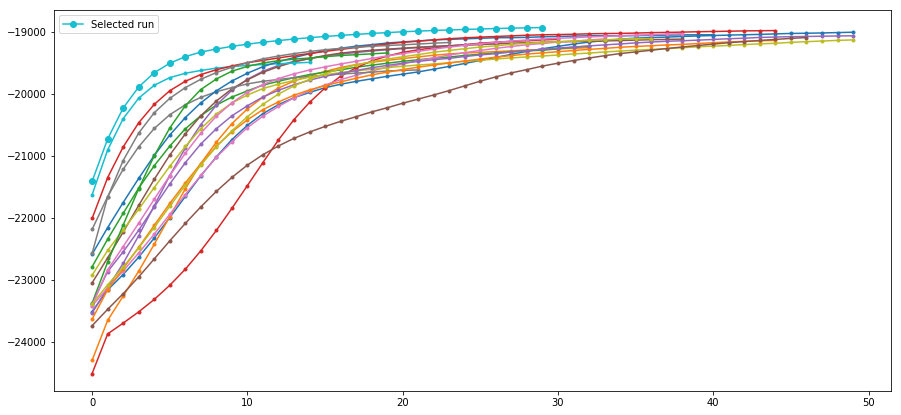

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

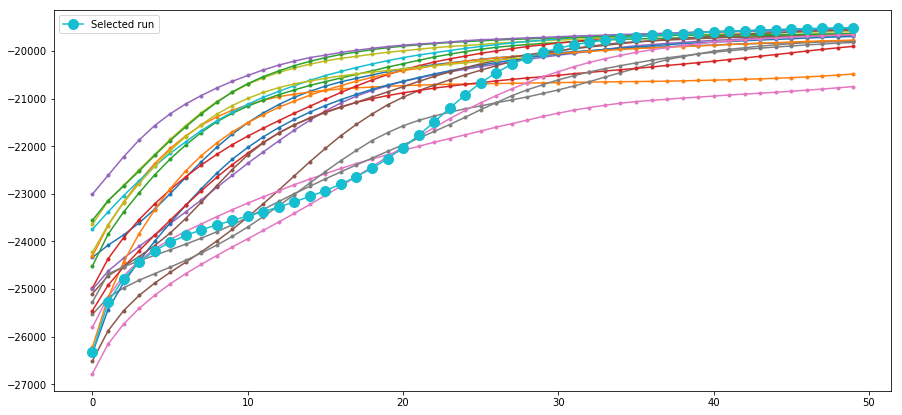

In [52]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [24]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [54]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
1568/2457 [==================>...........] - ETA: 0s  A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.923077      0.923077
====  ======  ==========  ============
Test
 32/819 [>.............................] - ETA: 0sA result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.941392      0.941392
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [25]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8074888074888075


*** Soft-Majority (Train with softMV) ***
Train


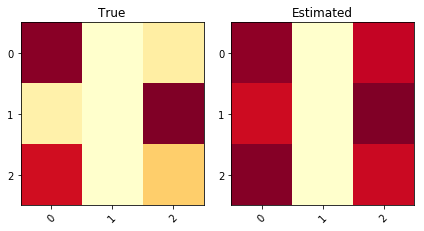

KL divergence: 0.2379	Pearson Correlation between diagonals: 0.8060


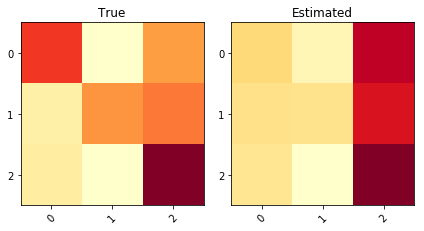

KL divergence: 0.2284	Pearson Correlation between diagonals: 0.9440


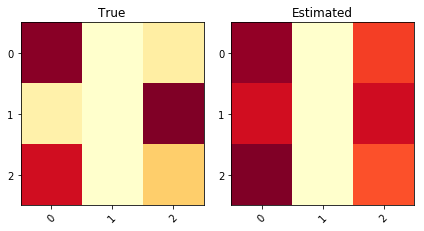

KL divergence: 0.2186	Pearson Correlation between diagonals: 0.9183


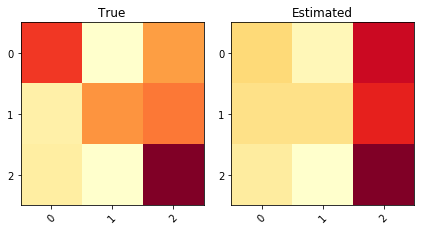

KL divergence: 0.2244	Pearson Correlation between diagonals: 0.9420


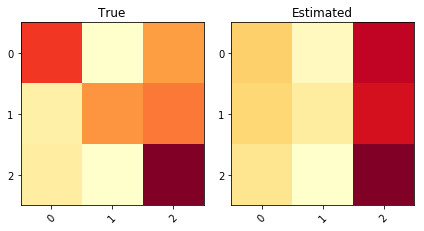

KL divergence: 0.2265	Pearson Correlation between diagonals: 0.9728


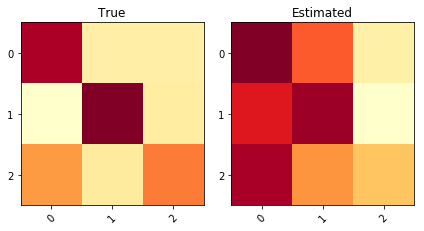

KL divergence: 0.3308	Pearson Correlation between diagonals: 0.9630


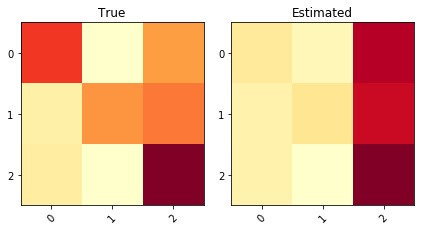

KL divergence: 0.2486	Pearson Correlation between diagonals: 0.9133


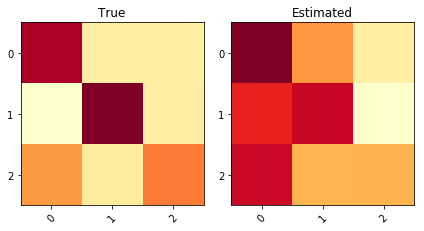

KL divergence: 0.3422	Pearson Correlation between diagonals: 0.9063


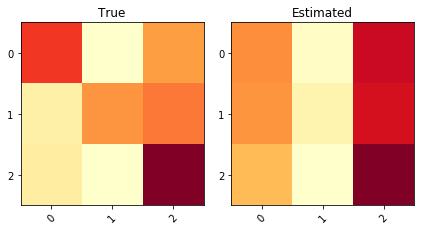

KL divergence: 0.2469	Pearson Correlation between diagonals: 0.9974


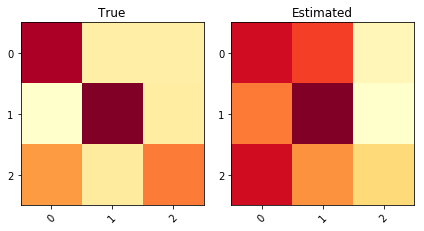

KL divergence: 0.3320	Pearson Correlation between diagonals: 0.9990


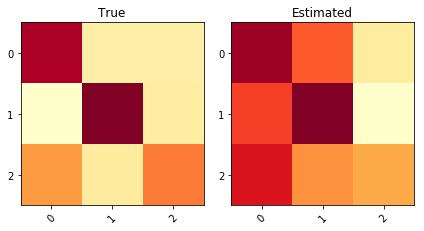

KL divergence: 0.3372	Pearson Correlation between diagonals: 0.9955


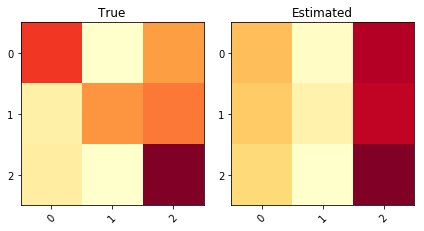

KL divergence: 0.2367	Pearson Correlation between diagonals: 0.9911


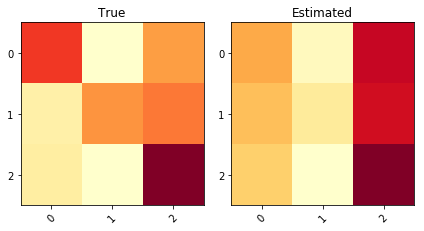

KL divergence: 0.2278	Pearson Correlation between diagonals: 0.9954


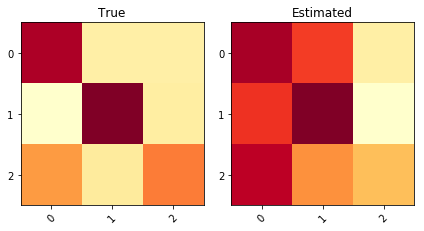

KL divergence: 0.3276	Pearson Correlation between diagonals: 0.9969


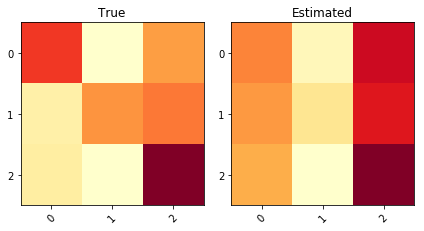

KL divergence: 0.2377	Pearson Correlation between diagonals: 0.9994
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.815222      0.815222   0.260335  0.0735123            0.959484
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.815629      0.815629
====  ======  ==========  ============


In [26]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


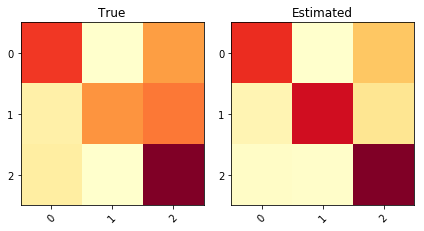

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7283


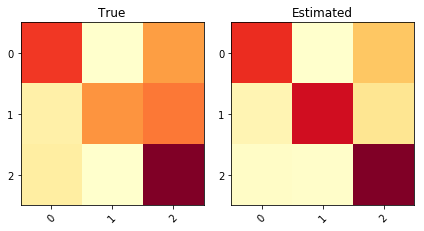

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7283


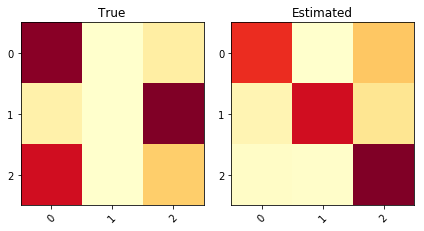

KL divergence: 0.5630	Pearson Correlation between diagonals: -0.5626


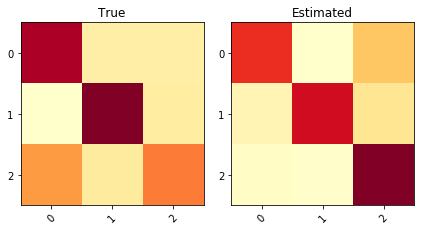

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.8513


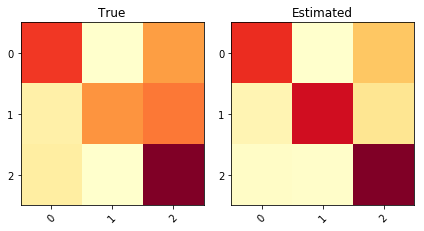

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7283


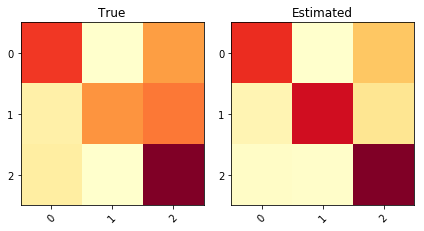

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7283


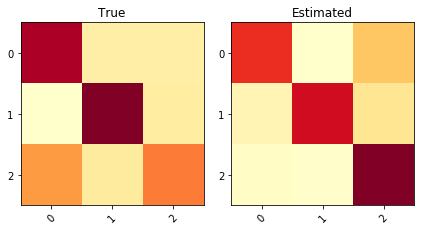

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.8513


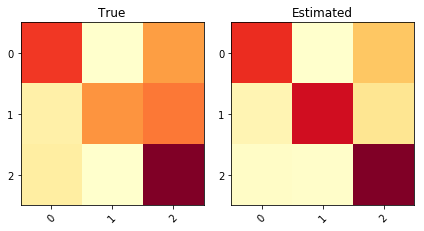

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7283


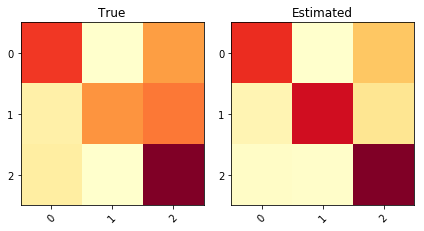

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.7283


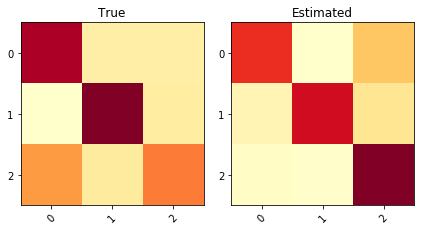

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.8513


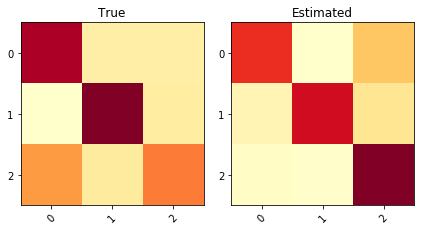

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.8513


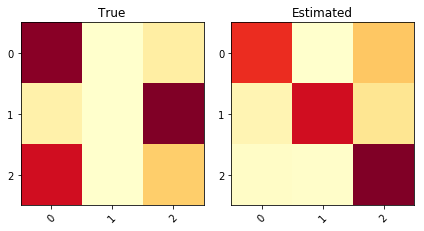

KL divergence: 0.5630	Pearson Correlation between diagonals: -0.5626


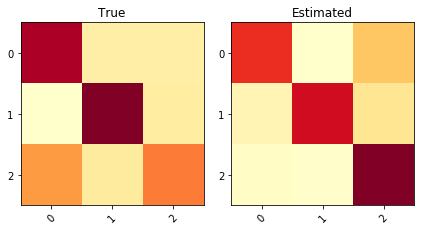

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.8513


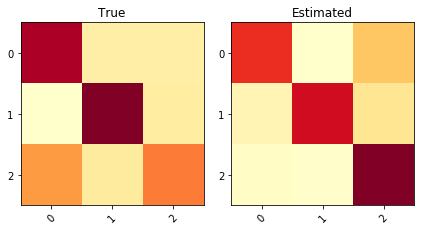

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.8513


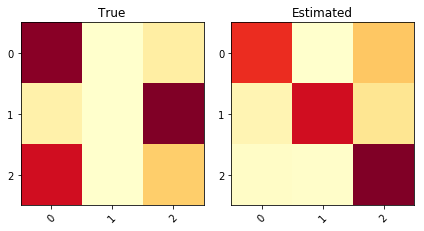

KL divergence: 0.5630	Pearson Correlation between diagonals: -0.5626
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.815222      0.815222   0.523387   0.132066          0.00336128
====  ======  ==========  ============  =========  =========  ==================


In [27]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


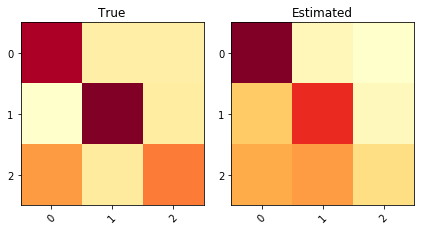

KL divergence: 0.2280	Pearson Correlation between diagonals: 0.8460


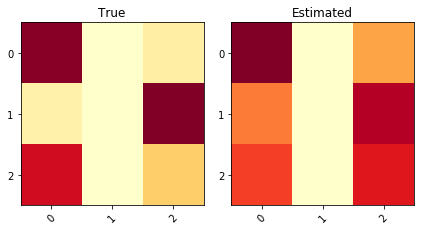

KL divergence: 0.1611	Pearson Correlation between diagonals: 0.8633


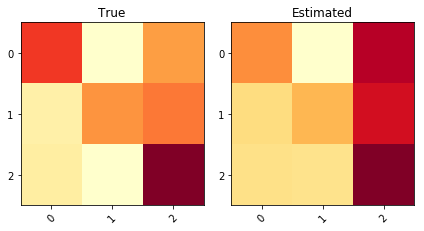

KL divergence: 0.1394	Pearson Correlation between diagonals: 0.9818


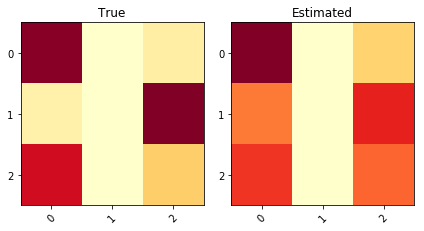

KL divergence: 0.1357	Pearson Correlation between diagonals: 0.9450


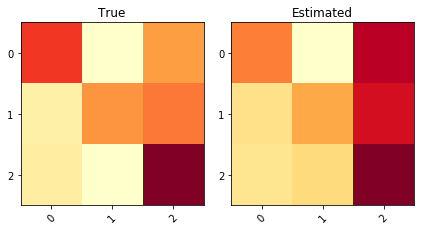

KL divergence: 0.1419	Pearson Correlation between diagonals: 0.9815


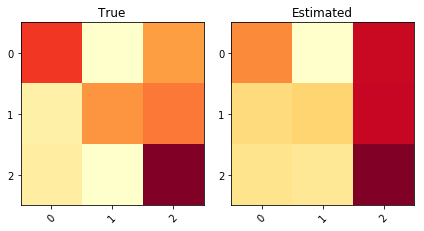

KL divergence: 0.1433	Pearson Correlation between diagonals: 0.9976


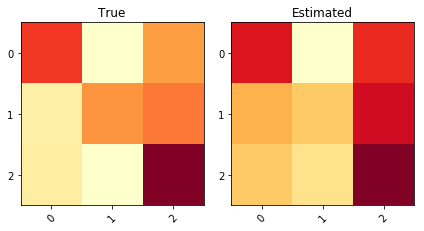

KL divergence: 0.1417	Pearson Correlation between diagonals: 0.9480


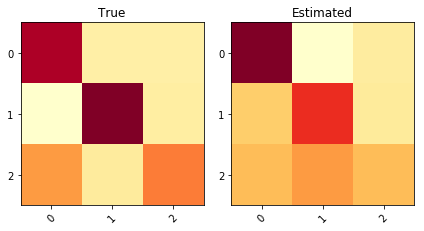

KL divergence: 0.2325	Pearson Correlation between diagonals: 0.7925


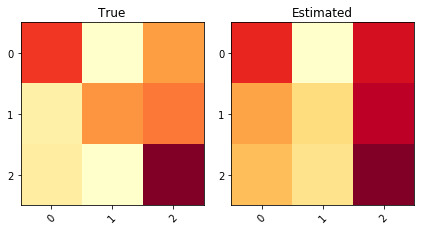

KL divergence: 0.1780	Pearson Correlation between diagonals: 0.9591


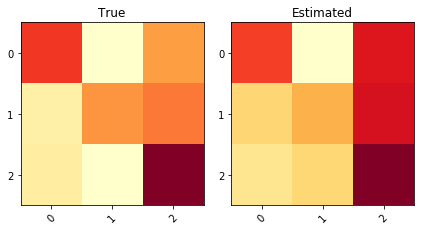

KL divergence: 0.1396	Pearson Correlation between diagonals: 0.9971


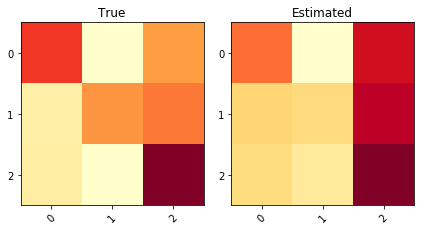

KL divergence: 0.1433	Pearson Correlation between diagonals: 0.9990


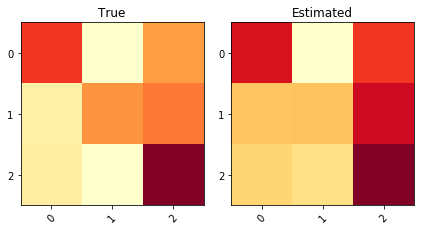

KL divergence: 0.1323	Pearson Correlation between diagonals: 0.9477


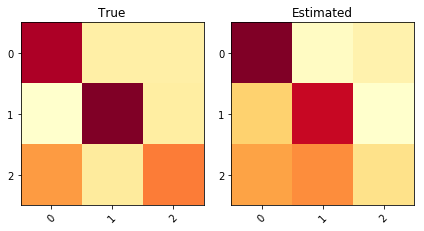

KL divergence: 0.2349	Pearson Correlation between diagonals: 0.9276


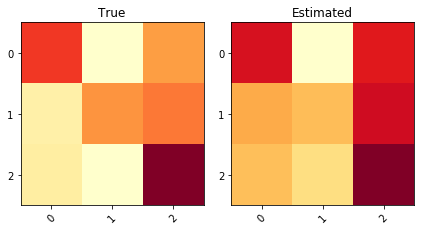

KL divergence: 0.1547	Pearson Correlation between diagonals: 0.9427


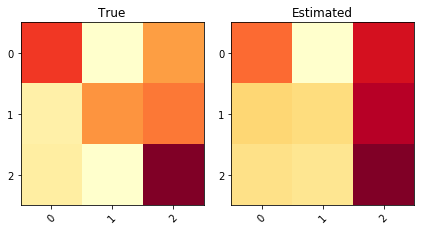

KL divergence: 0.1514	Pearson Correlation between diagonals: 0.9979
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.838828      0.838828   0.169213   0.049142            0.945117
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.825397      0.825397
====  ======  ==========  ============


In [28]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


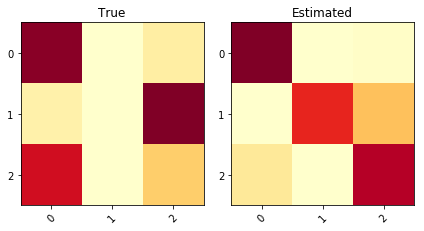

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9417


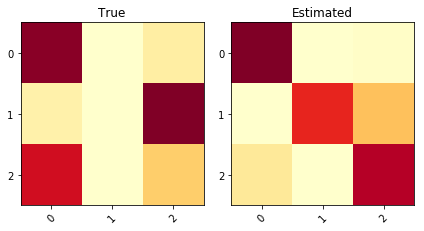

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9417


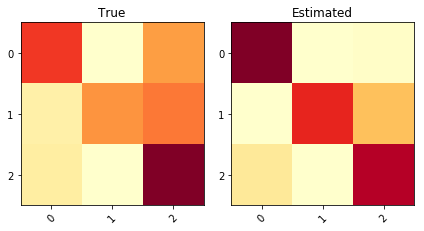

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


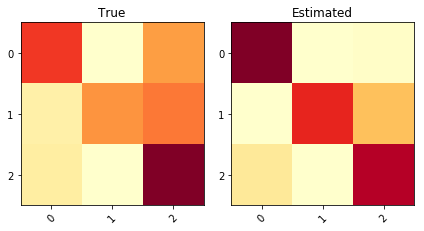

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


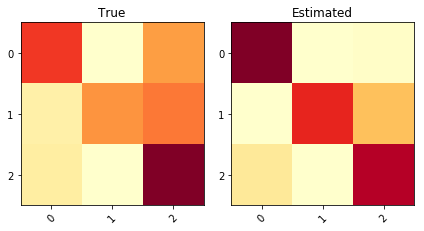

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


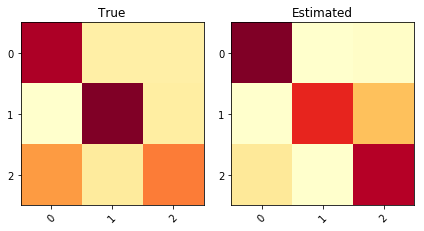

KL divergence: 0.4550	Pearson Correlation between diagonals: -0.2936


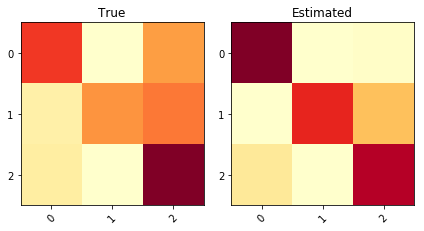

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


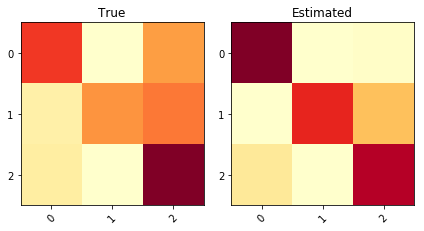

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


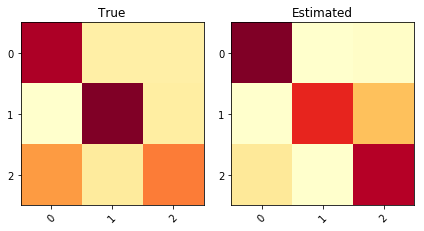

KL divergence: 0.4550	Pearson Correlation between diagonals: -0.2936


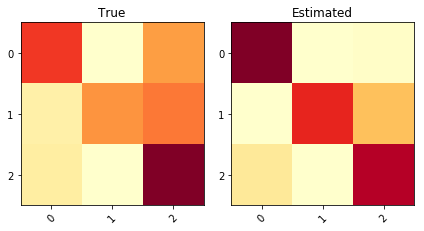

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


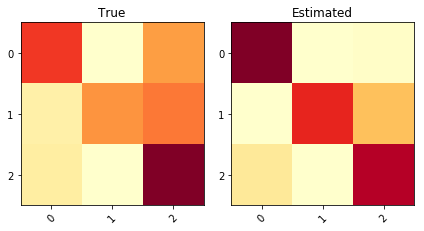

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


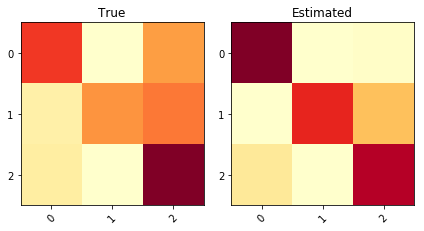

KL divergence: 0.4520	Pearson Correlation between diagonals: 0.4799


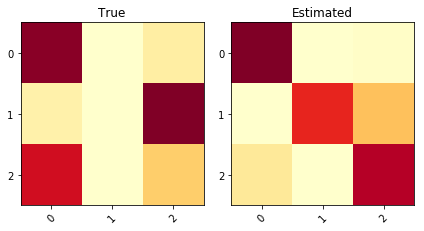

KL divergence: 0.6981	Pearson Correlation between diagonals: 0.9417


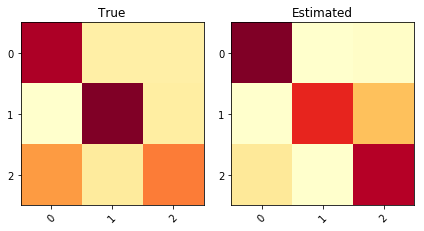

KL divergence: 0.4550	Pearson Correlation between diagonals: -0.2936


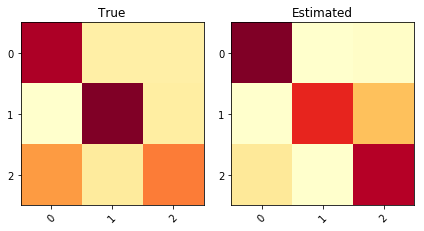

KL divergence: 0.4550	Pearson Correlation between diagonals: -0.2936
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.838828      0.838828   0.494799   0.167346            0.310915
====  ======  ==========  ============  =========  =========  ==================


In [29]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


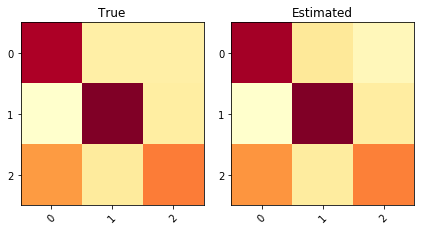

KL divergence: 0.0082	Pearson Correlation between diagonals: 0.9989


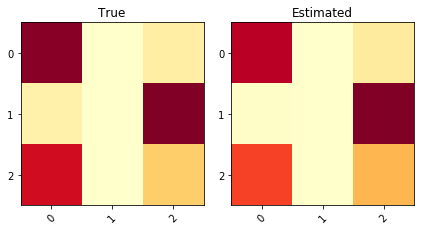

KL divergence: 0.0384	Pearson Correlation between diagonals: 0.9908


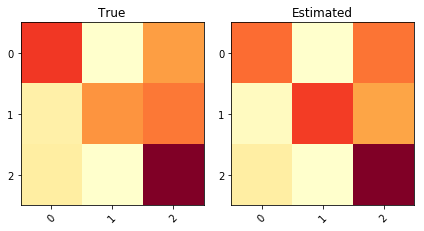

KL divergence: 0.0349	Pearson Correlation between diagonals: 0.8124


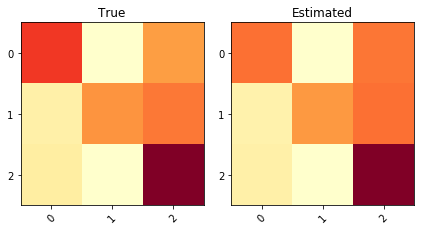

KL divergence: 0.0074	Pearson Correlation between diagonals: 0.9759


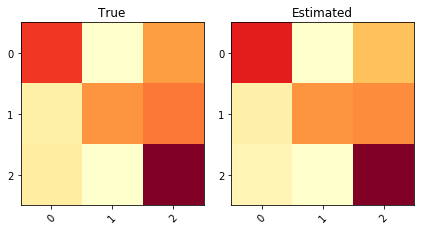

KL divergence: 0.0096	Pearson Correlation between diagonals: 0.9898


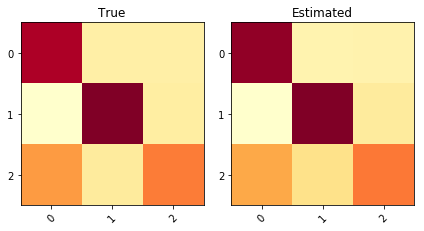

KL divergence: 0.0053	Pearson Correlation between diagonals: 0.9931


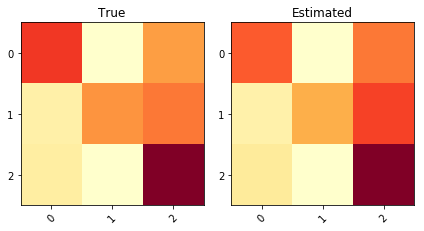

KL divergence: 0.0107	Pearson Correlation between diagonals: 0.9987


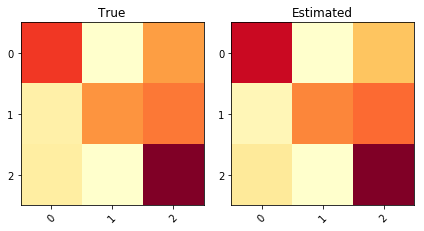

KL divergence: 0.0157	Pearson Correlation between diagonals: 0.9561


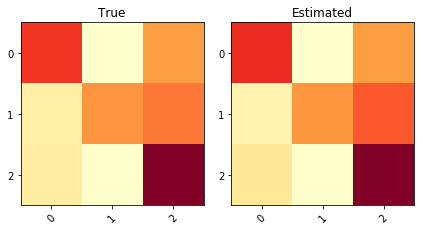

KL divergence: 0.0025	Pearson Correlation between diagonals: 0.9967


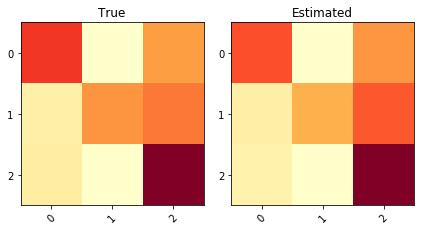

KL divergence: 0.0060	Pearson Correlation between diagonals: 1.0000


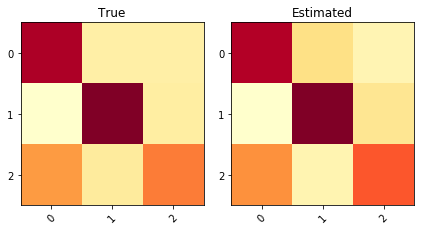

KL divergence: 0.0197	Pearson Correlation between diagonals: 0.9973


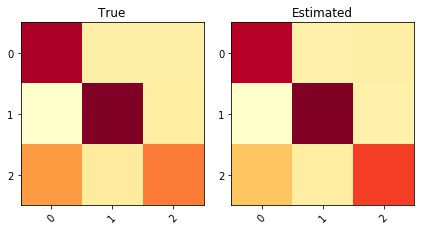

KL divergence: 0.0132	Pearson Correlation between diagonals: 0.9865


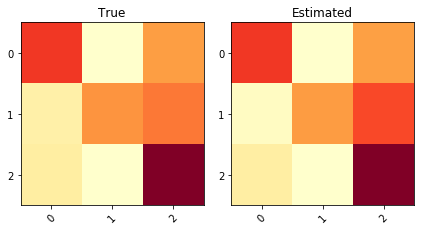

KL divergence: 0.0191	Pearson Correlation between diagonals: 0.9995


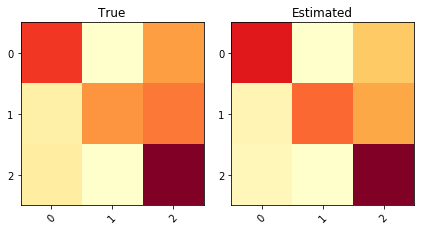

KL divergence: 0.0264	Pearson Correlation between diagonals: 0.9988


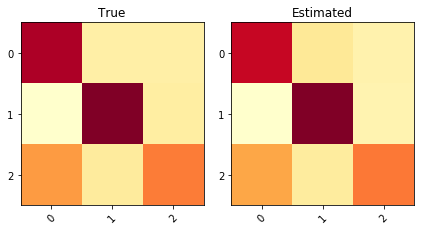

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9882
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.923484      0.923484  0.0104411  0.00243444            0.990606
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.93895       0.93895
====  ======  ==========  ============


In [30]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


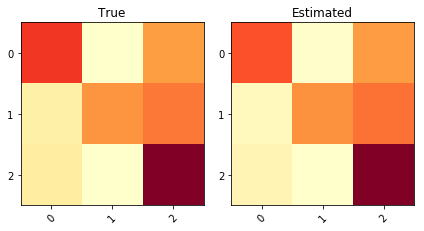

KL divergence: 0.0173	Pearson Correlation between diagonals: 0.9906


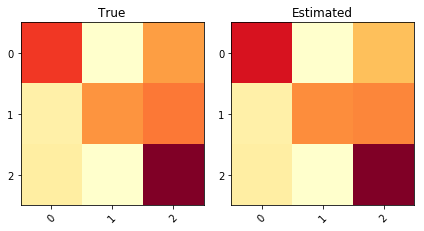

KL divergence: 0.0148	Pearson Correlation between diagonals: 0.9764


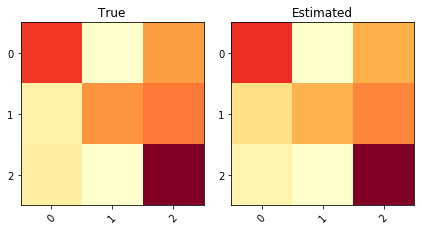

KL divergence: 0.0244	Pearson Correlation between diagonals: 0.9874


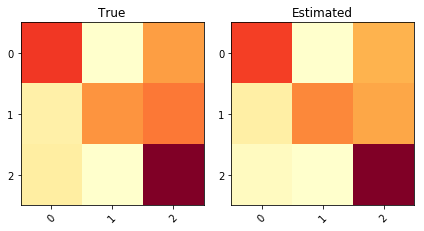

KL divergence: 0.0260	Pearson Correlation between diagonals: 0.9962


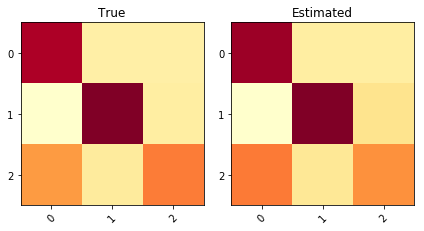

KL divergence: 0.0112	Pearson Correlation between diagonals: 0.9965


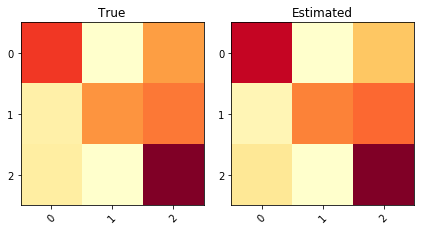

KL divergence: 0.0233	Pearson Correlation between diagonals: 0.9453


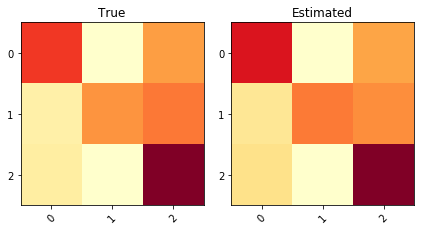

KL divergence: 0.0200	Pearson Correlation between diagonals: 0.9890


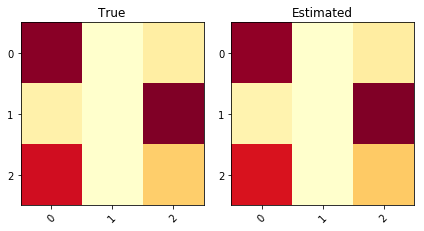

KL divergence: 0.0132	Pearson Correlation between diagonals: 0.9997


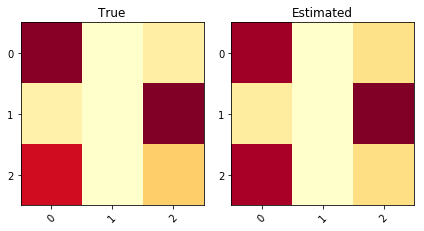

KL divergence: 0.0266	Pearson Correlation between diagonals: 0.9975


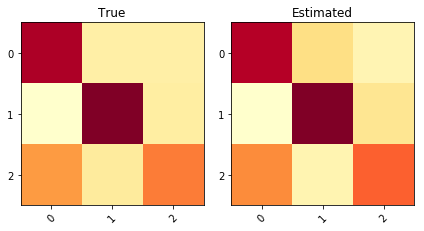

KL divergence: 0.0216	Pearson Correlation between diagonals: 0.9977


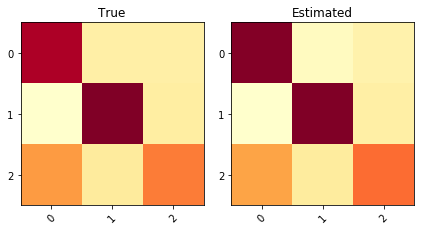

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9854


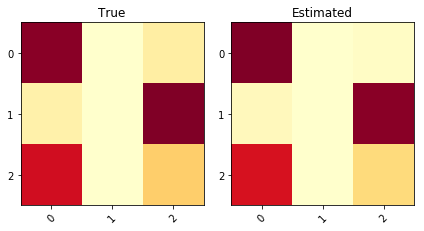

KL divergence: 0.0336	Pearson Correlation between diagonals: 0.9981


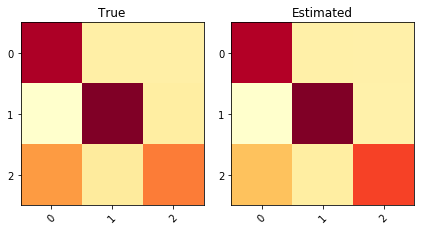

KL divergence: 0.0137	Pearson Correlation between diagonals: 0.9929


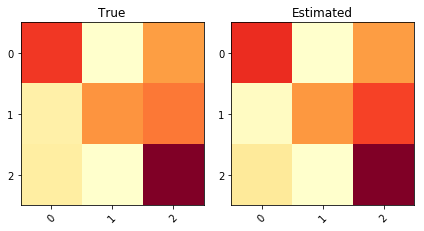

KL divergence: 0.0217	Pearson Correlation between diagonals: 0.9977


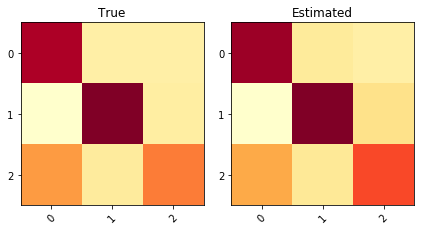

KL divergence: 0.0143	Pearson Correlation between diagonals: 0.9992
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.860399      0.860399  0.0158442  0.00464248            0.990243        0.114815
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.654542                0.779581
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.87

In [31]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


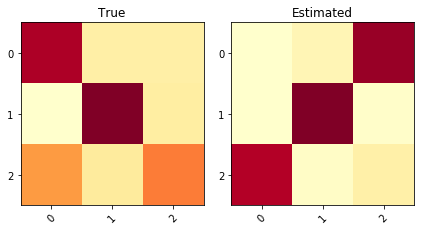

KL divergence: 1.7644	Pearson Correlation between diagonals: 0.5853


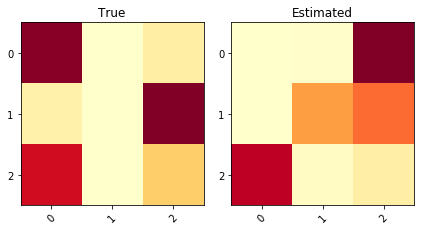

KL divergence: 1.6860	Pearson Correlation between diagonals: -0.8660


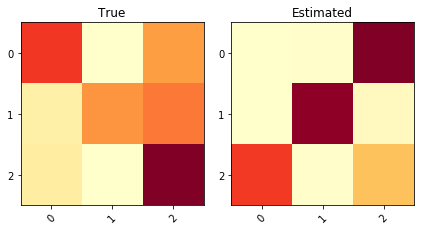

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


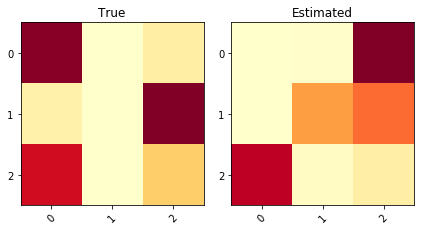

KL divergence: 1.6860	Pearson Correlation between diagonals: -0.8660


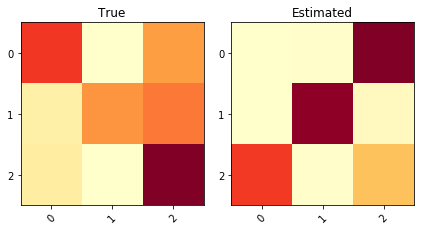

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


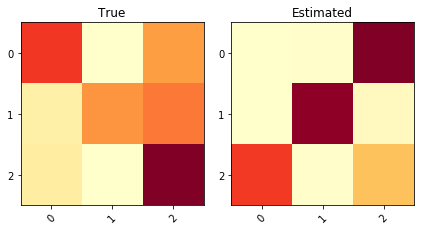

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


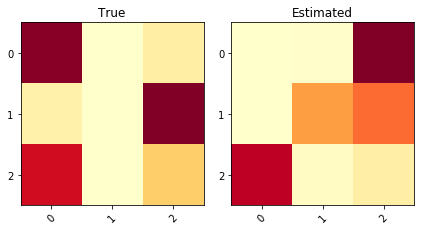

KL divergence: 1.6860	Pearson Correlation between diagonals: -0.8660


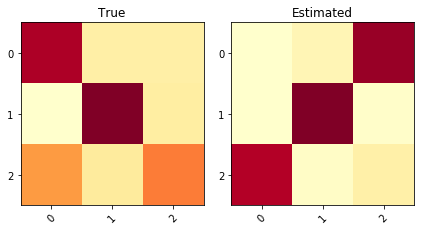

KL divergence: 1.7644	Pearson Correlation between diagonals: 0.5853


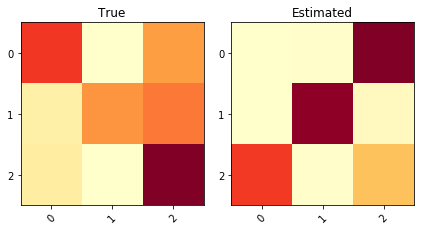

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


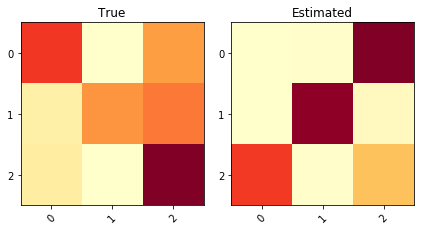

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


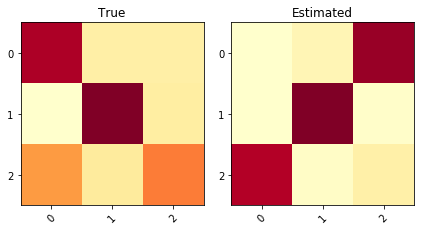

KL divergence: 1.7644	Pearson Correlation between diagonals: 0.5853


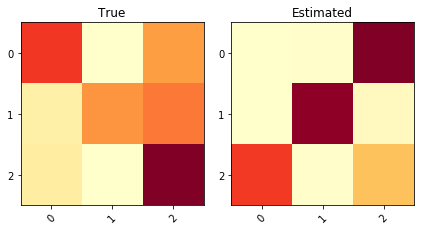

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


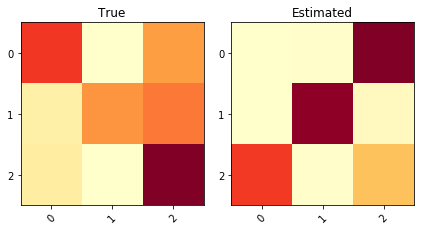

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


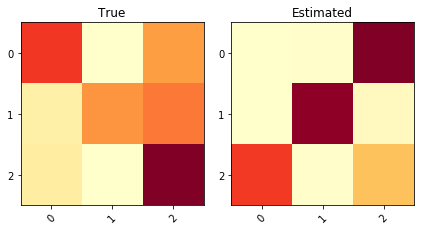

KL divergence: 1.7517	Pearson Correlation between diagonals: -0.5552


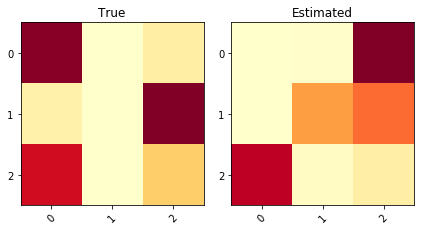

KL divergence: 1.6860	Pearson Correlation between diagonals: -0.8660
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.341066      0.341066    1.74457   0.220065           -0.243035       0.0797911
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.660772                0.747128
====  =======================  ======================
Test


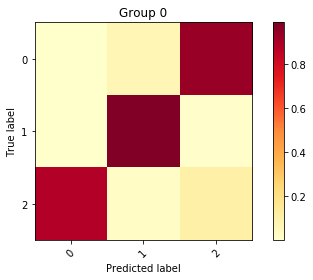

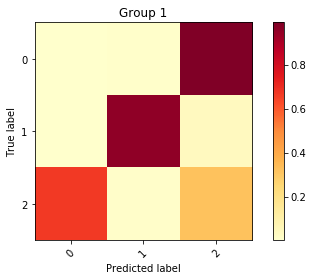

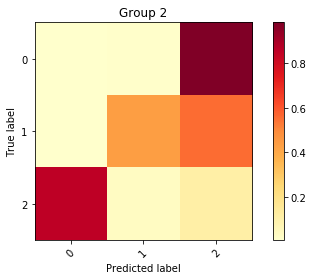

Inertia: 0.05737205408513546
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.343771      34   0.249123     0.363822    2.75994       0.417107   0.0304886    0.909646      0.909646
   1         1  0.524327      52   0.305129     0.426697    2.55181       0.504722   0.0933633    0.838828      0.838828
   2         2  0.131902      13   0.43366      0.184033    2.7207        0.307366  -0.1493       0.647131      0.647131
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [32]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#con tol 2
832723/ 0,612666 #pre init 5
862027 / 0,567259 #pre init 1
904762 / 0,480586 # pre init 0

In [ ]:
#con tol 3
873016/0,465721 #pre init 5
344322/1,2807 #pre init 1
882784/0,609833 #pre init 0

*** Ours (2) multiples runs***
Train


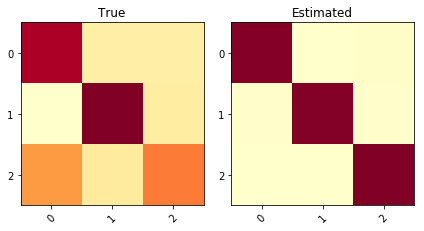

KL divergence: 0.7548	Pearson Correlation between diagonals: -0.8756


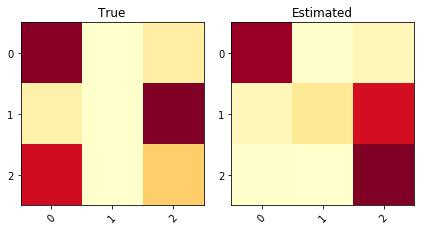

KL divergence: 0.8811	Pearson Correlation between diagonals: 0.6806


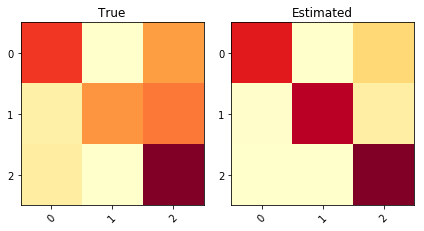

KL divergence: 0.2823	Pearson Correlation between diagonals: 0.6015


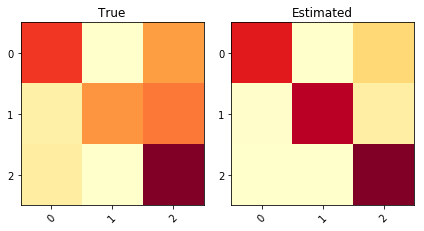

KL divergence: 0.2823	Pearson Correlation between diagonals: 0.6015


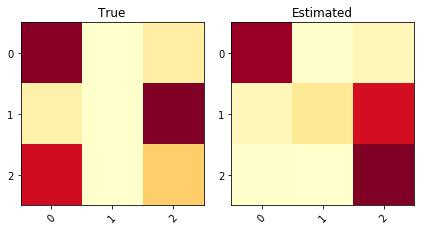

KL divergence: 0.8811	Pearson Correlation between diagonals: 0.6806


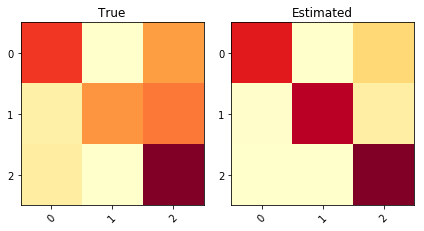

KL divergence: 0.2823	Pearson Correlation between diagonals: 0.6015


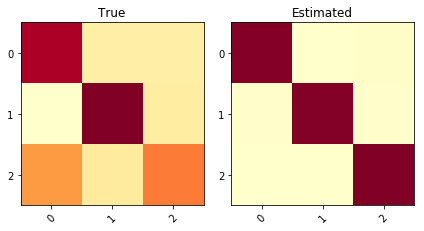

KL divergence: 0.7548	Pearson Correlation between diagonals: -0.8756


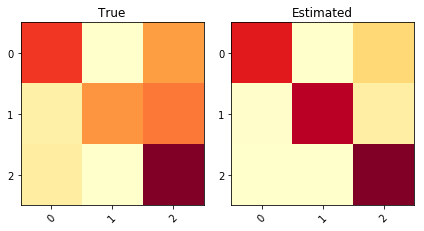

KL divergence: 0.2823	Pearson Correlation between diagonals: 0.6015


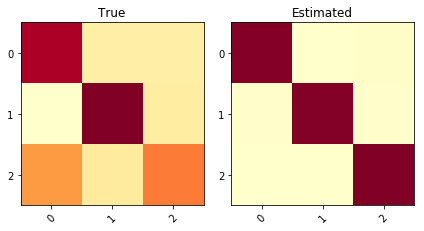

KL divergence: 0.7548	Pearson Correlation between diagonals: -0.8756


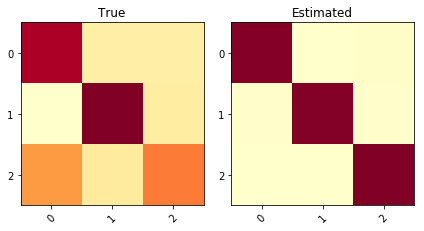

KL divergence: 0.7548	Pearson Correlation between diagonals: -0.8756


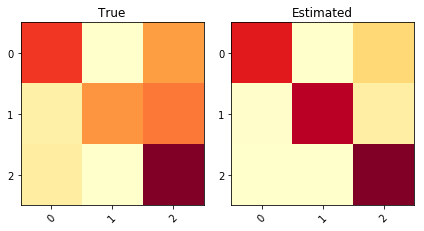

KL divergence: 0.2823	Pearson Correlation between diagonals: 0.6015


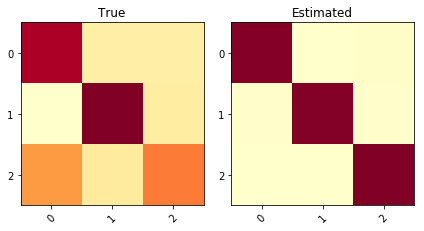

KL divergence: 0.7548	Pearson Correlation between diagonals: -0.8756


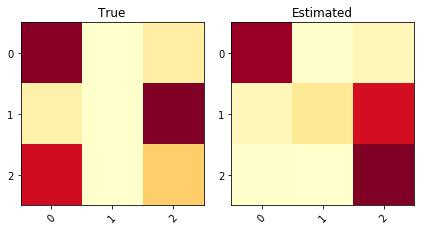

KL divergence: 0.8811	Pearson Correlation between diagonals: 0.6806


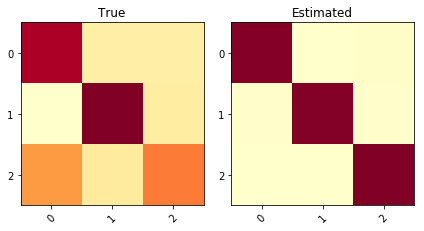

KL divergence: 0.7548	Pearson Correlation between diagonals: -0.8756


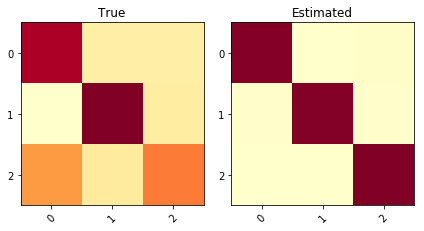

KL divergence: 0.7548	Pearson Correlation between diagonals: -0.8756
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.890924      0.890924   0.535272  0.0798288              0.1423       0.0824304
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.660067                0.744381
====  =======================  ======================
Test


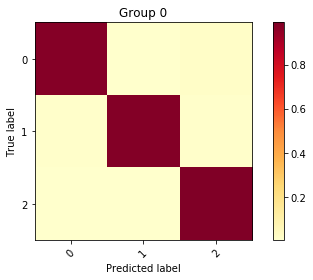

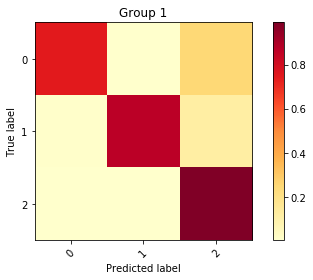

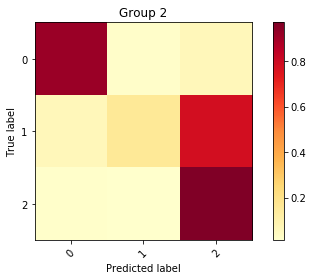

Inertia: 0.09522982283184926
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.404513      40  0.0977675     0.982631  0.0175382       0.991255   0.649297    0.897436      0.897436
   1         1  0.475136      47  0.358579      0.869196  0.146842        0.929073   0.535863    0.791209      0.791209
   2         2  0.120351      12  0.381128      0.680829  0.65771         0.75738    0.347496    0.650794      0.650794
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [33]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

 870574 / 0,498641 #con tol2
942613 / 0,471945 #pre init 1
86569/0,579983 #pre init 0

In [ ]:
#con tol3
913309/ 0,539815 #pre init 5
879121/ 0,729936 #pre init 1
875458/ 0,663098 #pre init 0

*** Ours (3) multiples runs***
Train


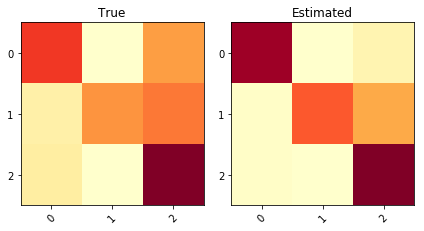

KL divergence: 0.2146	Pearson Correlation between diagonals: 0.8778


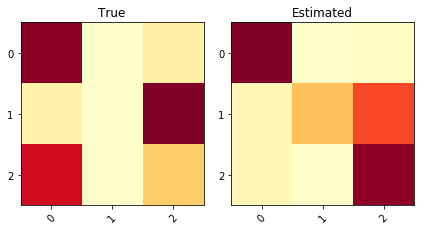

KL divergence: 0.6666	Pearson Correlation between diagonals: 0.7527


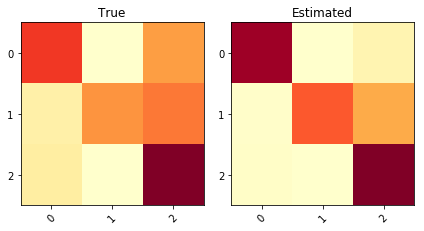

KL divergence: 0.2152	Pearson Correlation between diagonals: 0.8786


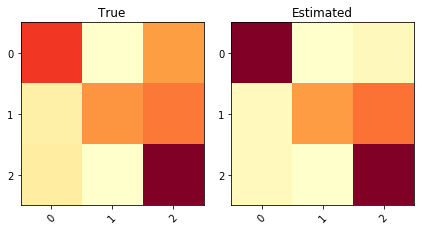

KL divergence: 0.2109	Pearson Correlation between diagonals: 0.8016


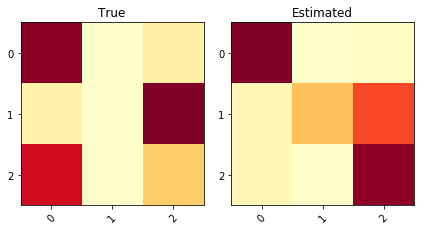

KL divergence: 0.6666	Pearson Correlation between diagonals: 0.7527


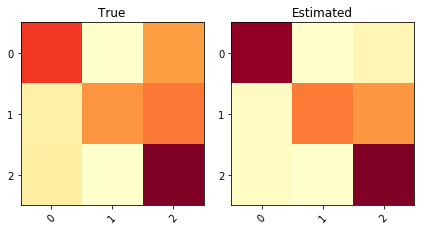

KL divergence: 0.1962	Pearson Correlation between diagonals: 0.8390


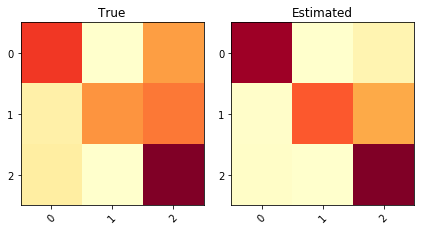

KL divergence: 0.2150	Pearson Correlation between diagonals: 0.8783


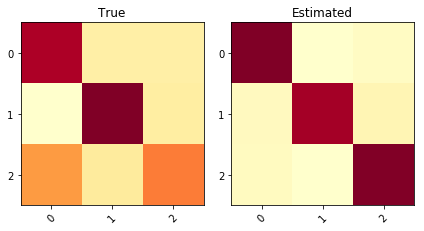

KL divergence: 0.4452	Pearson Correlation between diagonals: -0.6140


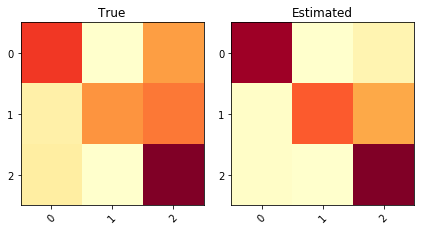

KL divergence: 0.2128	Pearson Correlation between diagonals: 0.8758


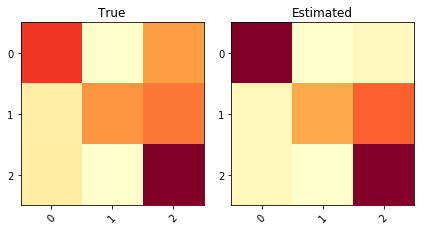

KL divergence: 0.2299	Pearson Correlation between diagonals: 0.7875


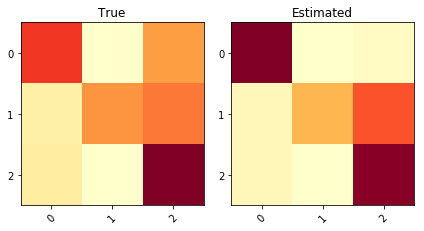

KL divergence: 0.2532	Pearson Correlation between diagonals: 0.7769


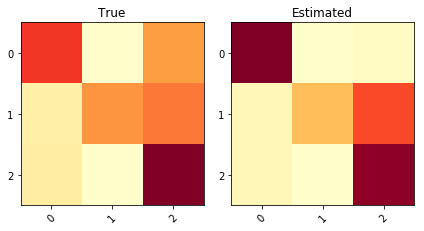

KL divergence: 0.2764	Pearson Correlation between diagonals: 0.7695


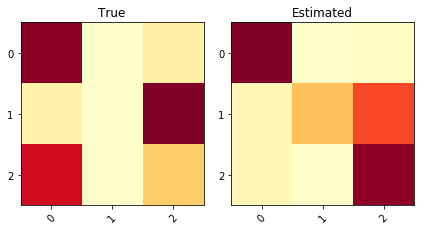

KL divergence: 0.6666	Pearson Correlation between diagonals: 0.7527


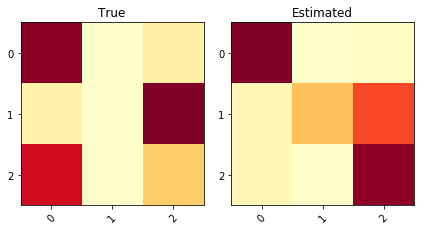

KL divergence: 0.6666	Pearson Correlation between diagonals: 0.7527


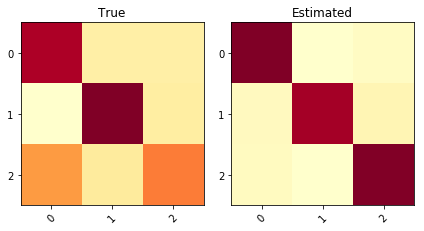

KL divergence: 0.4452	Pearson Correlation between diagonals: -0.6140
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.924705      0.924705    0.37426  0.0675633            0.351275       0.0761961
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.671144                0.743394
====  =======================  ======================
Test


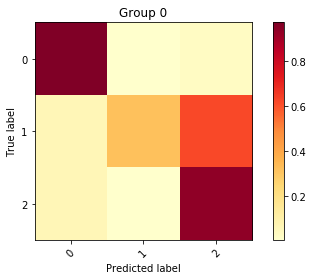

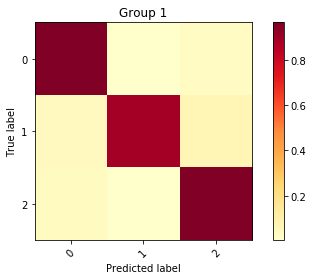

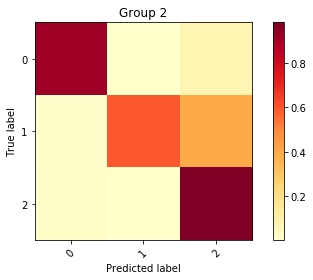

Inertia: 0.038497631127635636
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.396129      39   0.402205     0.742913  0.411924        0.826744   0.409579    0.64591       0.64591
   1         1  0.206042      20   0.255365     0.938507  0.0641152       0.968325   0.605174    0.93895       0.93895
   2         2  0.397828      39   0.37257      0.832291  0.207239        0.903138   0.498957    0.870574      0.870574
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [34]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
#con tol2
84127 /  0,944489
875458 / 0,695265 #pre init 1
935287 / 0,411736 #pre init 0

In [ ]:
#con tol3
923077 / 0,579925 #pre init 5
925519 / 0,433611 #pre init 1
369963 / 1,47762 #pre init 0

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [51]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.5946275946275946


*** Soft-Majority (Train with softMV) ***
Train


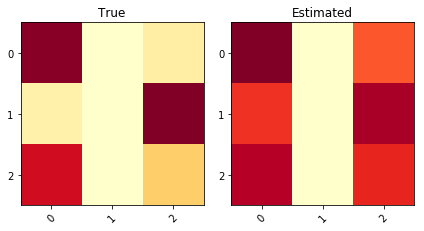

KL divergence: 0.1880	Pearson Correlation between diagonals: 0.8816


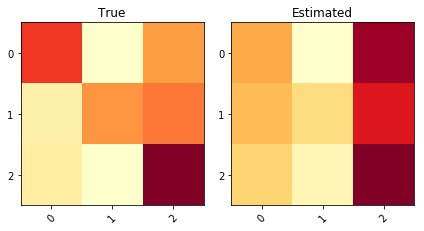

KL divergence: 0.2243	Pearson Correlation between diagonals: 0.9839


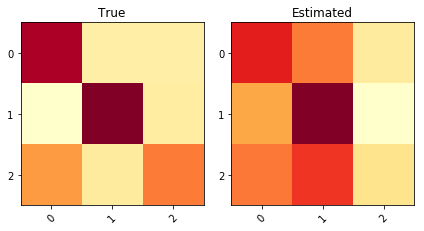

KL divergence: 0.3165	Pearson Correlation between diagonals: 0.9930


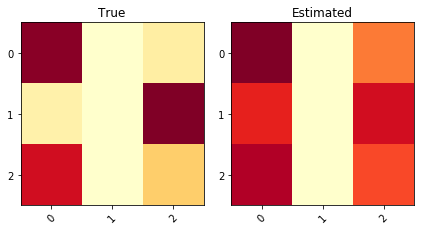

KL divergence: 0.1920	Pearson Correlation between diagonals: 0.9212


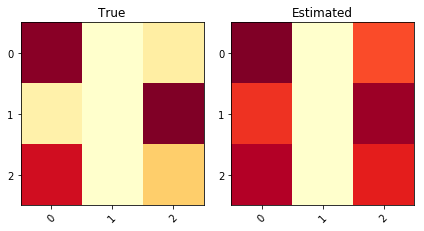

KL divergence: 0.1888	Pearson Correlation between diagonals: 0.8734


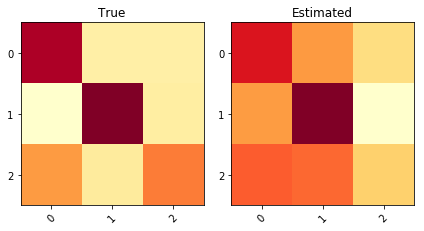

KL divergence: 0.2967	Pearson Correlation between diagonals: 0.9937


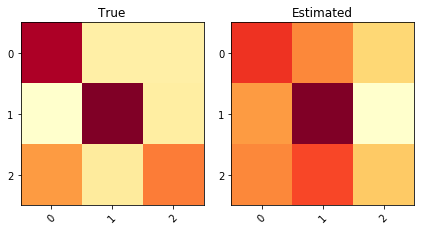

KL divergence: 0.3226	Pearson Correlation between diagonals: 0.9656


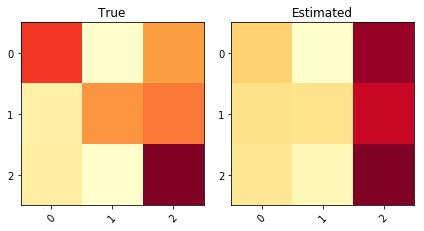

KL divergence: 0.2260	Pearson Correlation between diagonals: 0.9557


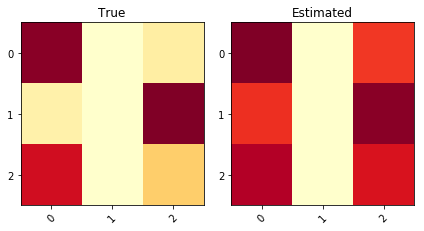

KL divergence: 0.1958	Pearson Correlation between diagonals: 0.8499


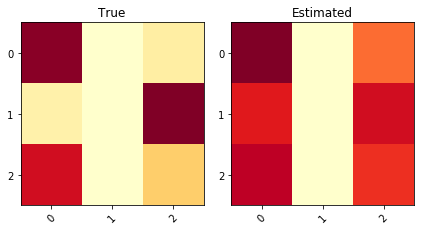

KL divergence: 0.2054	Pearson Correlation between diagonals: 0.8956


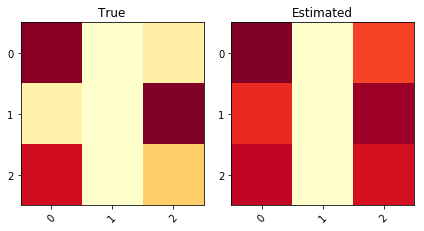

KL divergence: 0.2040	Pearson Correlation between diagonals: 0.8405


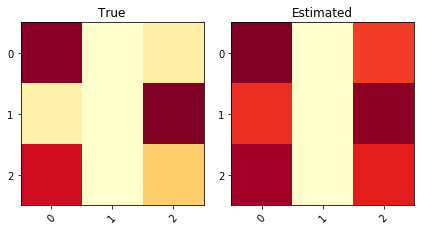

KL divergence: 0.1887	Pearson Correlation between diagonals: 0.8739


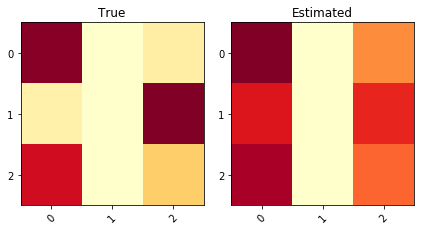

KL divergence: 0.2013	Pearson Correlation between diagonals: 0.9456


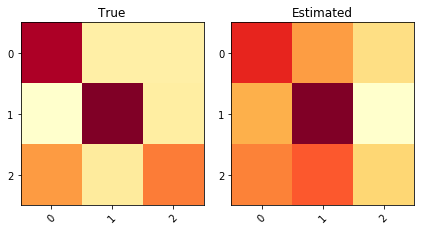

KL divergence: 0.3000	Pearson Correlation between diagonals: 0.9838


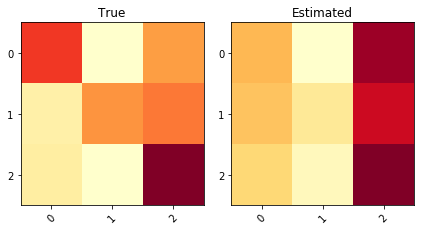

KL divergence: 0.2257	Pearson Correlation between diagonals: 0.9866
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.425722      0.425722   0.238755   0.067459            0.939624
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.46398       0.46398
====  ======  ==========  ============


In [52]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


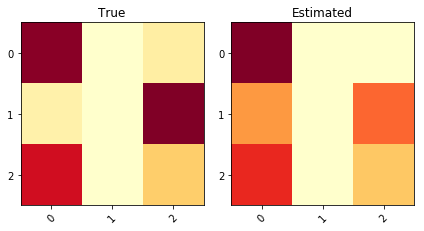

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


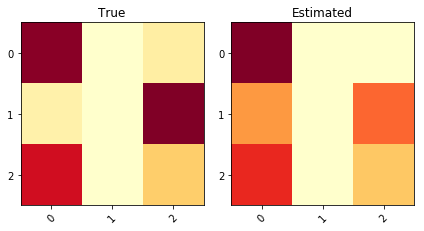

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


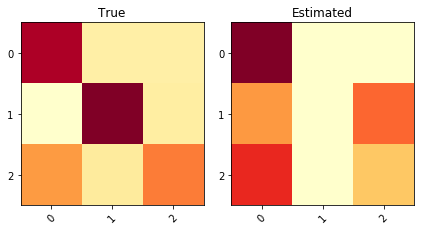

KL divergence: 6.0199	Pearson Correlation between diagonals: 0.0322


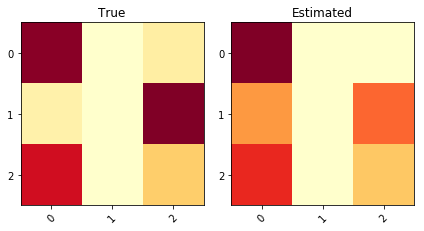

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


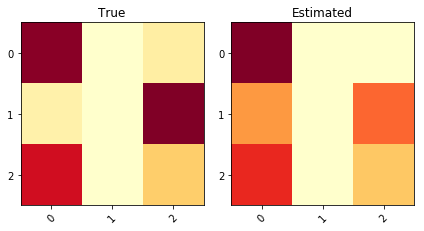

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


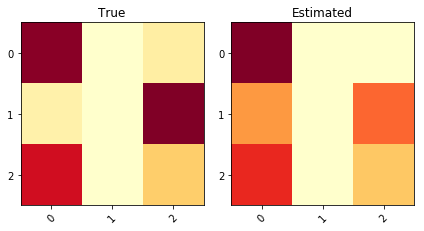

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


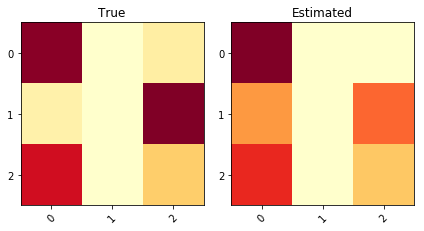

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


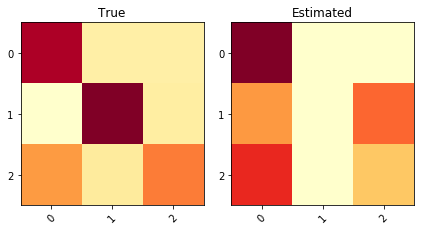

KL divergence: 6.0199	Pearson Correlation between diagonals: 0.0322


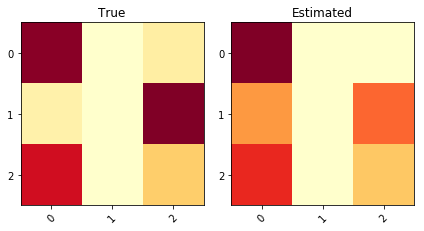

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


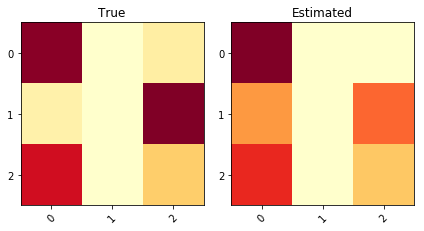

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


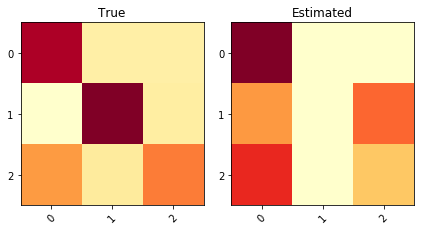

KL divergence: 6.0199	Pearson Correlation between diagonals: 0.0322


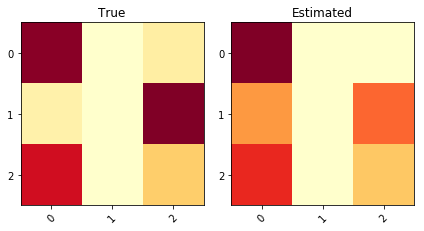

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.9999


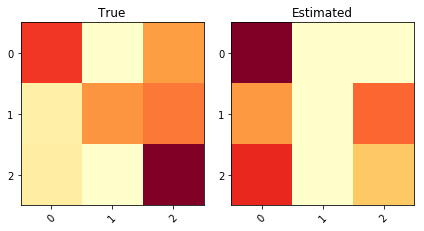

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.1696


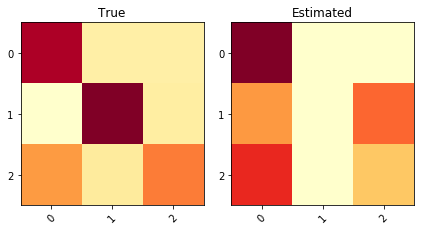

KL divergence: 6.0199	Pearson Correlation between diagonals: 0.0322


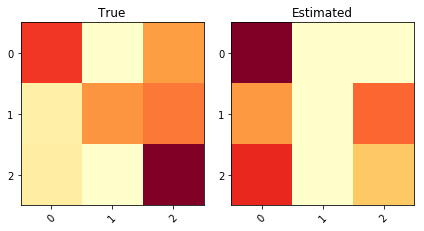

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.1696
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.425722      0.425722    2.46516   0.146449            0.496465
====  ======  ==========  ============  =========  =========  ==================


In [53]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


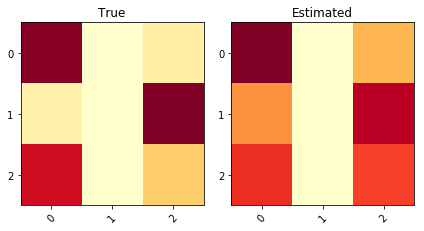

KL divergence: 0.1275	Pearson Correlation between diagonals: 0.9127


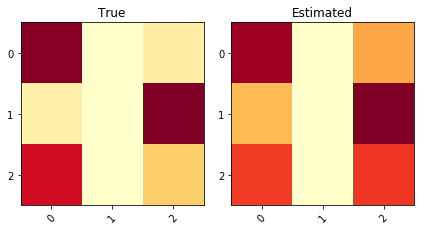

KL divergence: 0.1129	Pearson Correlation between diagonals: 0.8787


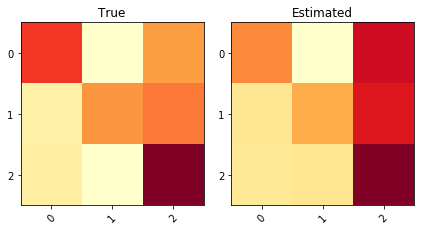

KL divergence: 0.1417	Pearson Correlation between diagonals: 0.9755


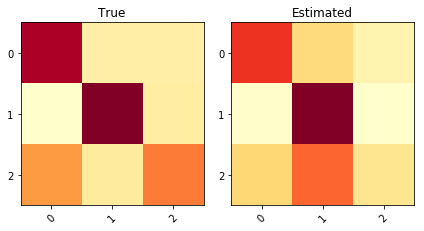

KL divergence: 0.2058	Pearson Correlation between diagonals: 0.9831


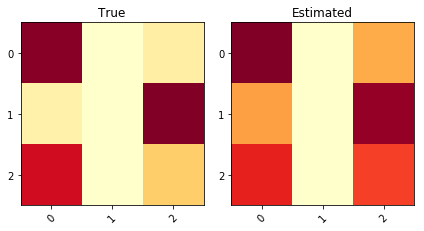

KL divergence: 0.1126	Pearson Correlation between diagonals: 0.9138


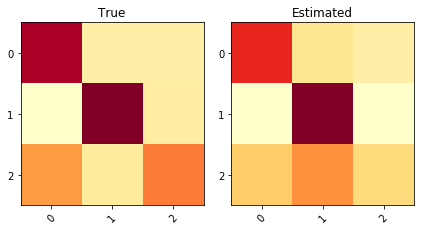

KL divergence: 0.1959	Pearson Correlation between diagonals: 0.9851


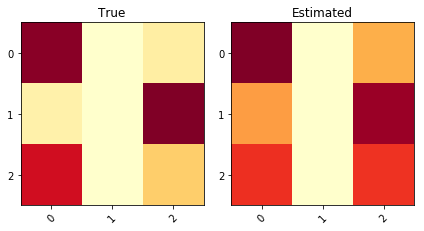

KL divergence: 0.1219	Pearson Correlation between diagonals: 0.8992


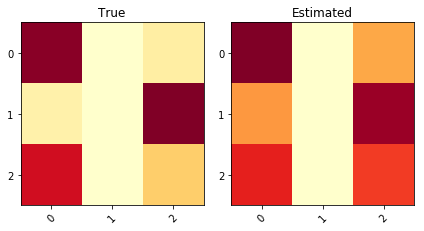

KL divergence: 0.1228	Pearson Correlation between diagonals: 0.9070


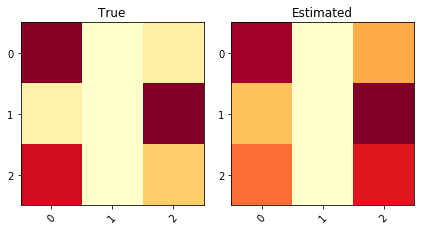

KL divergence: 0.1348	Pearson Correlation between diagonals: 0.8263


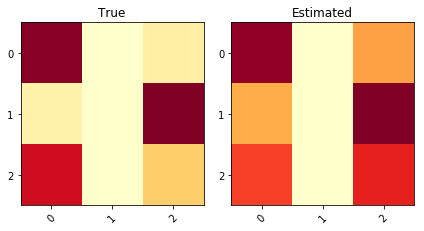

KL divergence: 0.1285	Pearson Correlation between diagonals: 0.8604


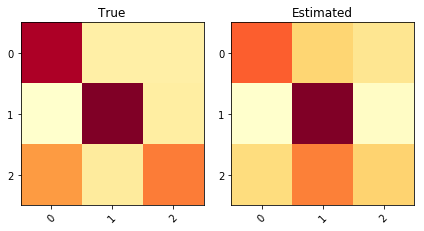

KL divergence: 0.2248	Pearson Correlation between diagonals: 0.9213


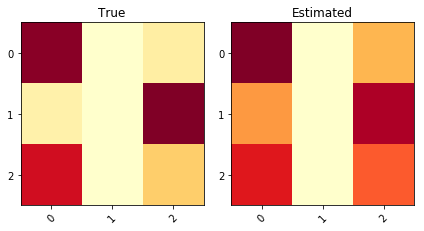

KL divergence: 0.1090	Pearson Correlation between diagonals: 0.9377


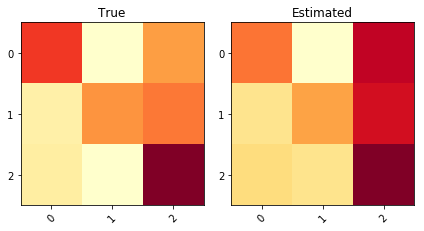

KL divergence: 0.1562	Pearson Correlation between diagonals: 0.9822


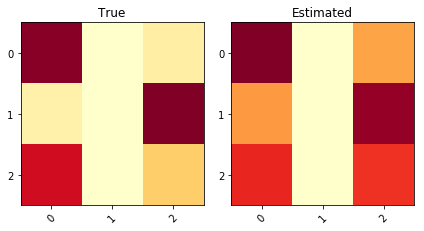

KL divergence: 0.1259	Pearson Correlation between diagonals: 0.8973


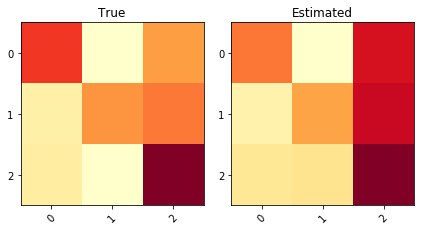

KL divergence: 0.1337	Pearson Correlation between diagonals: 0.9829
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.628002      0.628002    0.15368  0.0438748            0.934636
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.637363      0.637363
====  ======  ==========  ============


In [54]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


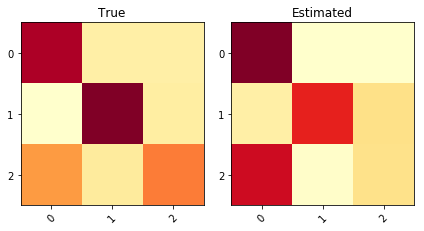

KL divergence: 0.8315	Pearson Correlation between diagonals: 0.8657


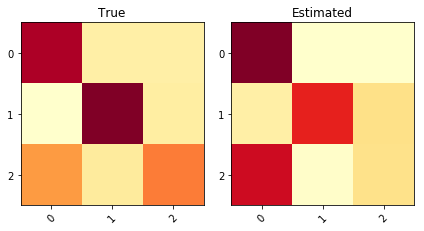

KL divergence: 0.8315	Pearson Correlation between diagonals: 0.8657


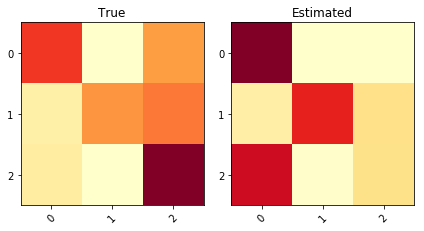

KL divergence: 0.3169	Pearson Correlation between diagonals: -0.7473


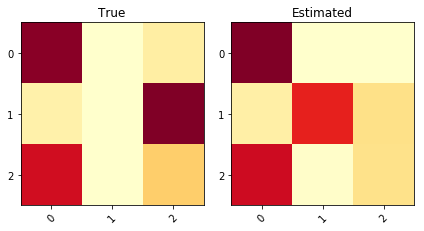

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.5392


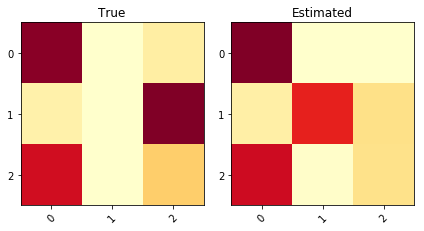

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.5392


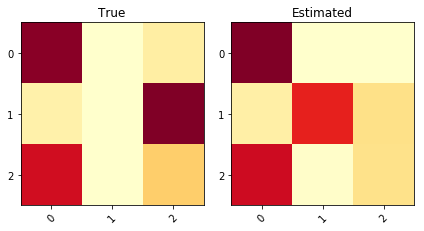

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.5392


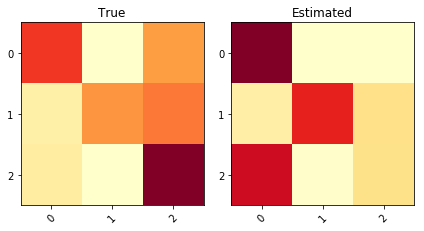

KL divergence: 0.3169	Pearson Correlation between diagonals: -0.7473


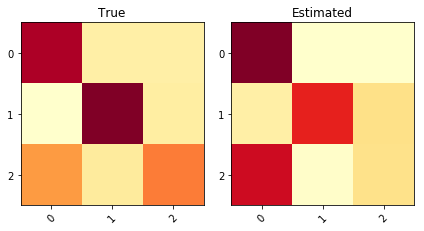

KL divergence: 0.8315	Pearson Correlation between diagonals: 0.8657


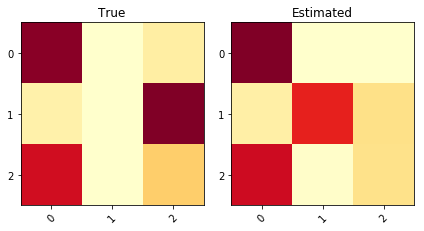

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.5392


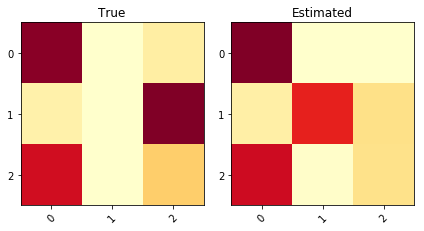

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.5392


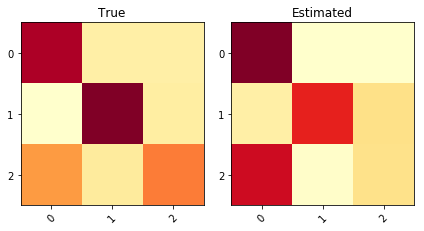

KL divergence: 0.8315	Pearson Correlation between diagonals: 0.8657


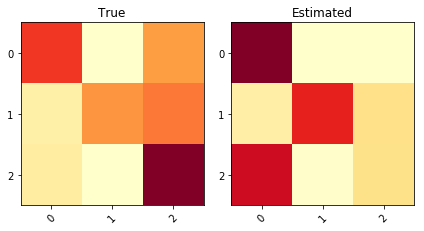

KL divergence: 0.3169	Pearson Correlation between diagonals: -0.7473


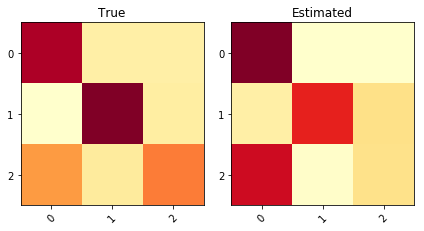

KL divergence: 0.8315	Pearson Correlation between diagonals: 0.8657


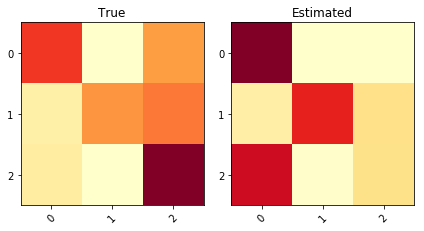

KL divergence: 0.3169	Pearson Correlation between diagonals: -0.7473


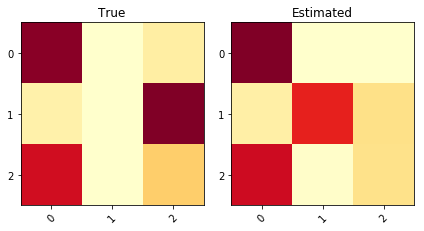

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.5392
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.628002      0.628002   0.569252   0.152452            0.270398
====  ======  ==========  ============  =========  =========  ==================


In [55]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


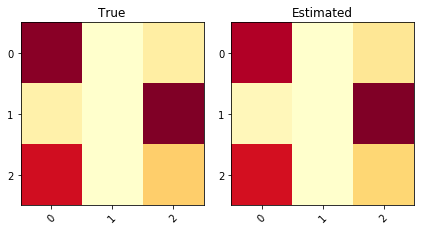

KL divergence: 0.0066	Pearson Correlation between diagonals: 1.0000


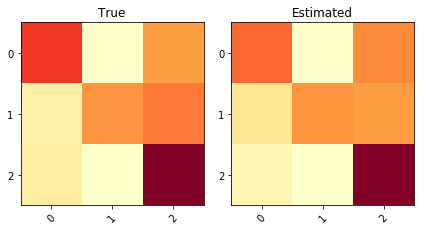

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9769


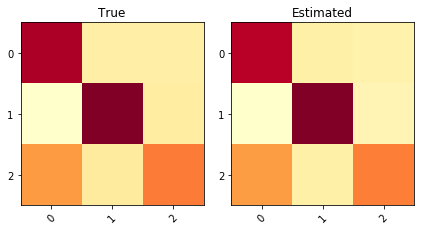

KL divergence: 0.0045	Pearson Correlation between diagonals: 0.9986


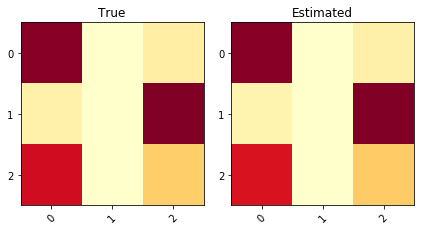

KL divergence: 0.0008	Pearson Correlation between diagonals: 0.9999


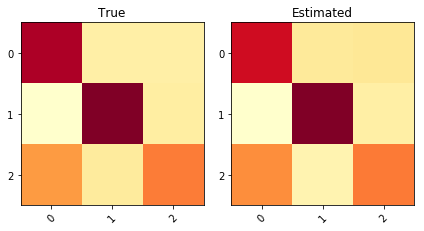

KL divergence: 0.0110	Pearson Correlation between diagonals: 0.9765


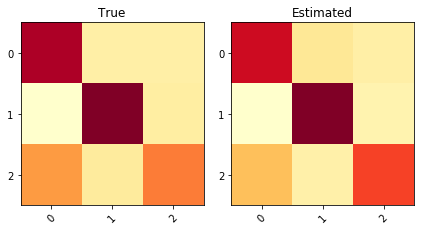

KL divergence: 0.0163	Pearson Correlation between diagonals: 0.9383


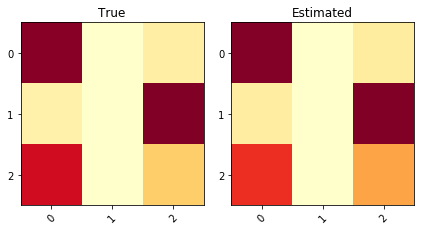

KL divergence: 0.0106	Pearson Correlation between diagonals: 0.9892


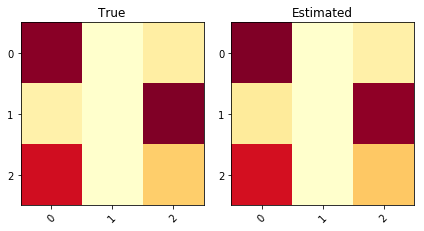

KL divergence: 0.0032	Pearson Correlation between diagonals: 0.9999


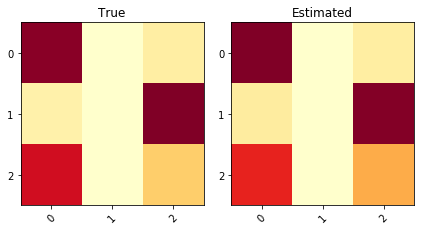

KL divergence: 0.0078	Pearson Correlation between diagonals: 0.9935


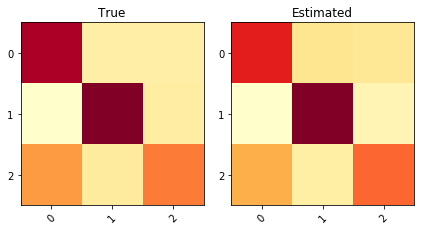

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.8999


KL divergence: 0.0023	Pearson Correlation between diagonals: 0.9999


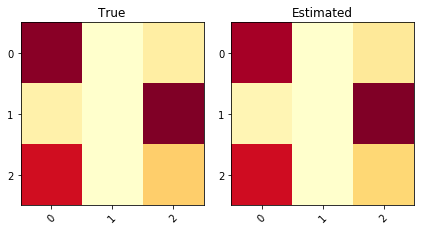

KL divergence: 0.0035	Pearson Correlation between diagonals: 0.9999


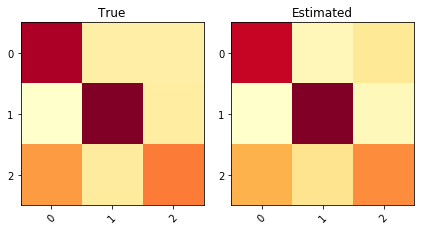

KL divergence: 0.0219	Pearson Correlation between diagonals: 0.9940


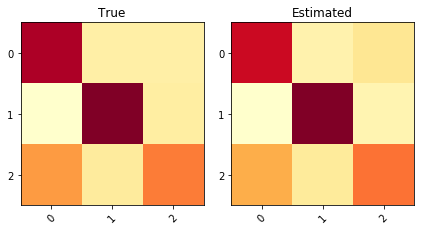

KL divergence: 0.0082	Pearson Correlation between diagonals: 0.9807


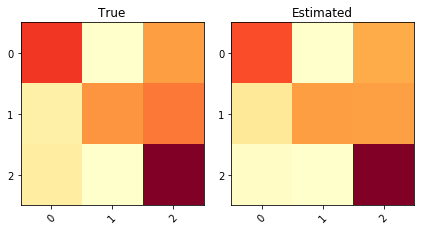

KL divergence: 0.0362	Pearson Correlation between diagonals: 0.9984
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.895808      0.895808  0.0155789  0.00327082            0.985279
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.897436      0.897436
====  ======  ==========  ============


In [56]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


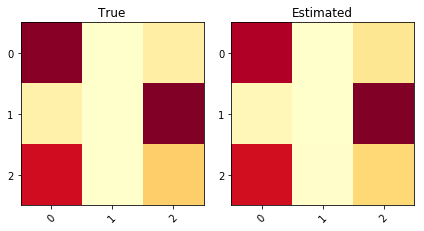

KL divergence: 0.0184	Pearson Correlation between diagonals: 0.9999


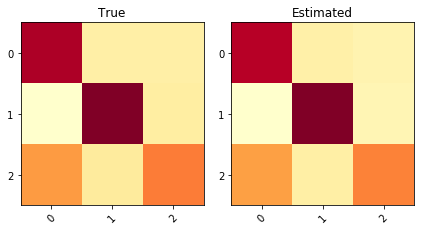

KL divergence: 0.0061	Pearson Correlation between diagonals: 0.9993


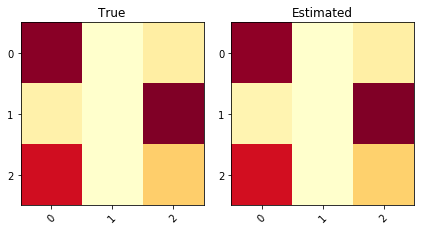

KL divergence: 0.0119	Pearson Correlation between diagonals: 1.0000


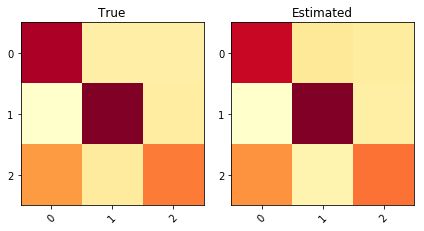

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9852


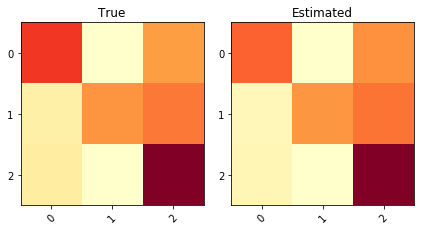

KL divergence: 0.0162	Pearson Correlation between diagonals: 0.9828


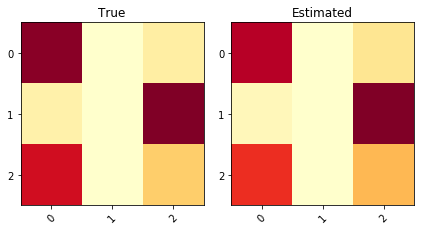

KL divergence: 0.0230	Pearson Correlation between diagonals: 0.9930


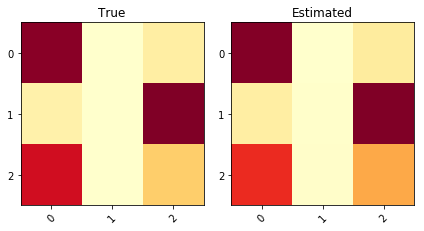

KL divergence: 0.0239	Pearson Correlation between diagonals: 0.9916


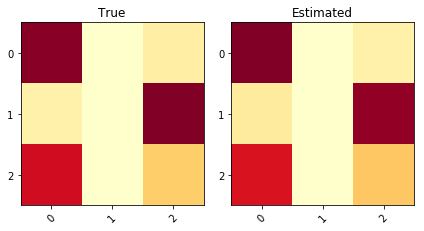

KL divergence: 0.0158	Pearson Correlation between diagonals: 0.9998


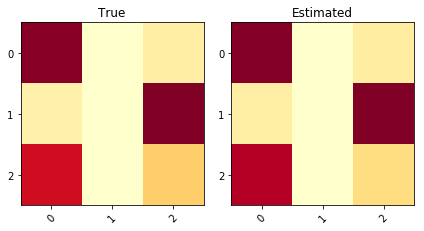

KL divergence: 0.0166	Pearson Correlation between diagonals: 0.9974


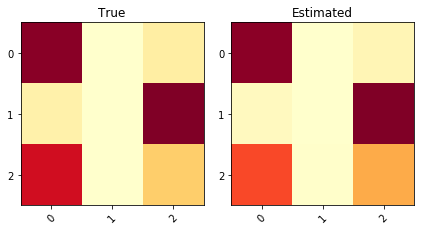

KL divergence: 0.0311	Pearson Correlation between diagonals: 0.9912


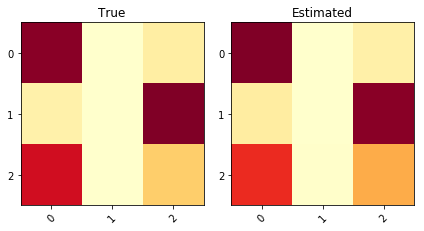

KL divergence: 0.0237	Pearson Correlation between diagonals: 0.9935


KL divergence: 0.0143	Pearson Correlation between diagonals: 0.9999


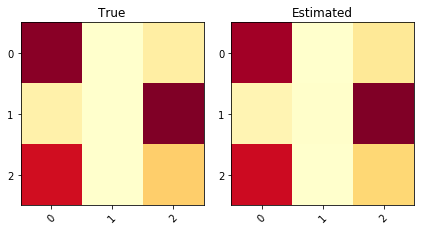

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9997


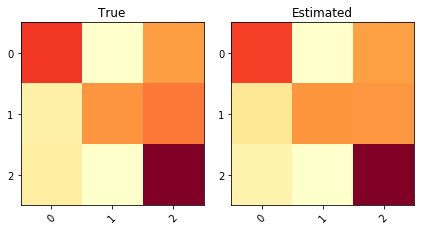

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9993


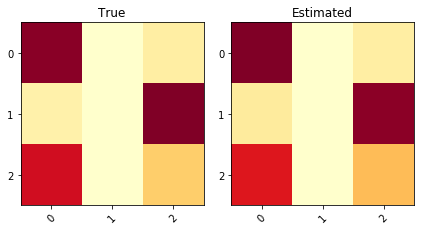

KL divergence: 0.0171	Pearson Correlation between diagonals: 0.9983
A result
 ====  ======  ==========  ============  =========  ==========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  ==========  ==================  ==============
   0  Global    0.880342      0.880342  0.0186704  0.00552049            0.989383         0.20836
====  ======  ==========  ============  =========  ==========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.72256                0.694256
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.8

In [57]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


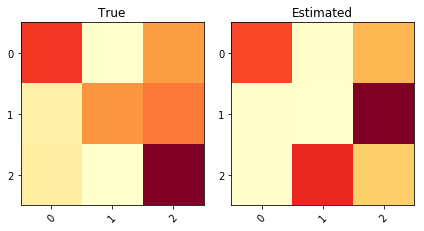

KL divergence: 0.9711	Pearson Correlation between diagonals: 0.3261


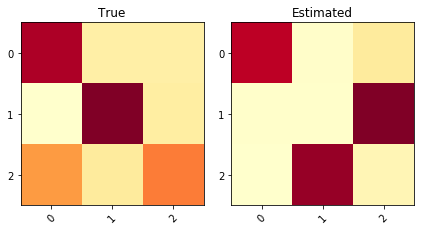

KL divergence: 1.8078	Pearson Correlation between diagonals: 0.2698


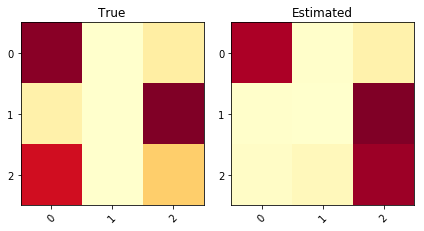

KL divergence: 0.8105	Pearson Correlation between diagonals: 0.7018


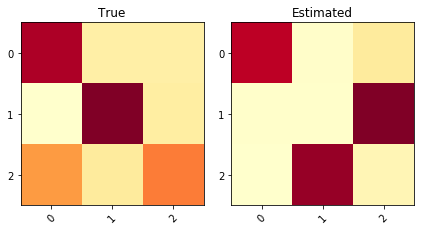

KL divergence: 1.8078	Pearson Correlation between diagonals: 0.2698


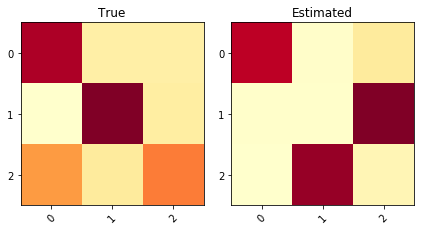

KL divergence: 1.8078	Pearson Correlation between diagonals: 0.2698


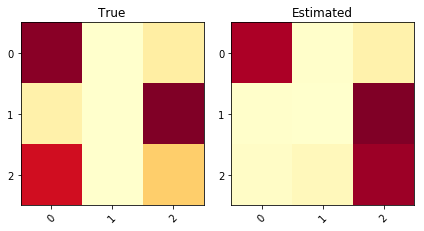

KL divergence: 0.8105	Pearson Correlation between diagonals: 0.7018


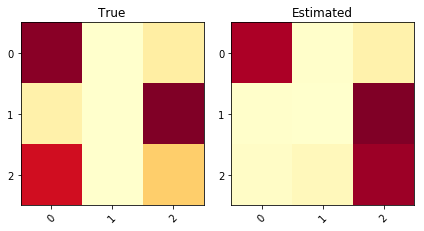

KL divergence: 0.8105	Pearson Correlation between diagonals: 0.7018


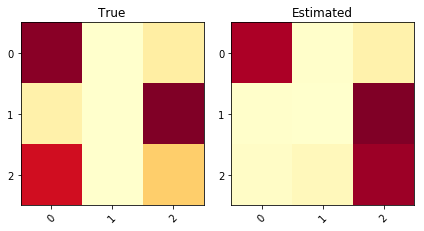

KL divergence: 0.8105	Pearson Correlation between diagonals: 0.7018


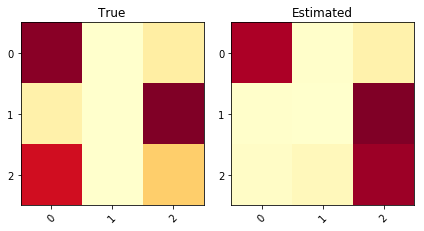

KL divergence: 0.8105	Pearson Correlation between diagonals: 0.7018


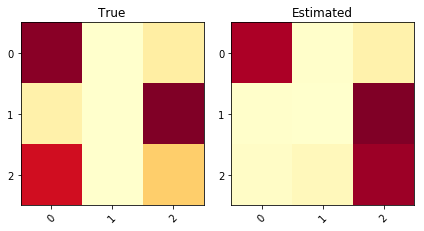

KL divergence: 0.8105	Pearson Correlation between diagonals: 0.7018


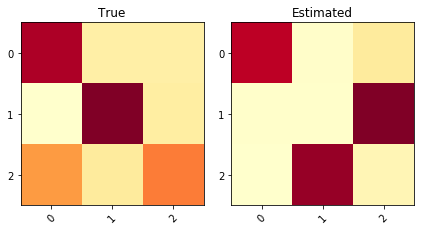

KL divergence: 1.8078	Pearson Correlation between diagonals: 0.2698


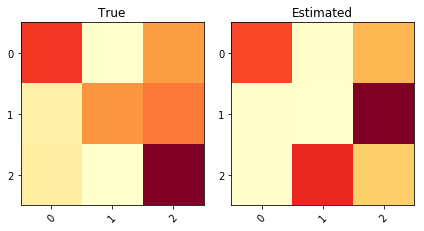

KL divergence: 0.9711	Pearson Correlation between diagonals: 0.3261


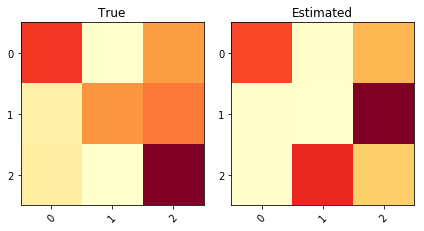

KL divergence: 0.9711	Pearson Correlation between diagonals: 0.3261


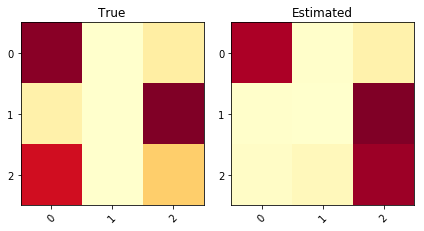

KL divergence: 0.8105	Pearson Correlation between diagonals: 0.7018


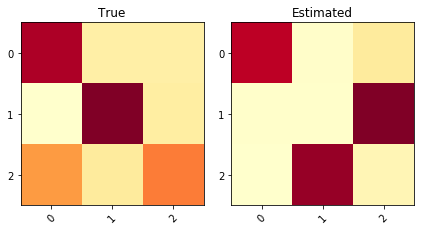

KL divergence: 1.8078	Pearson Correlation between diagonals: 0.2698
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.345543      0.345543    1.13468    0.18417            0.475674        0.195614
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.705634                0.655571
====  =======================  ======================
Test


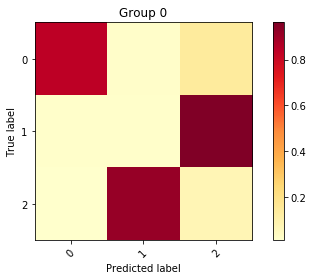

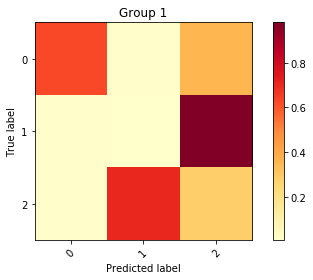

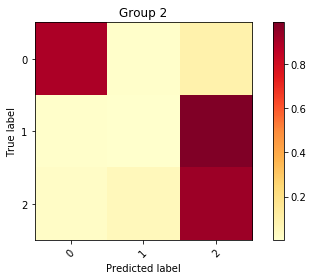

Inertia: 0.09492183290421963
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.305601      30   0.331978     0.310517    2.26905       0.390393  -0.0228162    0.678877      0.678877
   1         1  0.296716      29   0.497798     0.305163    2.28685       0.432089  -0.0281703    0.741148      0.741148
   2         2  0.397683      39   0.246048     0.609445    1.99414       0.641512   0.276112     0.489621      0.489621
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [58]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 0.5956	Pearson Correlation between diagonals: 0.1927


KL divergence: 0.6314	Pearson Correlation between diagonals: -0.1464


KL divergence: 0.5955	Pearson Correlation between diagonals: 0.1929


KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 0.6315	Pearson Correlation between diagonals: -0.1468


KL divergence: 0.5956	Pearson Correlation between diagonals: 0.1926


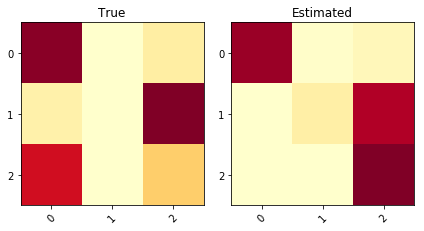

KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 0.5957	Pearson Correlation between diagonals: 0.1922


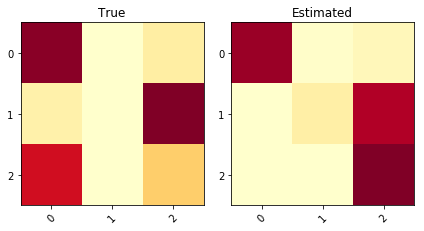

KL divergence: 1.3915	Pearson Correlation between diagonals: 0.6814


KL divergence: 0.6320	Pearson Correlation between diagonals: -0.1497
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.653643      0.653643   0.955877   0.109352            0.312409        0.199541
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.695553                0.683241
====  =======================  ======================
Test


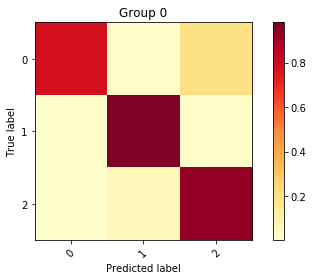

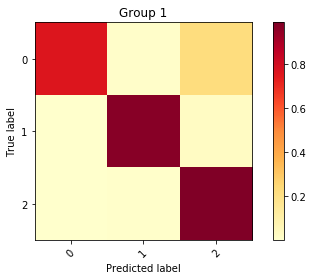

Inertia: 0.11174412545127173
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.287253      28   0.304848     0.901698   0.108202       0.94742    0.568364    0.863248      0.863248
   1         1  0.355553      35   0.265438     0.908026   0.103243       0.950134   0.574692    0.842491      0.842491
   2         2  0.357193      35   0.227716     0.678617   0.761877       0.740179   0.345284    0.498168      0.498168
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [59]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


KL divergence: 1.0814	Pearson Correlation between diagonals: 0.7158


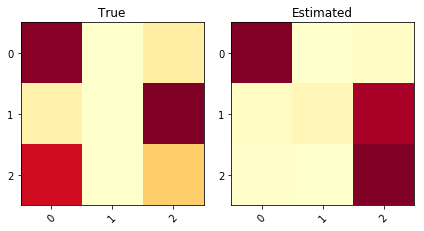

KL divergence: 1.0814	Pearson Correlation between diagonals: 0.7158


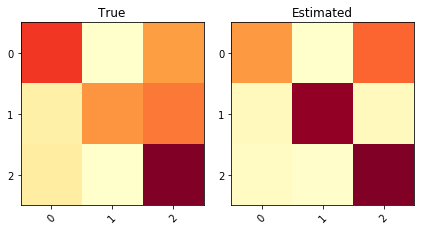

KL divergence: 0.3267	Pearson Correlation between diagonals: 0.1929


KL divergence: 0.5724	Pearson Correlation between diagonals: -0.3896


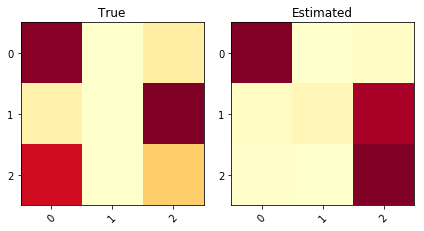

KL divergence: 1.0814	Pearson Correlation between diagonals: 0.7158


KL divergence: 0.5724	Pearson Correlation between diagonals: -0.3896


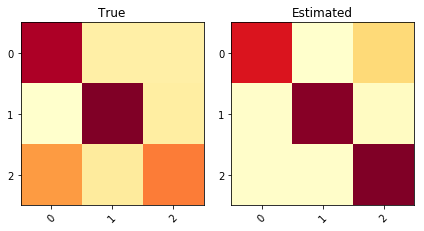

KL divergence: 0.5724	Pearson Correlation between diagonals: -0.3896


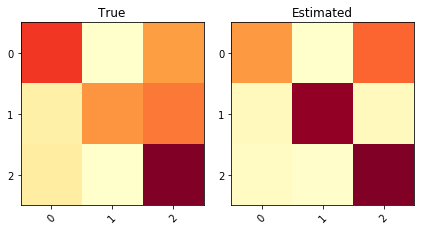

KL divergence: 0.3267	Pearson Correlation between diagonals: 0.1929


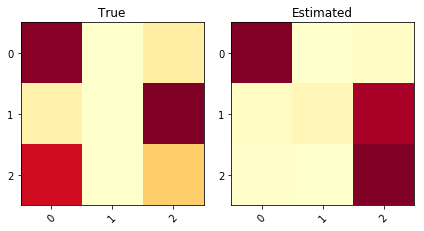

KL divergence: 1.0814	Pearson Correlation between diagonals: 0.7158


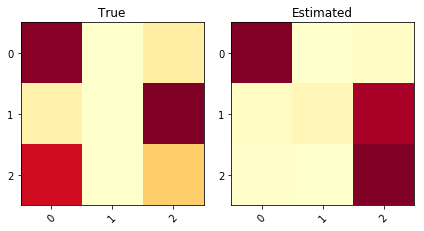

KL divergence: 1.0814	Pearson Correlation between diagonals: 0.7158


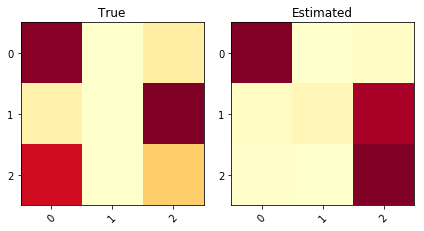

KL divergence: 1.0814	Pearson Correlation between diagonals: 0.7158


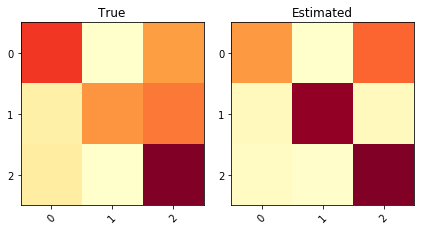

KL divergence: 0.3267	Pearson Correlation between diagonals: 0.1929


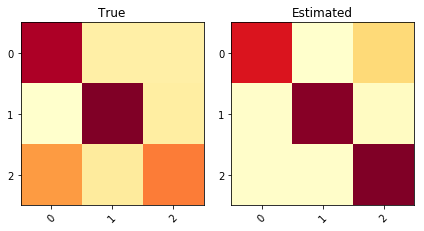

KL divergence: 0.5724	Pearson Correlation between diagonals: -0.3896


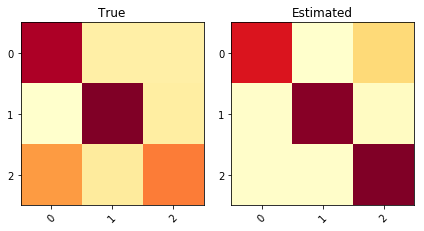

KL divergence: 0.5724	Pearson Correlation between diagonals: -0.3896


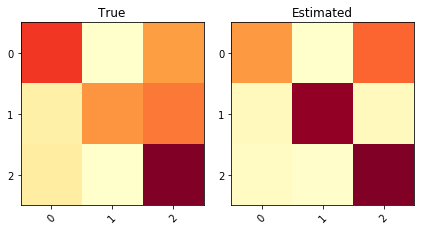

KL divergence: 0.3267	Pearson Correlation between diagonals: 0.1929
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.658934      0.658934   0.727565  0.0986497            0.259872        0.218844
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.709895                0.658389
====  =======================  ======================
Test


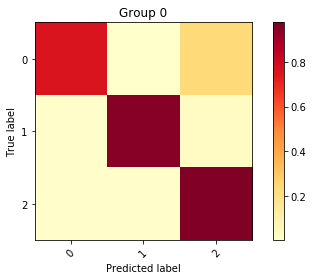

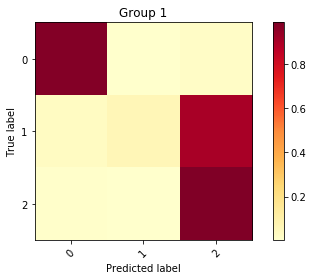

Inertia: 0.1451012628773848
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.416499      41   0.298862     0.897399   0.114698       0.944537   0.564066    0.888889      0.888889
   1         1  0.482111      48   0.180414     0.676596   0.940644       0.717779   0.343262    0.410256      0.410256
   2         2  0.10139       10   0.461884     0.761103   0.328806       0.852682   0.427769    0.599512      0.599512
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [60]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [77]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7956857956857957


*** Soft-Majority (Train with softMV) ***
Train


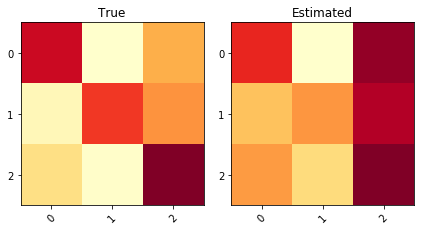

KL divergence: 0.1773	Pearson Correlation between diagonals: 1.0000


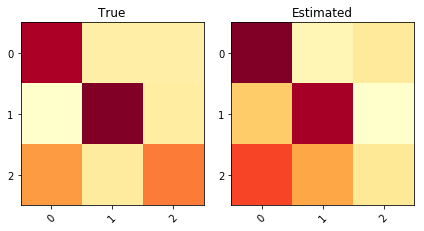

KL divergence: 0.2529	Pearson Correlation between diagonals: 0.9616


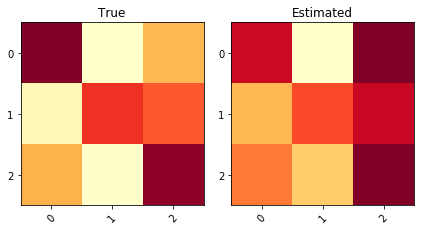

KL divergence: 0.1642	Pearson Correlation between diagonals: 0.8308


KL divergence: 0.1938	Pearson Correlation between diagonals: 0.9968


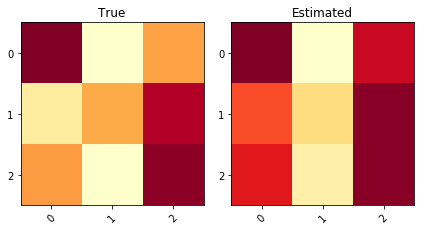

KL divergence: 0.1449	Pearson Correlation between diagonals: 0.9998


KL divergence: 0.1818	Pearson Correlation between diagonals: 0.9777


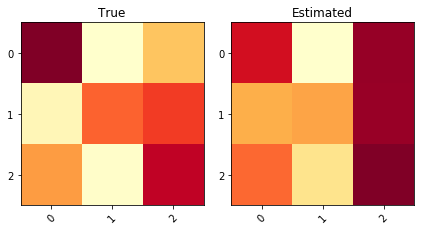

KL divergence: 0.1538	Pearson Correlation between diagonals: 0.7805


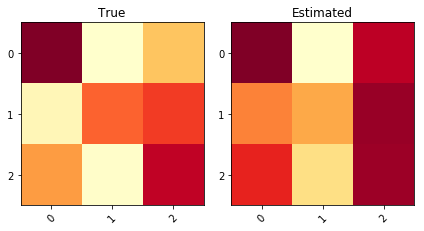

KL divergence: 0.1501	Pearson Correlation between diagonals: 0.9702


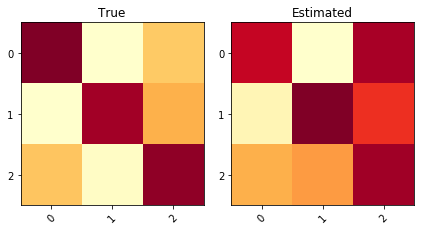

KL divergence: 0.1826	Pearson Correlation between diagonals: -0.9953


KL divergence: 0.1235	Pearson Correlation between diagonals: 0.9837


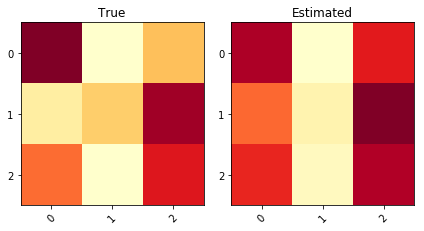

KL divergence: 0.1328	Pearson Correlation between diagonals: 0.9512


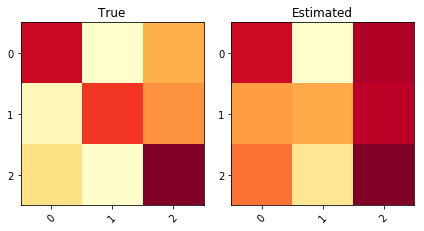

KL divergence: 0.1748	Pearson Correlation between diagonals: 0.9641


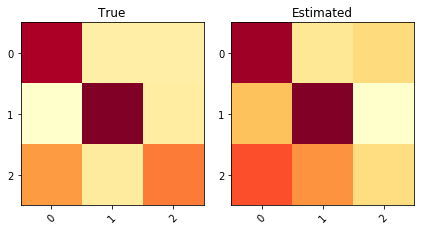

KL divergence: 0.2498	Pearson Correlation between diagonals: 0.9929


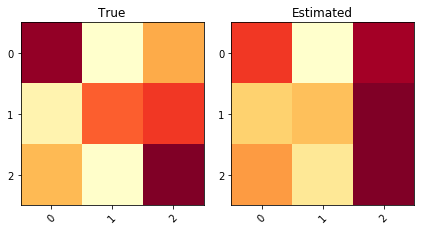

KL divergence: 0.1471	Pearson Correlation between diagonals: 0.9193


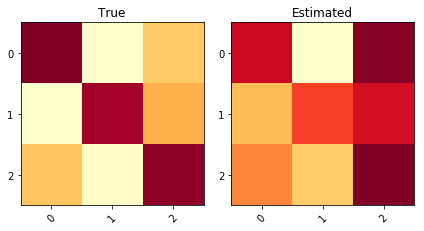

KL divergence: 0.1875	Pearson Correlation between diagonals: 0.5128
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.647131      0.647131   0.173115  0.0480427            0.831139
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.666667      0.666667
====  ======  ==========  ============


In [78]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


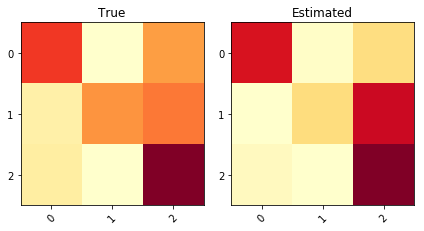

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.9282


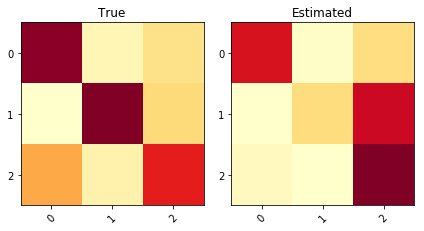

KL divergence: 0.7179	Pearson Correlation between diagonals: -0.7687


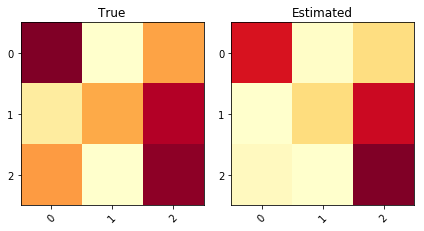

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9516


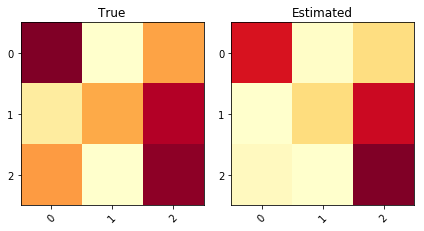

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9516


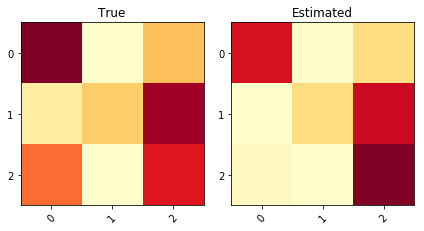

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.8299


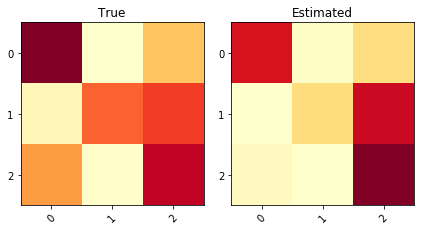

KL divergence: 0.3536	Pearson Correlation between diagonals: 0.8221


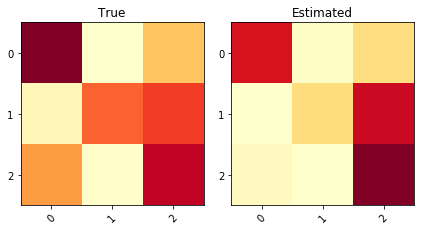

KL divergence: 0.3536	Pearson Correlation between diagonals: 0.8221


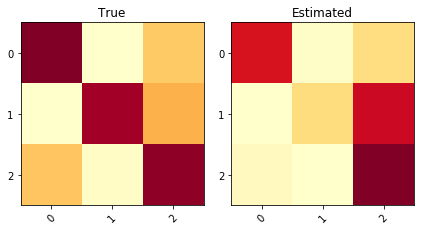

KL divergence: 0.5272	Pearson Correlation between diagonals: 0.7248


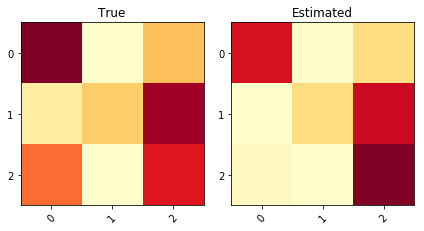

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.8299


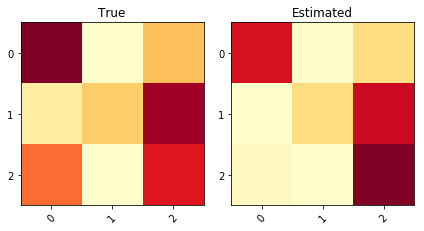

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.8299


KL divergence: 0.5071	Pearson Correlation between diagonals: 0.1559


KL divergence: 0.4933	Pearson Correlation between diagonals: 0.3007


KL divergence: 0.3354	Pearson Correlation between diagonals: 0.7023


KL divergence: 0.3203	Pearson Correlation between diagonals: 0.9849


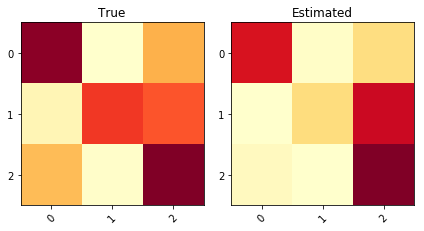

KL divergence: 0.3625	Pearson Correlation between diagonals: 0.9797
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.647131      0.647131   0.413559  0.0989776            0.657137
====  ======  ==========  ============  =========  =========  ==================


In [79]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


KL divergence: 0.2672	Pearson Correlation between diagonals: 0.6542


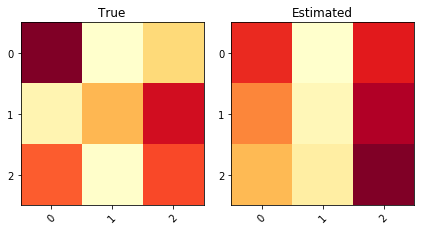

KL divergence: 0.2258	Pearson Correlation between diagonals: 0.6232


KL divergence: 0.2157	Pearson Correlation between diagonals: 0.9926


KL divergence: 0.2232	Pearson Correlation between diagonals: 0.9900


KL divergence: 0.2095	Pearson Correlation between diagonals: 0.9438


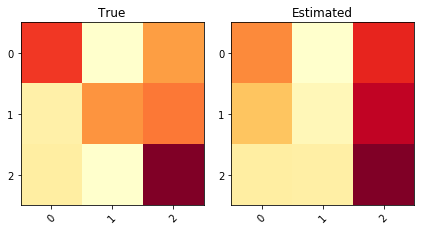

KL divergence: 0.2238	Pearson Correlation between diagonals: 0.9952


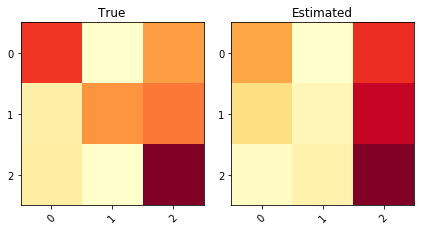

KL divergence: 0.2115	Pearson Correlation between diagonals: 0.9999


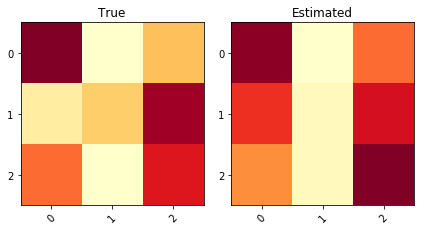

KL divergence: 0.1725	Pearson Correlation between diagonals: 0.9401


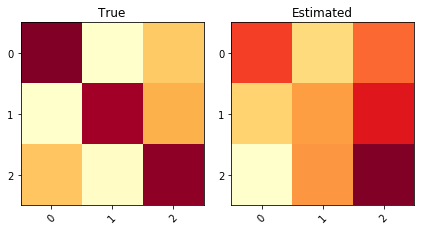

KL divergence: 0.2668	Pearson Correlation between diagonals: 0.4242


KL divergence: 0.2451	Pearson Correlation between diagonals: 0.6497


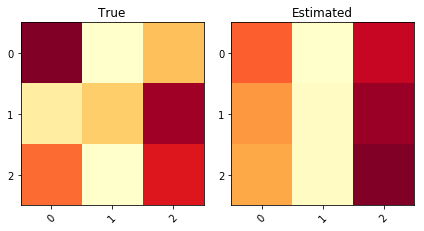

KL divergence: 0.2018	Pearson Correlation between diagonals: 0.7306


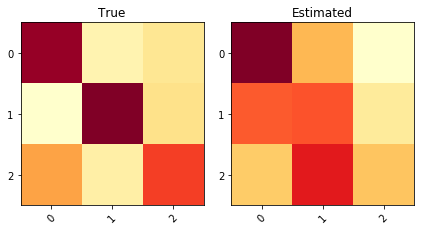

KL divergence: 0.3245	Pearson Correlation between diagonals: 0.7450


KL divergence: 0.2496	Pearson Correlation between diagonals: 0.7529


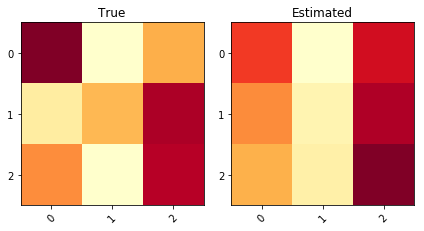

KL divergence: 0.1941	Pearson Correlation between diagonals: 0.8677


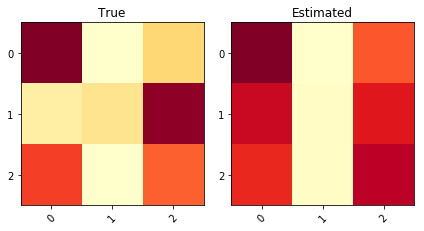

KL divergence: 0.1966	Pearson Correlation between diagonals: 0.9201
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.626781      0.626781   0.227775   0.062652            0.829569
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.649573      0.649573
====  ======  ==========  ============


In [80]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6350


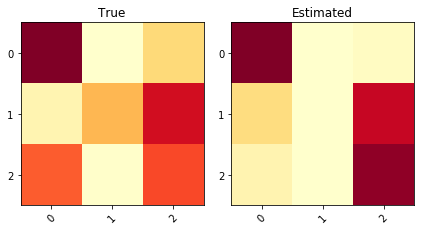

KL divergence: 1.7163	Pearson Correlation between diagonals: 0.8441


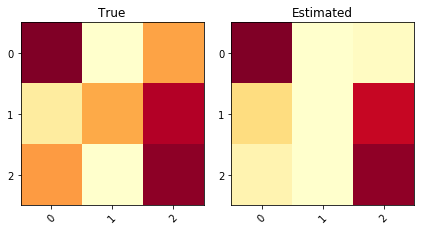

KL divergence: 1.5122	Pearson Correlation between diagonals: 0.9999


KL divergence: 6.0199	Pearson Correlation between diagonals: -0.6350


KL divergence: 2.9290	Pearson Correlation between diagonals: 0.9978


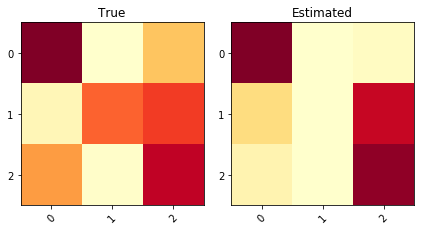

KL divergence: 2.5519	Pearson Correlation between diagonals: 0.9533


KL divergence: 4.0552	Pearson Correlation between diagonals: 0.8955


KL divergence: 3.2077	Pearson Correlation between diagonals: 0.7739


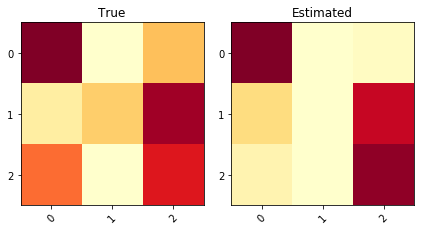

KL divergence: 1.1533	Pearson Correlation between diagonals: 0.9574


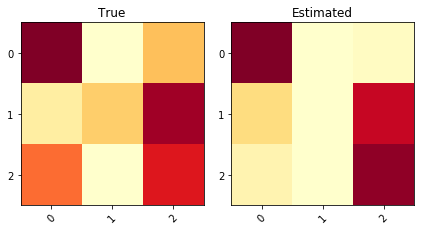

KL divergence: 1.1533	Pearson Correlation between diagonals: 0.9574


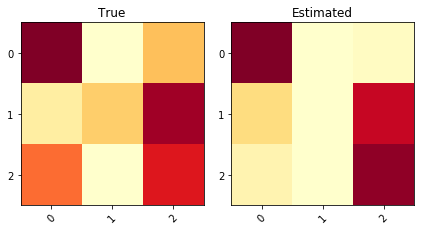

KL divergence: 1.1533	Pearson Correlation between diagonals: 0.9574


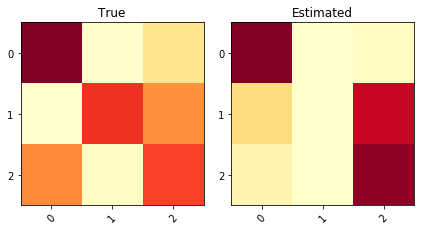

KL divergence: 3.4657	Pearson Correlation between diagonals: 0.4399


KL divergence: 2.4550	Pearson Correlation between diagonals: 0.9922


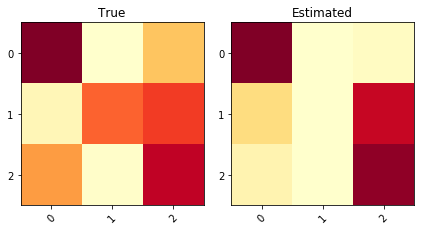

KL divergence: 2.5519	Pearson Correlation between diagonals: 0.9533


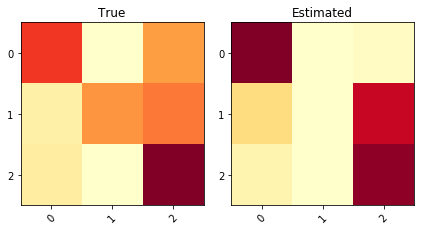

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.7775
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.626781      0.626781    2.79507   0.129262            0.705212
====  ======  ==========  ============  =========  =========  ==================


In [81]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


KL divergence: 0.2083	Pearson Correlation between diagonals: -0.6699


KL divergence: 0.1479	Pearson Correlation between diagonals: 0.9335


KL divergence: 0.0164	Pearson Correlation between diagonals: 0.9801


KL divergence: 0.0187	Pearson Correlation between diagonals: 0.5138


KL divergence: 0.0119	Pearson Correlation between diagonals: 0.9876


KL divergence: 0.0112	Pearson Correlation between diagonals: 1.0000


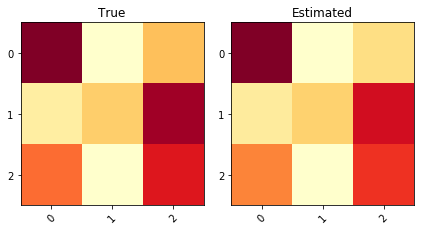

KL divergence: 0.0070	Pearson Correlation between diagonals: 0.9942


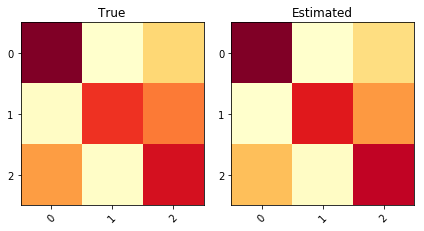

KL divergence: 0.0084	Pearson Correlation between diagonals: 0.9944


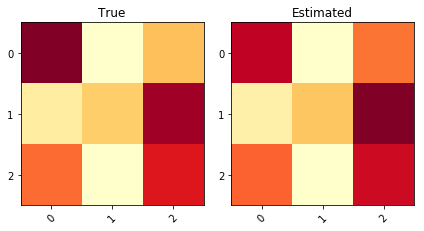

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9657


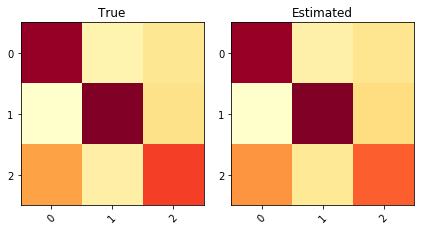

KL divergence: 0.0057	Pearson Correlation between diagonals: 0.9999


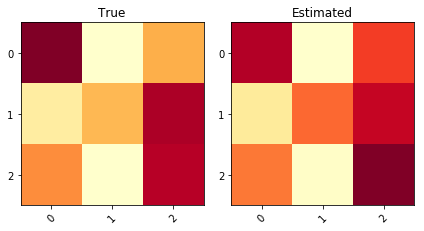

KL divergence: 0.0294	Pearson Correlation between diagonals: 0.9164


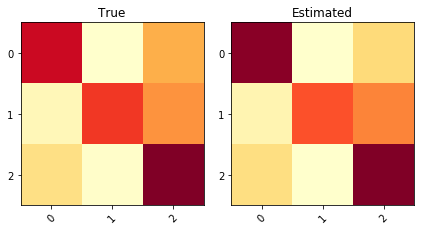

KL divergence: 0.0203	Pearson Correlation between diagonals: 0.8714


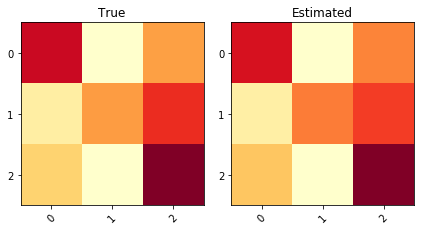

KL divergence: 0.0044	Pearson Correlation between diagonals: 0.9874


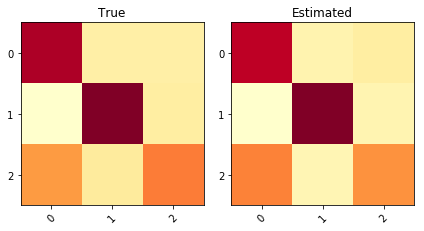

KL divergence: 0.0134	Pearson Correlation between diagonals: 0.9987


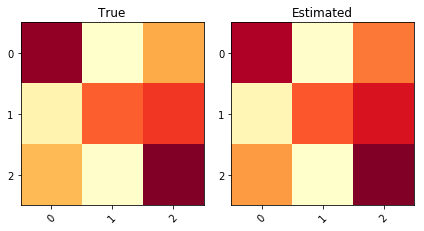

KL divergence: 0.0109	Pearson Correlation between diagonals: 0.9891
A result
 ====  ======  ==========  ============  =========  ==========  ==================
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  ==========  ==================
   0  Global    0.908425      0.908425  0.0239754  0.00338395            0.880801
====  ======  ==========  ============  =========  ==========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.915751      0.915751
====  ======  ==========  ============


In [82]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


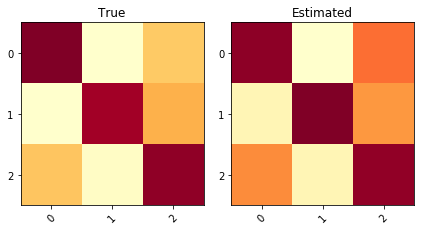

KL divergence: 0.0225	Pearson Correlation between diagonals: -0.8060


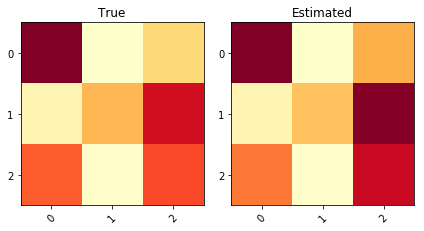

KL divergence: 0.0136	Pearson Correlation between diagonals: 0.9370


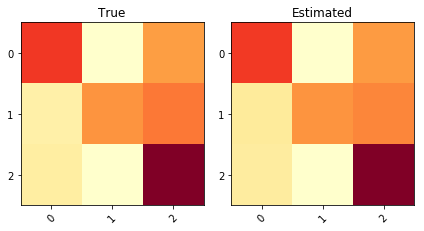

KL divergence: 0.0110	Pearson Correlation between diagonals: 1.0000


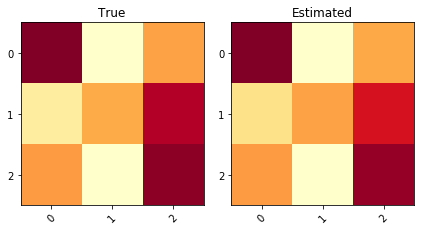

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9996


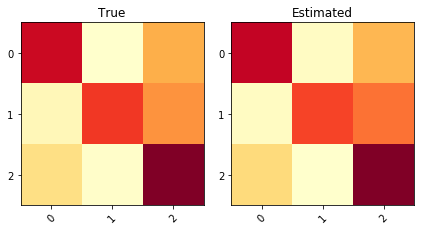

KL divergence: 0.0060	Pearson Correlation between diagonals: 0.9922


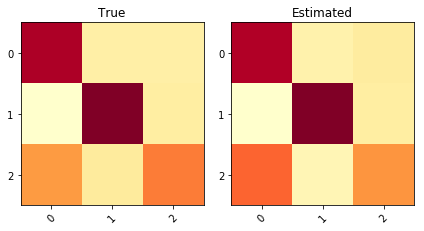

KL divergence: 0.0166	Pearson Correlation between diagonals: 1.0000


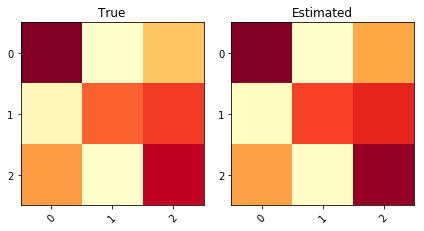

KL divergence: 0.0089	Pearson Correlation between diagonals: 0.9777


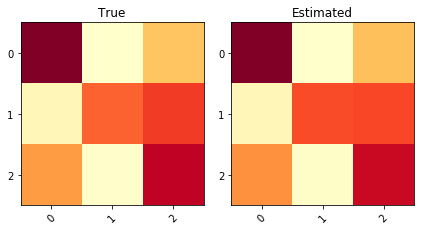

KL divergence: 0.0026	Pearson Correlation between diagonals: 0.9911


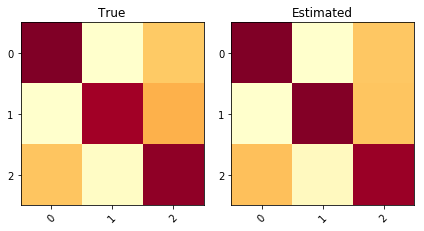

KL divergence: 0.0046	Pearson Correlation between diagonals: 0.1420


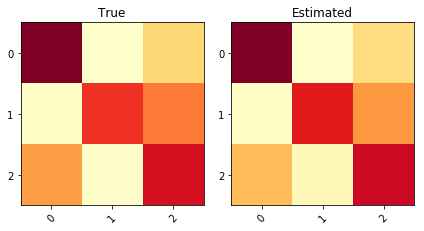

KL divergence: 0.0124	Pearson Correlation between diagonals: 0.9999


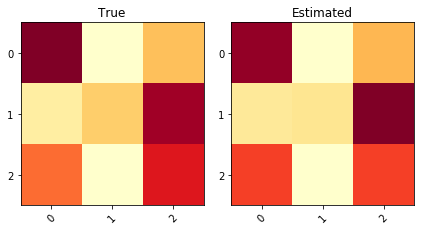

KL divergence: 0.0211	Pearson Correlation between diagonals: 0.9977


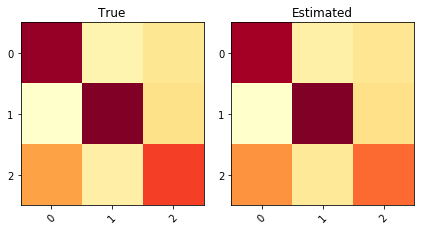

KL divergence: 0.0097	Pearson Correlation between diagonals: 0.9997


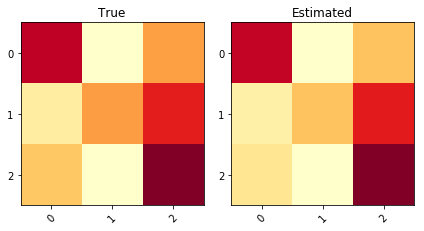

KL divergence: 0.0234	Pearson Correlation between diagonals: 0.9997


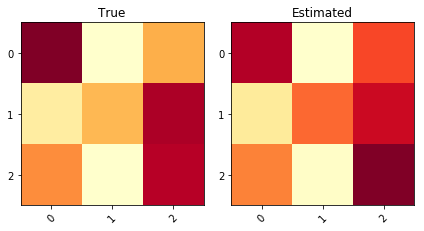

KL divergence: 0.0364	Pearson Correlation between diagonals: 0.9178


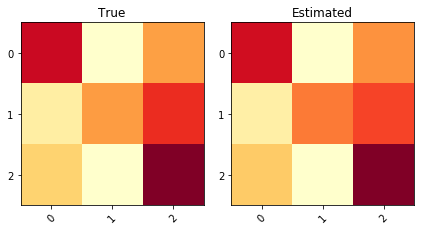

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9931
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.916972      0.916972   0.014434  0.0039898            0.873853       0.0697904
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.608924                0.834809
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.924298 

In [83]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


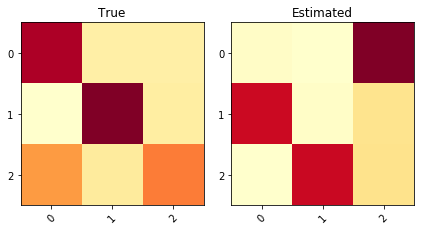

KL divergence: 2.8601	Pearson Correlation between diagonals: -0.9856


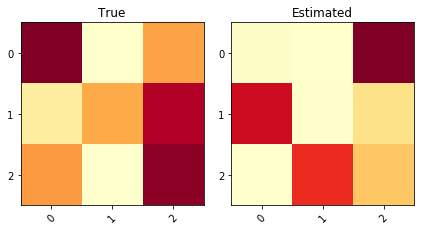

KL divergence: 1.9995	Pearson Correlation between diagonals: 0.4847


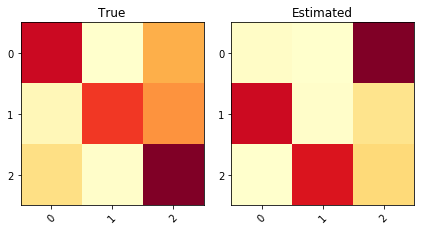

KL divergence: 1.9191	Pearson Correlation between diagonals: 0.8954


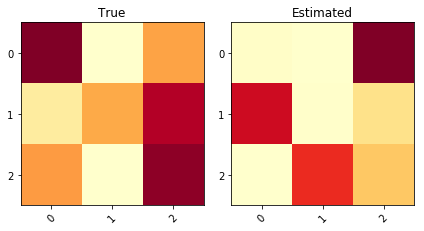

KL divergence: 1.9986	Pearson Correlation between diagonals: 0.4847


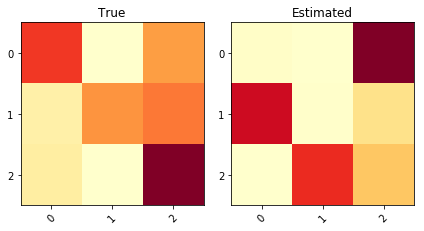

KL divergence: 1.7263	Pearson Correlation between diagonals: 0.9319


KL divergence: 2.1838	Pearson Correlation between diagonals: 0.2246


KL divergence: 1.7726	Pearson Correlation between diagonals: -0.0334


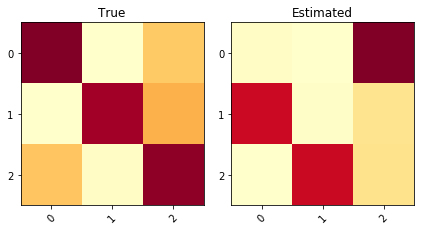

KL divergence: 2.1615	Pearson Correlation between diagonals: 0.0567


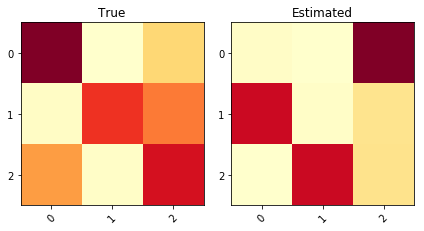

KL divergence: 2.1876	Pearson Correlation between diagonals: -0.1670


KL divergence: 2.1842	Pearson Correlation between diagonals: 0.2246


KL divergence: 2.1841	Pearson Correlation between diagonals: 0.2246


KL divergence: 2.8278	Pearson Correlation between diagonals: -0.4323


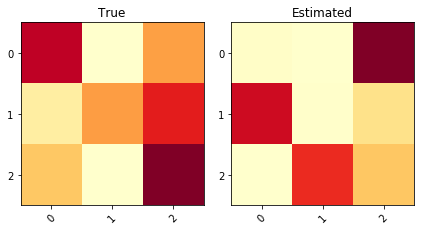

KL divergence: 1.8743	Pearson Correlation between diagonals: 0.7039


KL divergence: 2.0695	Pearson Correlation between diagonals: 0.3748


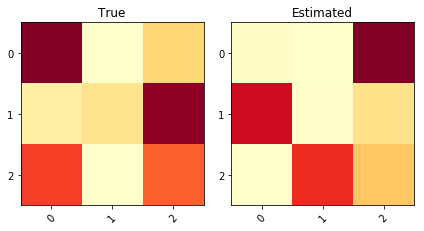

KL divergence: 2.3981	Pearson Correlation between diagonals: 0.0263
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.01221       0.01221    2.09572   0.347804            0.299196       0.0654801
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.631165                0.795329
====  =======================  ======================
Test


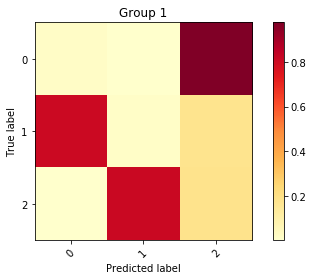

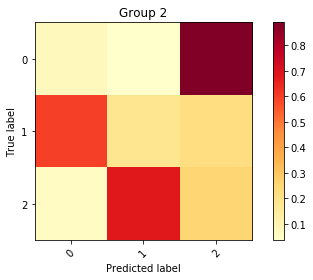

Inertia: 0.02179786000245561
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.672295       67   0.415555    0.108338     3.39952       0.20002   -0.224995    0.666667      0.666667
   1         1  0.307081       30   0.389777    0.0732675    3.20858       0.167576  -0.260066    0.837607      0.837607
   2         2  0.0206241       2   0.71714     0.170642     1.88952       0.339556  -0.162691    0.716728      0.716728
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [84]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


KL divergence: 0.4402	Pearson Correlation between diagonals: -0.4016


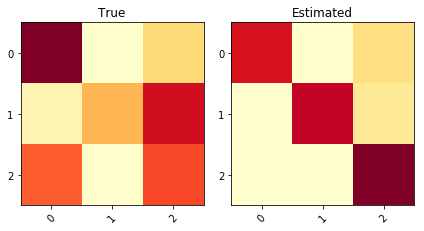

KL divergence: 1.0900	Pearson Correlation between diagonals: -0.3683


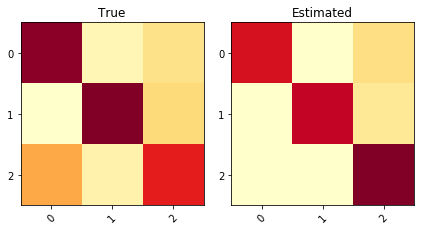

KL divergence: 0.6523	Pearson Correlation between diagonals: -0.9335


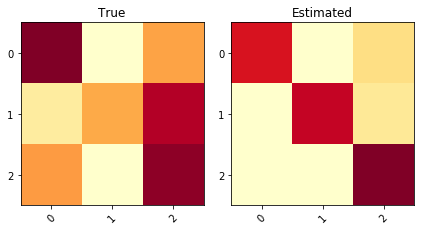

KL divergence: 0.8011	Pearson Correlation between diagonals: 0.1861


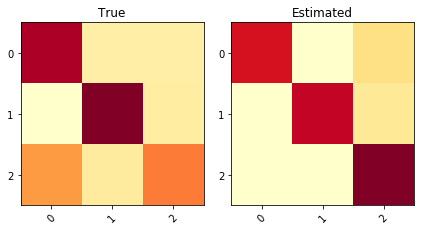

KL divergence: 0.8702	Pearson Correlation between diagonals: -0.8909


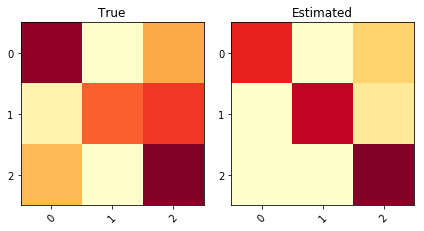

KL divergence: 0.5176	Pearson Correlation between diagonals: 0.1156


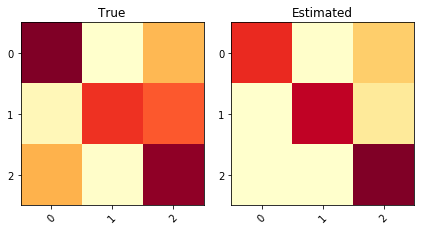

KL divergence: 0.5054	Pearson Correlation between diagonals: -0.1123


KL divergence: 0.8071	Pearson Correlation between diagonals: 0.2004


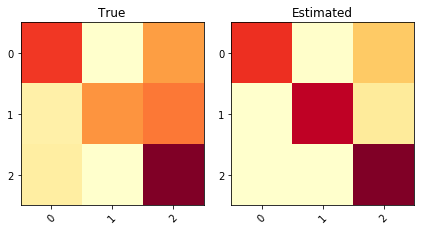

KL divergence: 0.3046	Pearson Correlation between diagonals: 0.5574


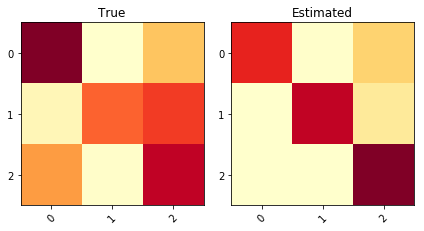

KL divergence: 0.6484	Pearson Correlation between diagonals: -0.3106


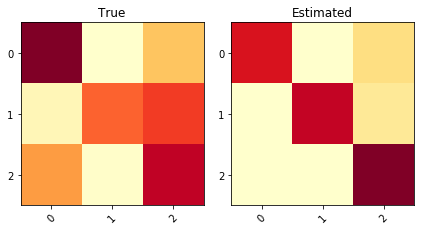

KL divergence: 0.7222	Pearson Correlation between diagonals: -0.1213


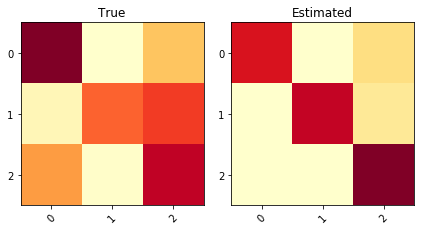

KL divergence: 0.7216	Pearson Correlation between diagonals: -0.1227


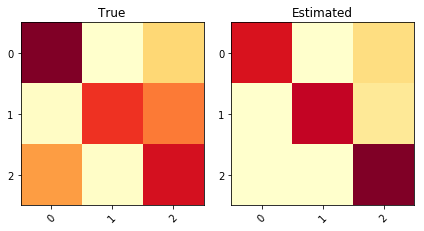

KL divergence: 0.7057	Pearson Correlation between diagonals: -0.4890


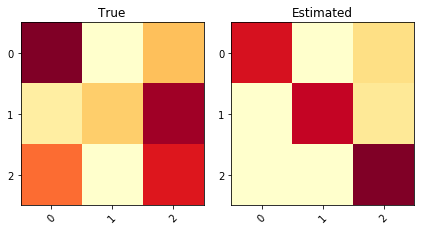

KL divergence: 1.0741	Pearson Correlation between diagonals: -0.0767


KL divergence: 1.0255	Pearson Correlation between diagonals: -0.1829
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.892145      0.892145   0.625761  0.0778904          -0.0133487       0.0810086
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.604821                0.801008
====  =======================  ======================
Test


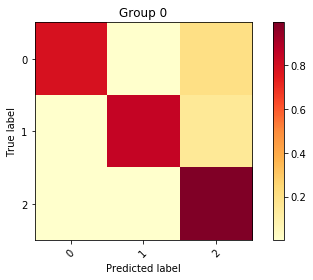

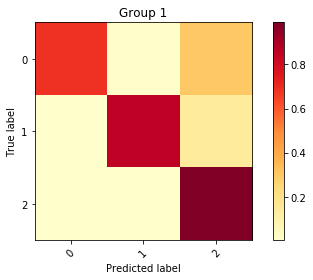

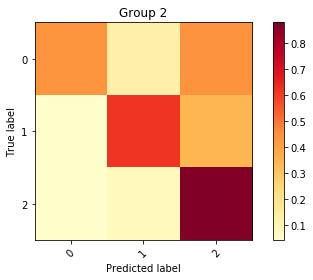

Inertia: 0.03199105224727342
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.681221      68   0.333287     0.877428   0.135575       0.934194   0.544095    0.698413      0.698413
   1         1  0.299901      29   0.382563     0.845276   0.179096       0.914357   0.511943    0.703297      0.703297
   2         2  0.018878       1   0.741914     0.643152   0.482488       0.781991   0.309818    0.333333      0.333333
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [85]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


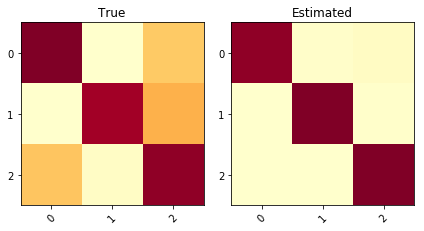

KL divergence: 0.7976	Pearson Correlation between diagonals: -0.8199


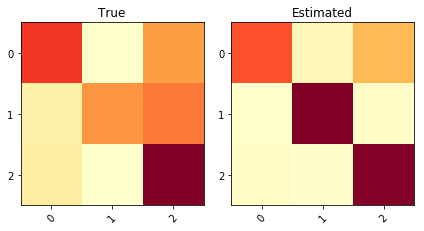

KL divergence: 0.5294	Pearson Correlation between diagonals: 0.1014


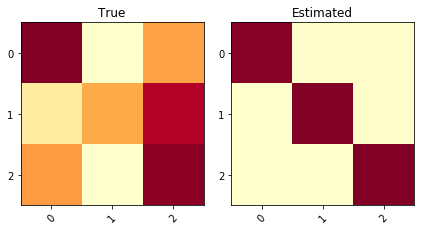

KL divergence: 1.6546	Pearson Correlation between diagonals: -0.3951


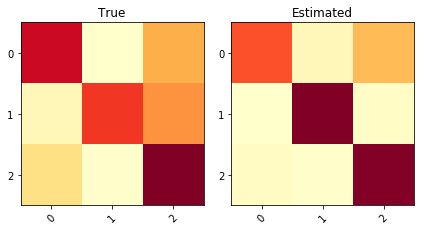

KL divergence: 0.4173	Pearson Correlation between diagonals: 0.0119


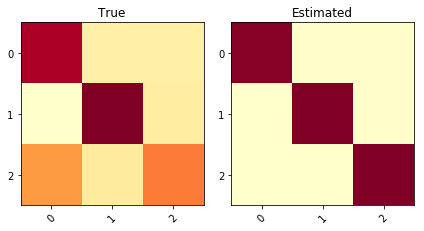

KL divergence: 0.8900	Pearson Correlation between diagonals: -0.4632


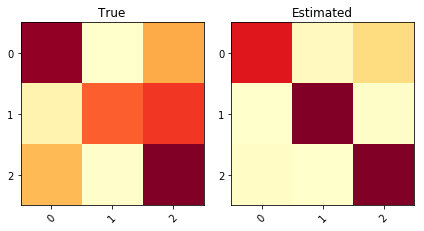

KL divergence: 0.7063	Pearson Correlation between diagonals: -0.4344


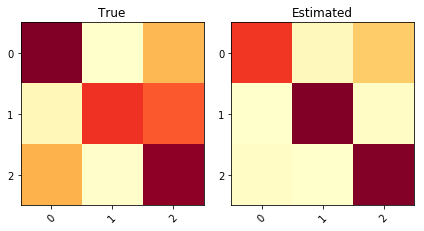

KL divergence: 0.5846	Pearson Correlation between diagonals: -0.6002


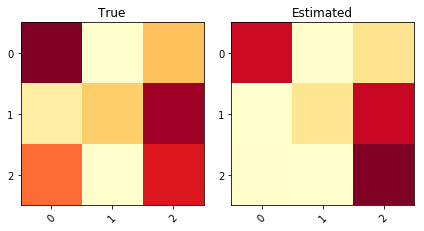

KL divergence: 0.4738	Pearson Correlation between diagonals: 0.8641


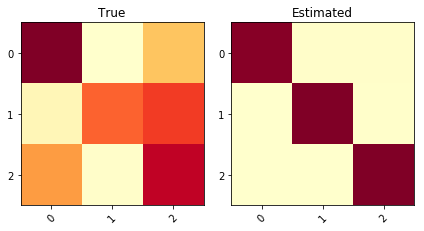

KL divergence: 1.3803	Pearson Correlation between diagonals: -0.6508


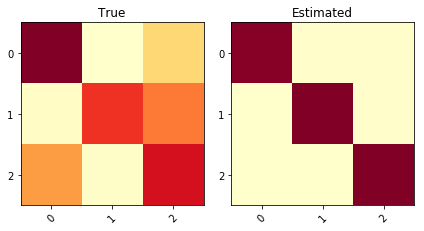

KL divergence: 1.2422	Pearson Correlation between diagonals: -0.8866


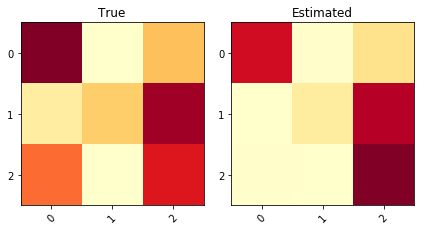

KL divergence: 0.4750	Pearson Correlation between diagonals: 0.8646


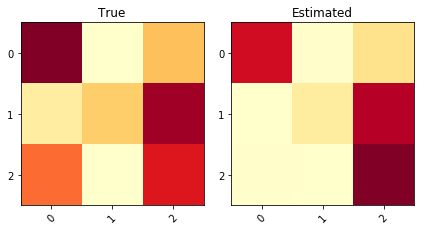

KL divergence: 0.4750	Pearson Correlation between diagonals: 0.8646


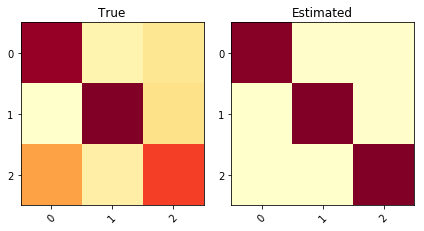

KL divergence: 0.8717	Pearson Correlation between diagonals: -0.5106


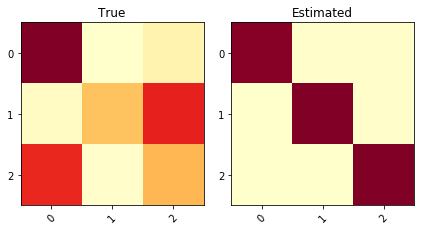

KL divergence: 2.0949	Pearson Correlation between diagonals: -0.9795


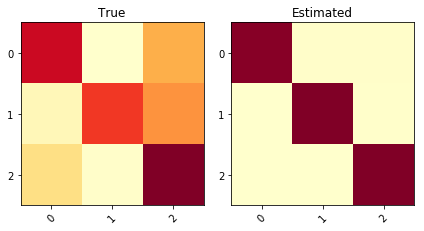

KL divergence: 1.0162	Pearson Correlation between diagonals: 0.1806
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.908018      0.908018   0.780937  0.0978211           -0.121898       0.0580528
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.614287                0.800719
====  =======================  ======================
Test


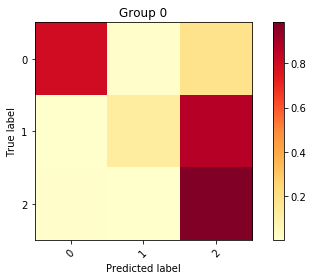

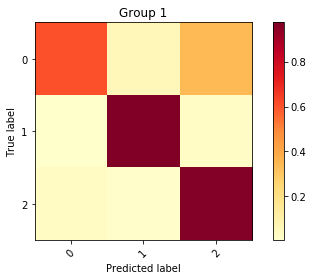

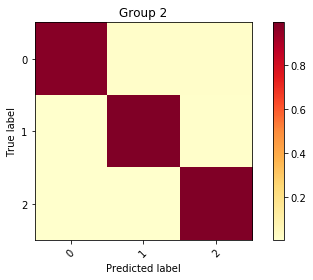

Inertia: 0.1267139259725809
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.266872      26  0.348904      0.636174  0.770734        0.722614   0.302841    0.64591       0.64591
   1         1  0.216271      21  0.375464      0.848153  0.188029        0.912148   0.514819    0.74359       0.74359
   2         2  0.516857      51  0.0660778     0.988866  0.0112224       0.994402   0.655532    0.918193      0.918193
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ==========

In [86]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [101]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7826617826617827


*** Soft-Majority (Train with softMV) ***
Train


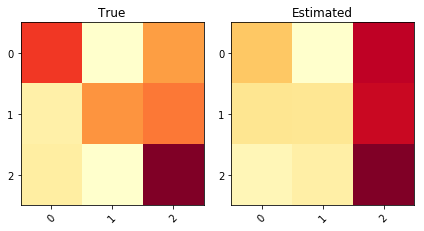

KL divergence: 0.2030	Pearson Correlation between diagonals: 0.9713


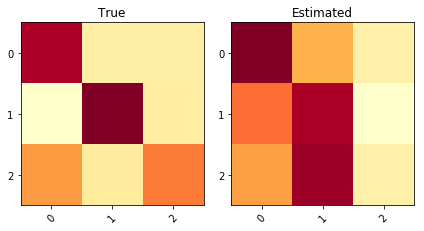

KL divergence: 0.3544	Pearson Correlation between diagonals: 0.9606


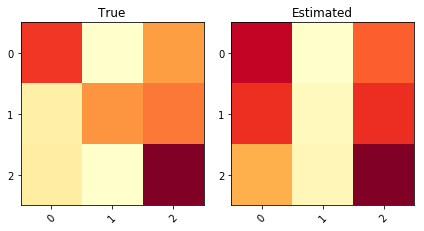

KL divergence: 0.2796	Pearson Correlation between diagonals: 0.8761


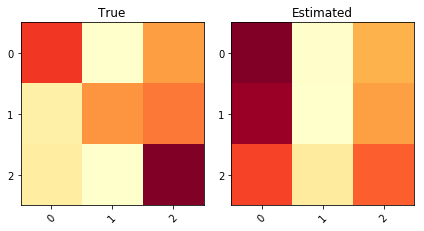

KL divergence: 0.5013	Pearson Correlation between diagonals: 0.4817


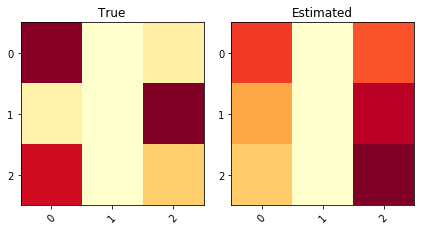

KL divergence: 0.3630	Pearson Correlation between diagonals: 0.4618


KL divergence: 0.2915	Pearson Correlation between diagonals: 0.9966


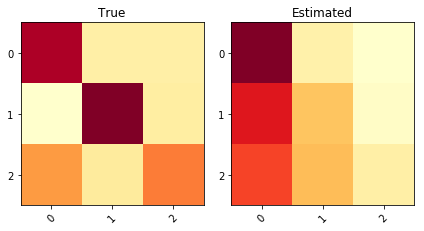

KL divergence: 0.4239	Pearson Correlation between diagonals: 0.5247


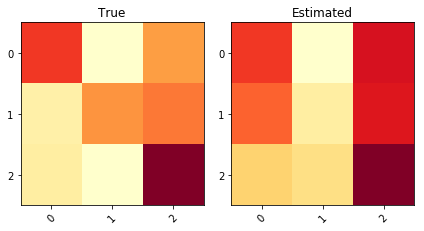

KL divergence: 0.2506	Pearson Correlation between diagonals: 0.9602


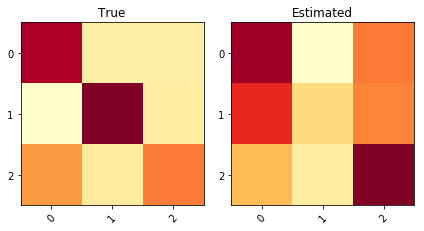

KL divergence: 0.4487	Pearson Correlation between diagonals: -0.7150


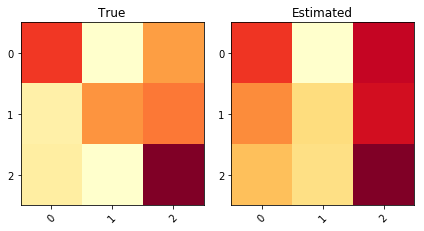

KL divergence: 0.2180	Pearson Correlation between diagonals: 0.9724


KL divergence: 0.2468	Pearson Correlation between diagonals: 0.8666


KL divergence: 0.3374	Pearson Correlation between diagonals: 0.2217


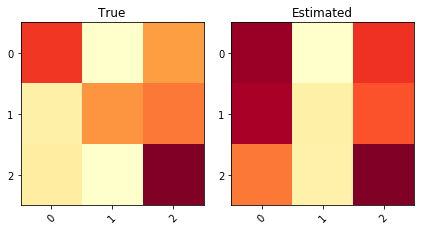

KL divergence: 0.3026	Pearson Correlation between diagonals: 0.8295


KL divergence: 0.2316	Pearson Correlation between diagonals: 0.9342


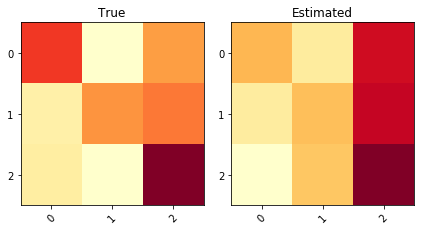

KL divergence: 0.2279	Pearson Correlation between diagonals: 0.9350
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.599512      0.599512    0.32559   0.080289            0.822367
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.619048      0.619048
====  ======  ==========  ============


In [102]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7965


KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


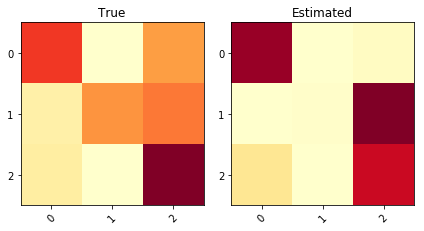

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


KL divergence: 1.3479	Pearson Correlation between diagonals: -0.5681


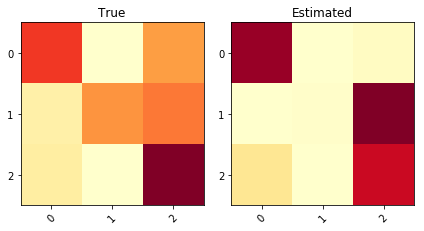

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


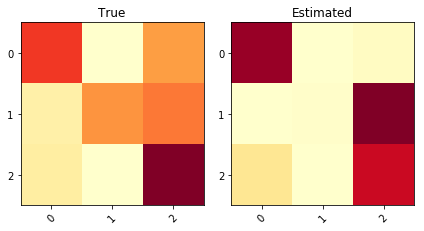

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


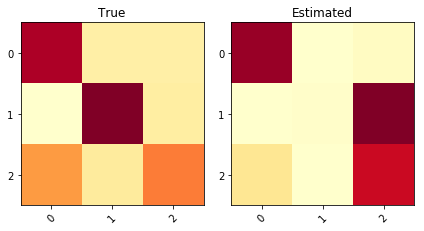

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.5681


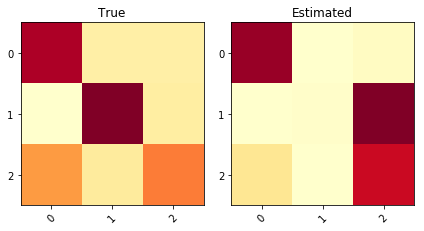

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.5681


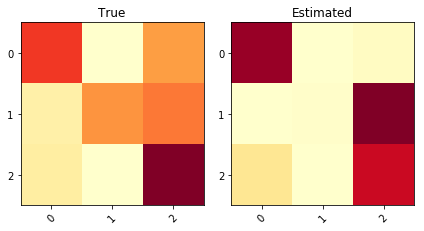

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


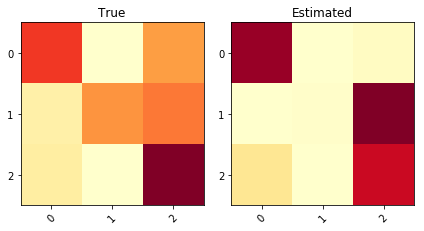

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


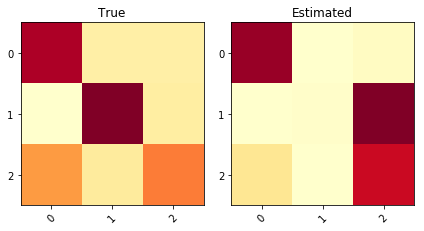

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.5681


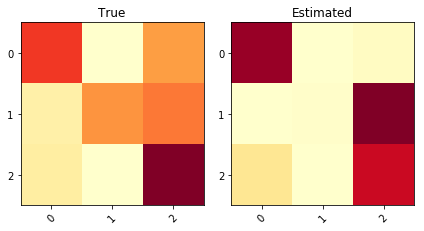

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221


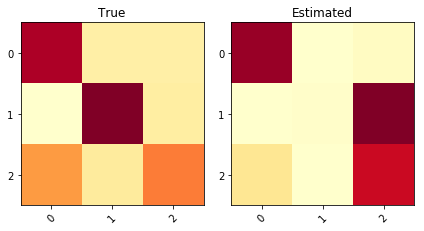

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.5681


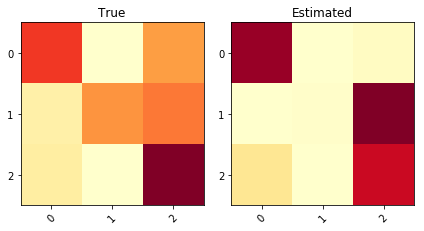

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7221
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.599512      0.599512   0.517084  0.0961229            0.425925
====  ======  ==========  ============  =========  =========  ==================


In [103]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


KL divergence: 0.1346	Pearson Correlation between diagonals: 0.8187


KL divergence: 0.1104	Pearson Correlation between diagonals: 0.9837


KL divergence: 0.1163	Pearson Correlation between diagonals: 0.9933


KL divergence: 0.1428	Pearson Correlation between diagonals: 0.9187


KL divergence: 0.3511	Pearson Correlation between diagonals: 0.6671


KL divergence: 0.2662	Pearson Correlation between diagonals: 0.9703


KL divergence: 0.1885	Pearson Correlation between diagonals: 0.8902


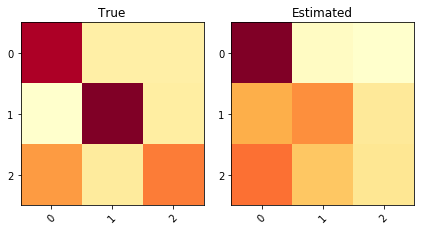

KL divergence: 0.2864	Pearson Correlation between diagonals: 0.6677


KL divergence: 0.1477	Pearson Correlation between diagonals: 0.9996


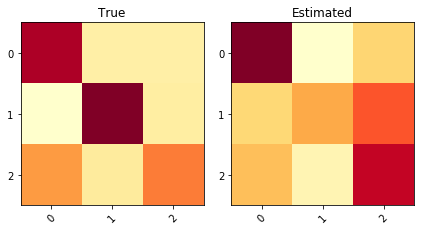

KL divergence: 0.2979	Pearson Correlation between diagonals: -0.4608


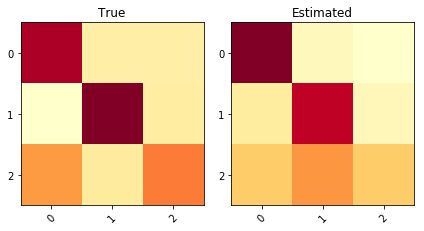

KL divergence: 0.1763	Pearson Correlation between diagonals: 0.9318


KL divergence: 0.1358	Pearson Correlation between diagonals: 0.9388


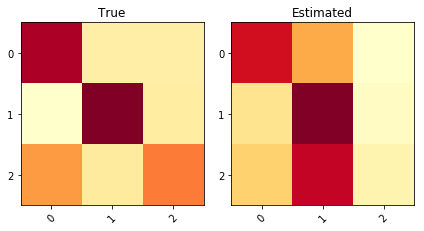

KL divergence: 0.4241	Pearson Correlation between diagonals: 1.0000


KL divergence: 0.3089	Pearson Correlation between diagonals: 0.8490


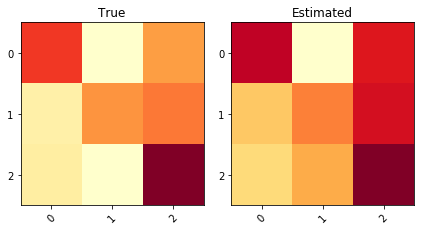

KL divergence: 0.1528	Pearson Correlation between diagonals: 0.9358
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.62963       0.62963   0.217562  0.0520236            0.833282
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.654457      0.654457
====  ======  ==========  ============


In [104]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


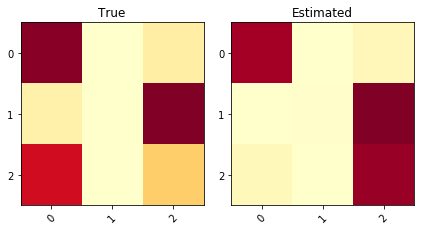

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


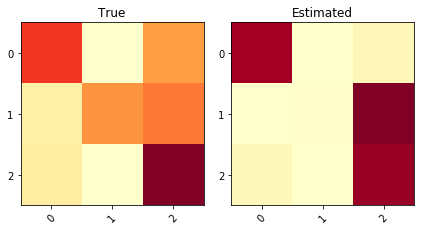

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


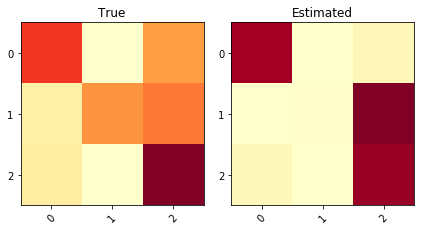

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


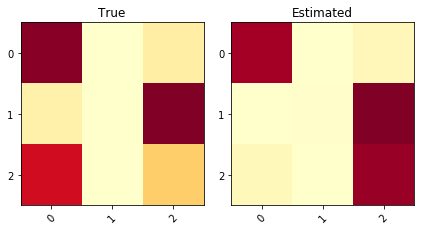

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


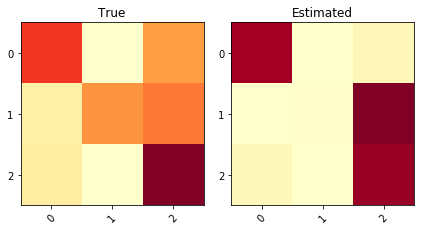

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


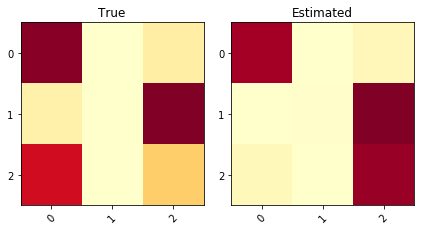

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


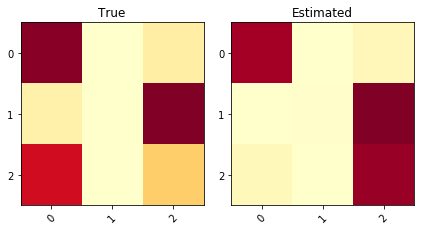

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7090


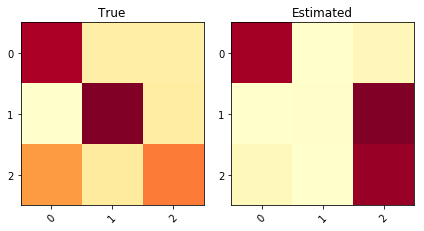

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


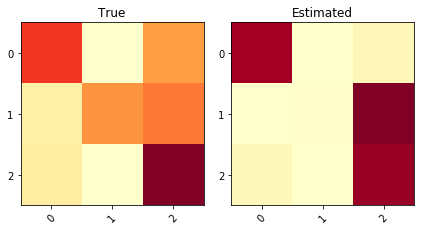

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


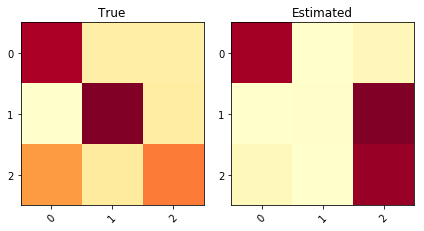

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


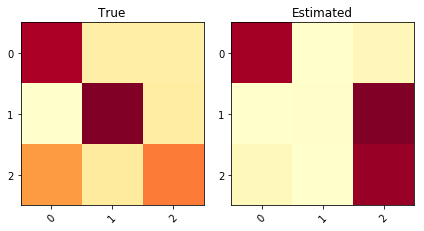

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


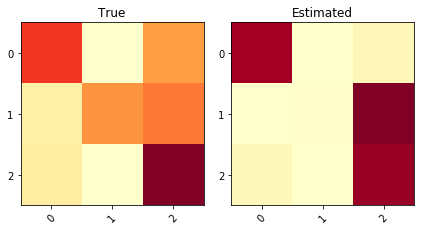

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


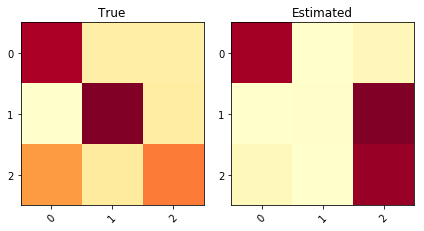

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725


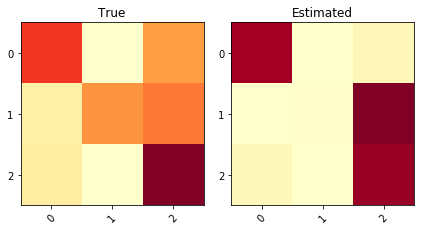

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8077


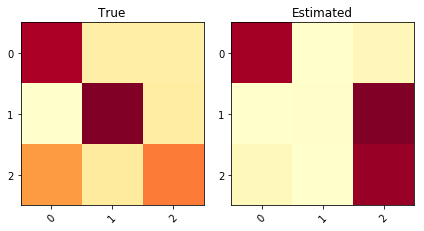

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6725
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.62963       0.62963   0.517084  0.0961229            0.428152
====  ======  ==========  ============  =========  =========  ==================


In [105]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


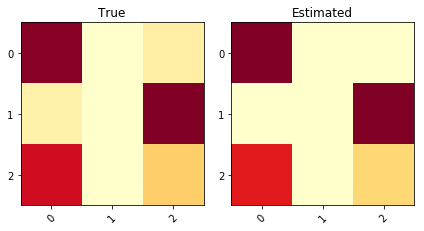

KL divergence: 0.8179	Pearson Correlation between diagonals: 0.9991


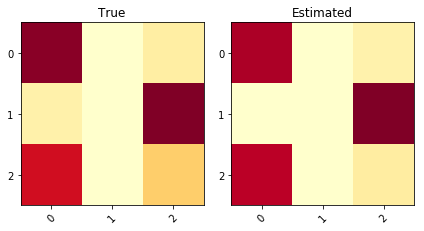

KL divergence: 0.3867	Pearson Correlation between diagonals: 0.9876


KL divergence: 0.5430	Pearson Correlation between diagonals: 0.7008


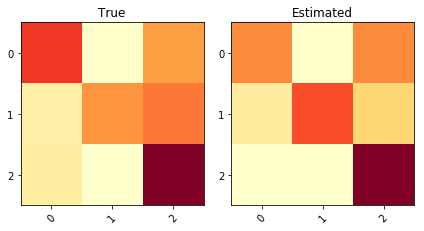

KL divergence: 0.5037	Pearson Correlation between diagonals: 0.8028


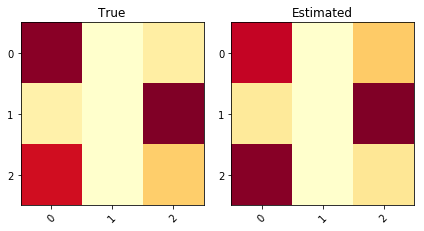

KL divergence: 0.0432	Pearson Correlation between diagonals: 0.9941


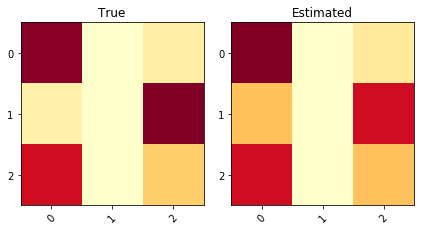

KL divergence: 0.0419	Pearson Correlation between diagonals: 0.9992


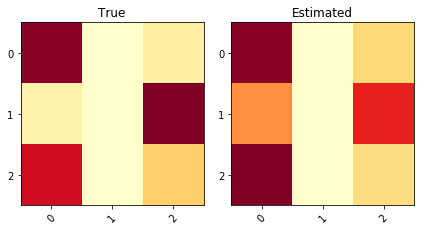

KL divergence: 0.1010	Pearson Correlation between diagonals: 0.9978


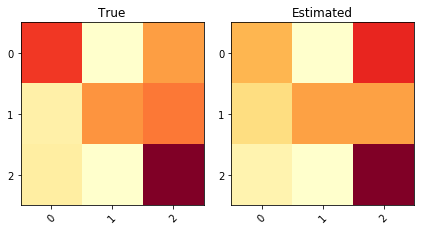

KL divergence: 0.0692	Pearson Correlation between diagonals: 0.8778


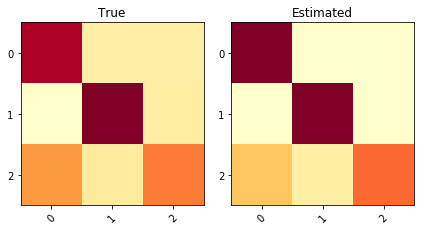

KL divergence: 1.2776	Pearson Correlation between diagonals: 0.9813


KL divergence: 0.0272	Pearson Correlation between diagonals: 0.9943


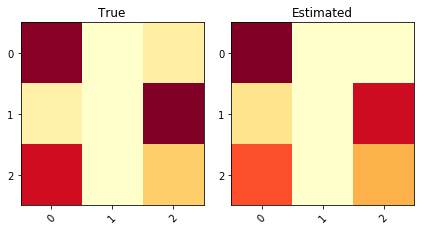

KL divergence: 0.4402	Pearson Correlation between diagonals: 0.9954


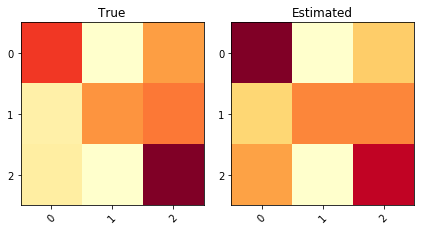

KL divergence: 0.0872	Pearson Correlation between diagonals: 0.5889


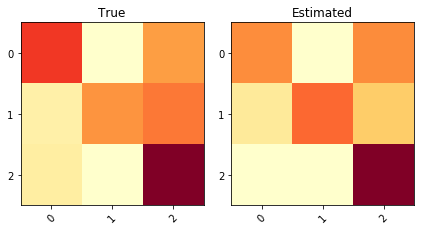

KL divergence: 0.4909	Pearson Correlation between diagonals: 0.8625


KL divergence: 0.4077	Pearson Correlation between diagonals: 0.9155


KL divergence: 0.4934	Pearson Correlation between diagonals: 0.9752
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.934473      0.934473   0.701537  0.0317218            0.854718
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.942613      0.942613
====  ======  ==========  ============


In [106]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


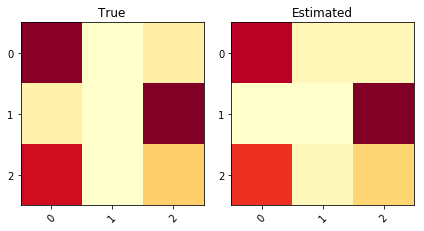

KL divergence: 0.0884	Pearson Correlation between diagonals: 1.0000


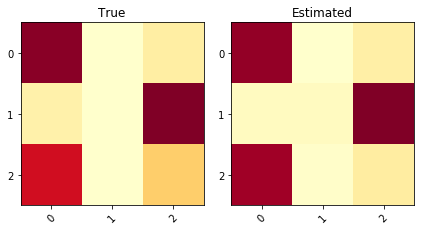

KL divergence: 0.1031	Pearson Correlation between diagonals: 0.9812


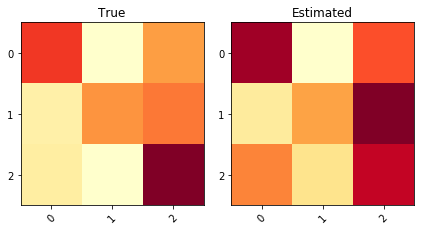

KL divergence: 0.1761	Pearson Correlation between diagonals: 0.7010


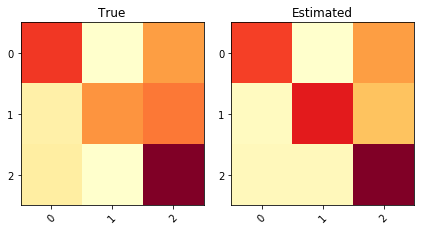

KL divergence: 0.0927	Pearson Correlation between diagonals: 0.7973


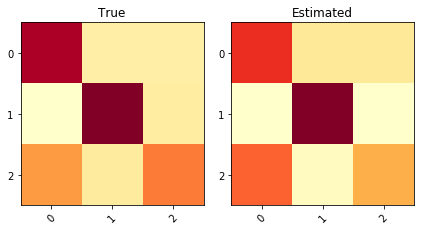

KL divergence: 0.0790	Pearson Correlation between diagonals: 0.9547


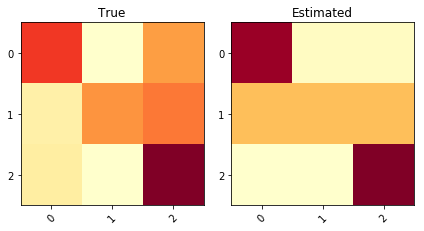

KL divergence: 0.2013	Pearson Correlation between diagonals: 0.8395


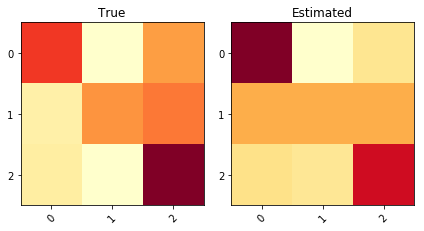

KL divergence: 0.2145	Pearson Correlation between diagonals: 0.5824


KL divergence: 0.1342	Pearson Correlation between diagonals: 0.9953


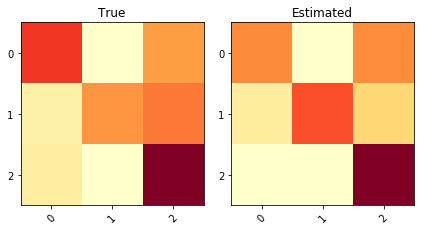

KL divergence: 0.1077	Pearson Correlation between diagonals: 0.8032


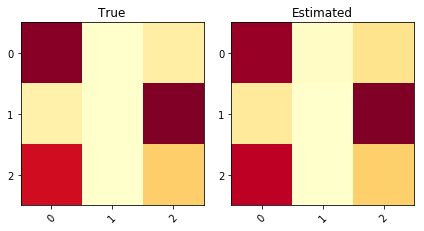

KL divergence: 0.1333	Pearson Correlation between diagonals: 1.0000


KL divergence: 0.1503	Pearson Correlation between diagonals: 0.5272


KL divergence: 0.1745	Pearson Correlation between diagonals: 0.9995


KL divergence: 0.2152	Pearson Correlation between diagonals: 0.9908


KL divergence: 0.0926	Pearson Correlation between diagonals: 0.8713


KL divergence: 0.0508	Pearson Correlation between diagonals: 0.9859
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.906797      0.906797   0.124096  0.0370803            0.863744        0.164696
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.687609                0.788936
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.907204 

In [107]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


KL divergence: 1.5387	Pearson Correlation between diagonals: 0.4302


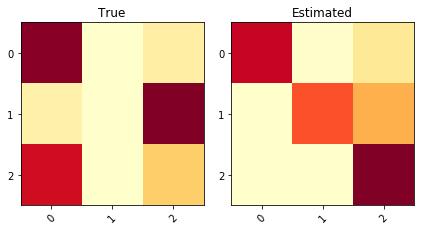

KL divergence: 1.5648	Pearson Correlation between diagonals: 0.3863


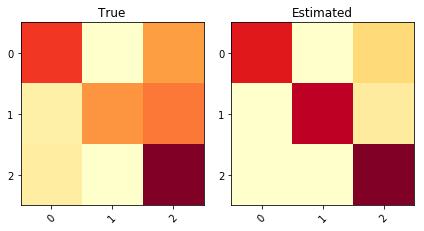

KL divergence: 0.3312	Pearson Correlation between diagonals: 0.6437


KL divergence: 0.2664	Pearson Correlation between diagonals: 0.9371


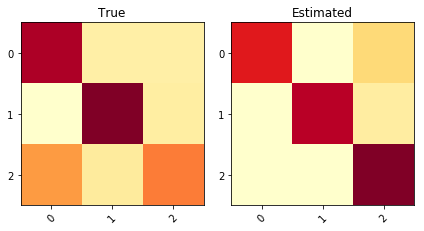

KL divergence: 0.7769	Pearson Correlation between diagonals: -0.7475


KL divergence: 0.2633	Pearson Correlation between diagonals: 0.9490


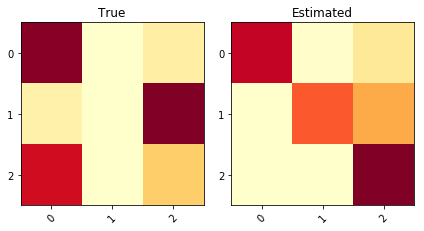

KL divergence: 1.5460	Pearson Correlation between diagonals: 0.4182


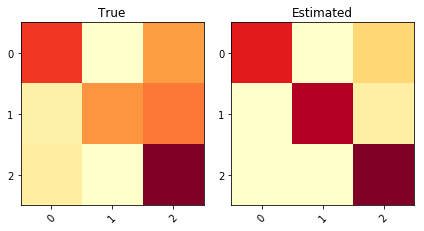

KL divergence: 0.3531	Pearson Correlation between diagonals: 0.5569


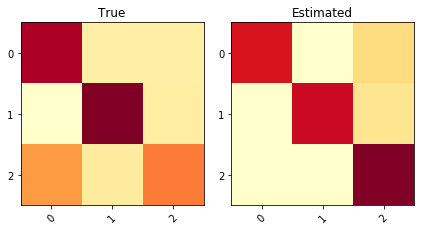

KL divergence: 0.7624	Pearson Correlation between diagonals: -0.9197


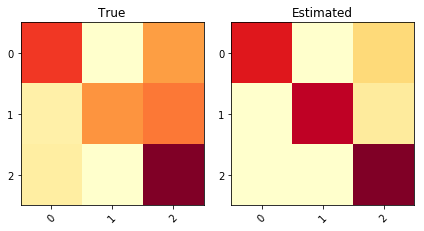

KL divergence: 0.3300	Pearson Correlation between diagonals: 0.6517


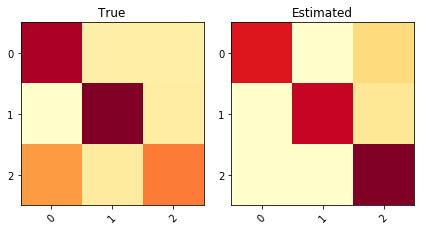

KL divergence: 0.7696	Pearson Correlation between diagonals: -0.8610


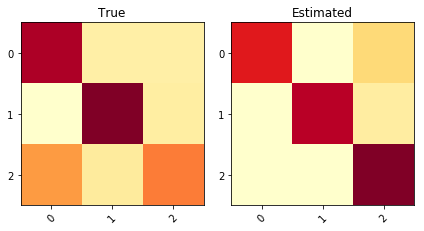

KL divergence: 0.7773	Pearson Correlation between diagonals: -0.7465


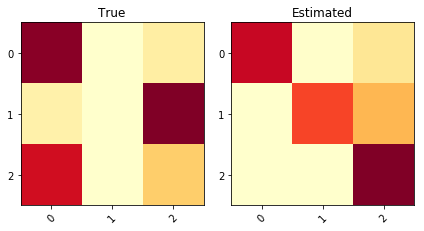

KL divergence: 1.5947	Pearson Correlation between diagonals: 0.3300


KL divergence: 0.3093	Pearson Correlation between diagonals: 0.7440


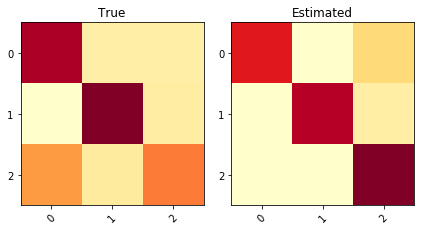

KL divergence: 0.7781	Pearson Correlation between diagonals: -0.7264
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.875865      0.875865   0.698133  0.0969864            0.285046        0.168783
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.626833                0.777296
====  =======================  ======================
Test


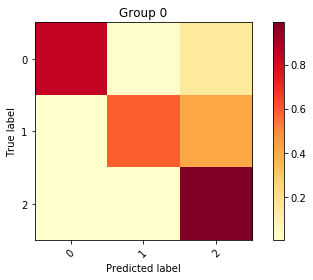

Inertia: 0.014887696379446425
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.252395     504   0.405633     0.809841   0.233687       0.890554   0.476508    0.652015      0.652015
   1         1  0.339496     678   0.338549     0.878089   0.135496       0.934343   0.544756    0.715507      0.715507
   2         2  0.408108     816   0.33943      0.870726   0.146297       0.929525   0.537393    0.735043      0.735043
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [108]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


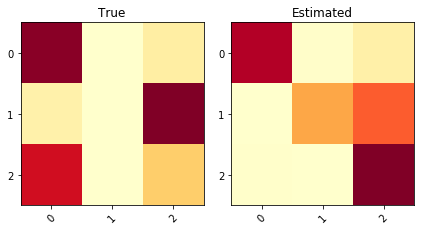

KL divergence: 1.1368	Pearson Correlation between diagonals: 0.5946


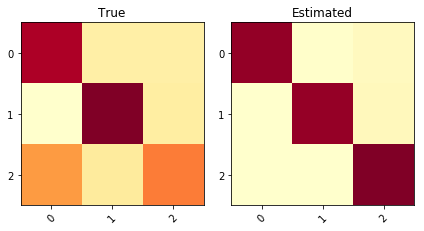

KL divergence: 0.7454	Pearson Correlation between diagonals: -0.9921


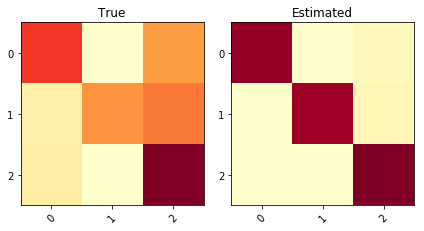

KL divergence: 0.5896	Pearson Correlation between diagonals: 0.9895


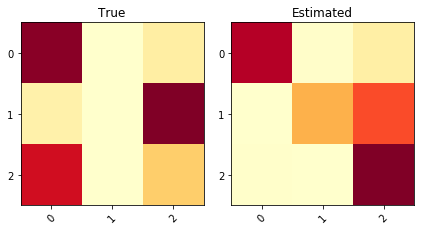

KL divergence: 1.1062	Pearson Correlation between diagonals: 0.5977


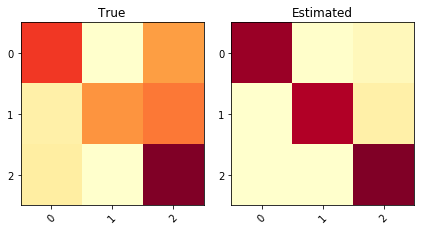

KL divergence: 0.5006	Pearson Correlation between diagonals: 0.9966


KL divergence: 0.7516	Pearson Correlation between diagonals: -0.9896


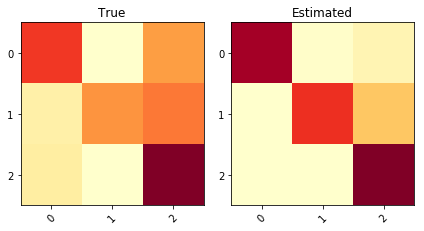

KL divergence: 0.3000	Pearson Correlation between diagonals: 0.9193


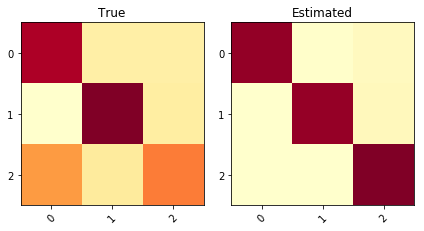

KL divergence: 0.7477	Pearson Correlation between diagonals: -0.9911


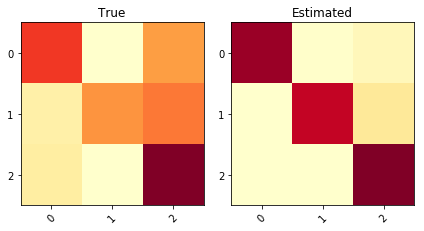

KL divergence: 0.4423	Pearson Correlation between diagonals: 0.9703


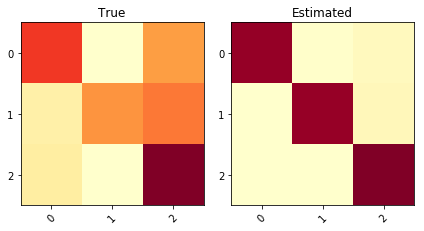

KL divergence: 0.6446	Pearson Correlation between diagonals: 0.9570


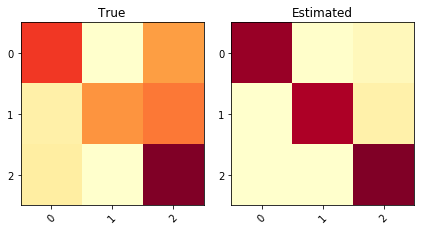

KL divergence: 0.5218	Pearson Correlation between diagonals: 0.9982


KL divergence: 0.5195	Pearson Correlation between diagonals: 0.9959


KL divergence: 0.2226	Pearson Correlation between diagonals: 0.8950


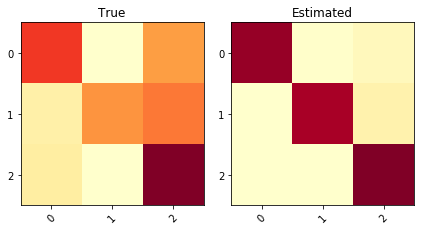

KL divergence: 0.5423	Pearson Correlation between diagonals: 0.9998


KL divergence: 0.6116	Pearson Correlation between diagonals: 0.9784
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global      0.8779        0.8779   0.662259  0.0987947            0.404112         0.13564
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.660914                0.764275
====  =======================  ======================
Test


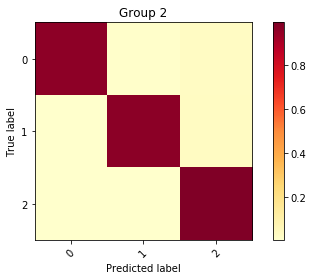

Inertia: 0.056952094620404146
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.225287     450   0.402231     0.719907  0.440979        0.813488   0.386573    0.650794      0.650794
   1         1  0.340152     680   0.223439     0.94202   0.0604302       0.97014    0.608687    0.797314      0.797314
   2         2  0.434561     869   0.124799     0.974587  0.0258361       0.987143   0.641254    0.875458      0.875458
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [109]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


KL divergence: 1.2573	Pearson Correlation between diagonals: 0.6589


KL divergence: 0.2176	Pearson Correlation between diagonals: 0.9018


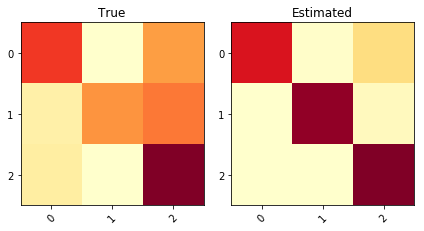

KL divergence: 0.5030	Pearson Correlation between diagonals: 0.2774


KL divergence: 0.3660	Pearson Correlation between diagonals: 0.9041


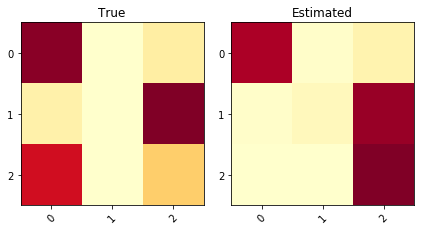

KL divergence: 1.2572	Pearson Correlation between diagonals: 0.6589


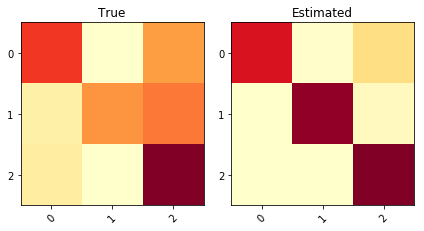

KL divergence: 0.5073	Pearson Correlation between diagonals: 0.2767


KL divergence: 1.2582	Pearson Correlation between diagonals: 0.6587


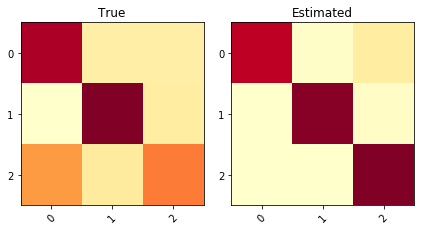

KL divergence: 0.6886	Pearson Correlation between diagonals: -0.4352


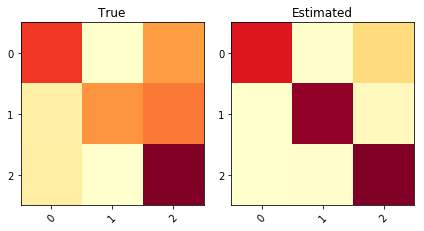

KL divergence: 0.4923	Pearson Correlation between diagonals: 0.2798


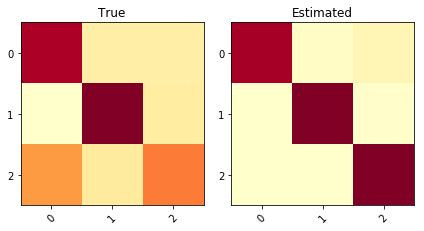

KL divergence: 0.7064	Pearson Correlation between diagonals: -0.3869


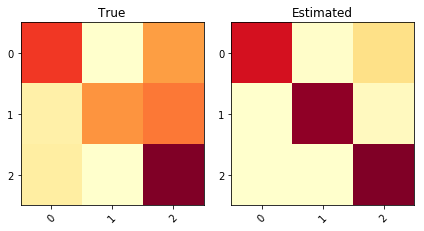

KL divergence: 0.5175	Pearson Correlation between diagonals: 0.2764


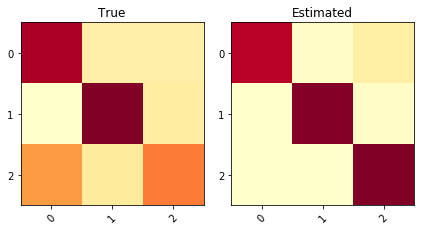

KL divergence: 0.6890	Pearson Correlation between diagonals: -0.4295


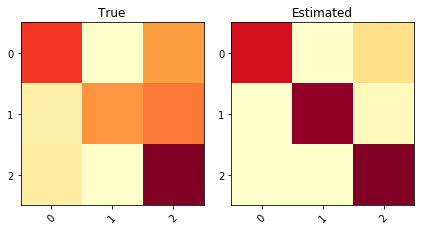

KL divergence: 0.5014	Pearson Correlation between diagonals: 0.2993


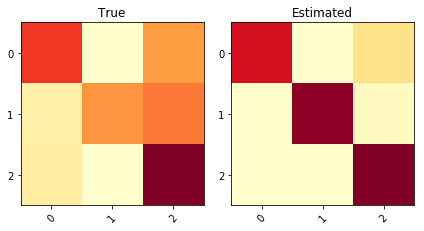

KL divergence: 0.5245	Pearson Correlation between diagonals: 0.2727


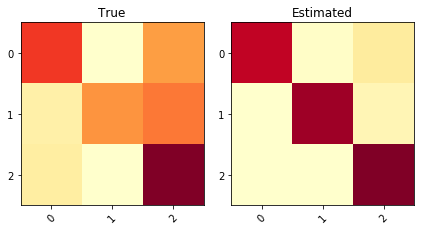

KL divergence: 0.4587	Pearson Correlation between diagonals: 0.5575
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.905576      0.905576   0.682246  0.0885787            0.287364        0.115795
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.671143                 0.72526
====  =======================  ======================
Test


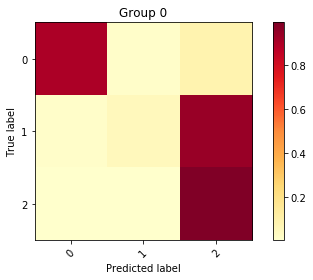

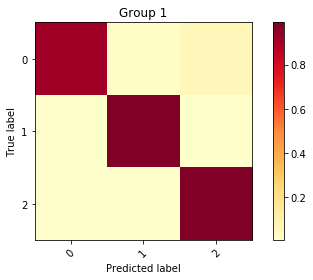

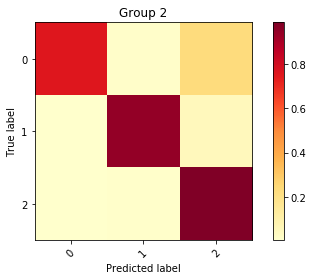

Inertia: 0.12695602048188448
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.34507      690   0.214008     0.647849  1.05834         0.694684   0.314516    0.647131      0.647131
   1         1  0.261818     523   0.143435     0.968704  0.0322994       0.983995   0.635371    0.921856      0.921856
   2         2  0.393112     786   0.291324     0.899282  0.112965        0.945428   0.565948    0.929182      0.929182
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [110]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T=5000, T_{data}=40$)

In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8131868131868132


*** Soft-Majority (Train with softMV) ***
Train


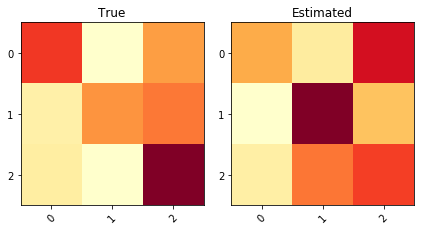

KL divergence: 0.3518	Pearson Correlation between diagonals: -0.4456


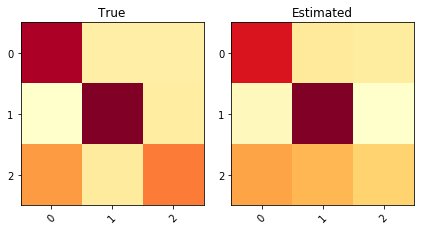

KL divergence: 0.1048	Pearson Correlation between diagonals: 0.9942


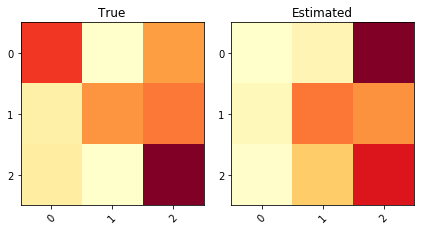

KL divergence: 0.4201	Pearson Correlation between diagonals: 0.4068


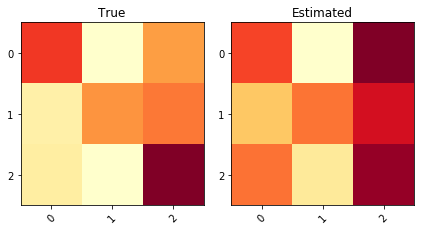

KL divergence: 0.1523	Pearson Correlation between diagonals: 0.9883


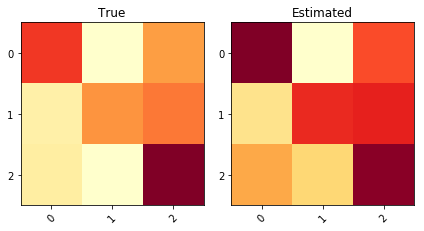

KL divergence: 0.1499	Pearson Correlation between diagonals: 0.7495


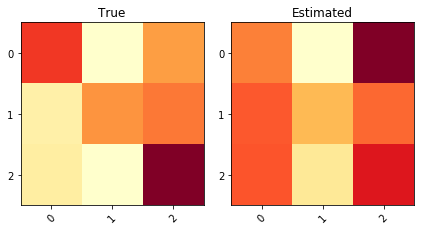

KL divergence: 0.2750	Pearson Correlation between diagonals: 0.9993


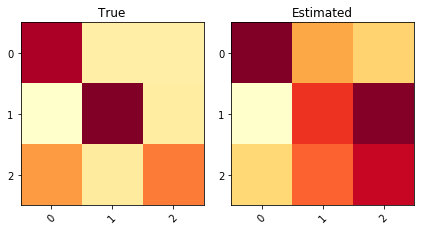

KL divergence: 0.2922	Pearson Correlation between diagonals: -0.1839


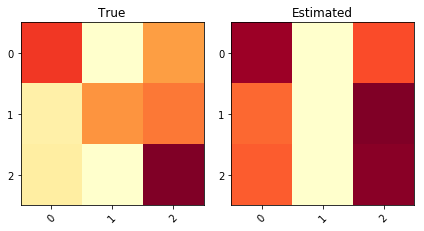

KL divergence: 2.1344	Pearson Correlation between diagonals: 0.8157


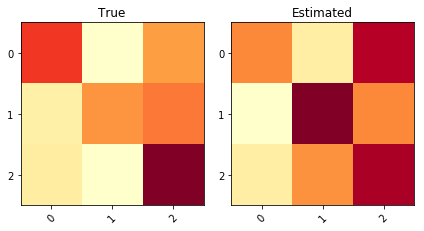

KL divergence: 0.2367	Pearson Correlation between diagonals: -0.0405


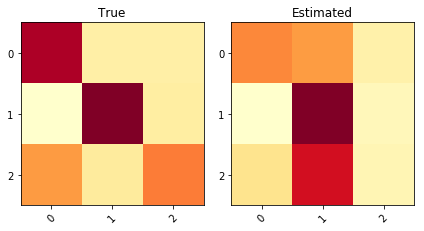

KL divergence: 0.3998	Pearson Correlation between diagonals: 0.9350


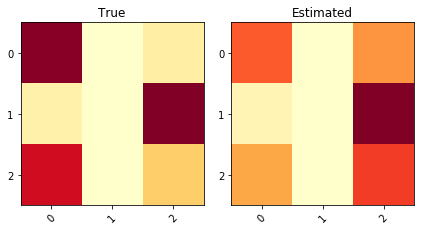

KL divergence: 0.1809	Pearson Correlation between diagonals: 0.6578


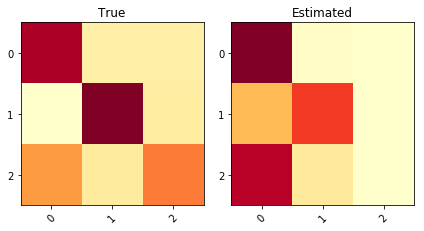

KL divergence: 3.3401	Pearson Correlation between diagonals: 0.8688


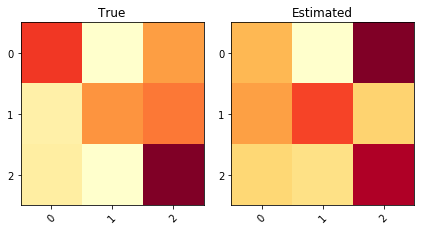

KL divergence: 0.2596	Pearson Correlation between diagonals: 0.5642


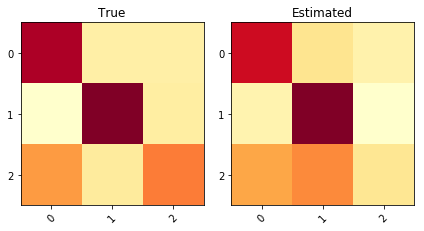

KL divergence: 0.1707	Pearson Correlation between diagonals: 0.9999


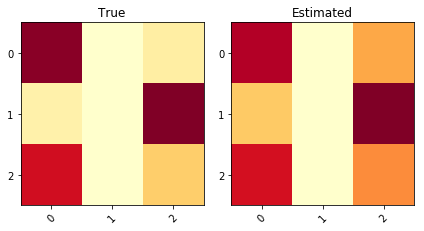

KL divergence: 0.0768	Pearson Correlation between diagonals: 0.9522
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.679691 |     0.679691 |     0.583063 |                0.6921 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.69475 |      0.69475 |
+----+--------+------------+--------------+


In [25]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


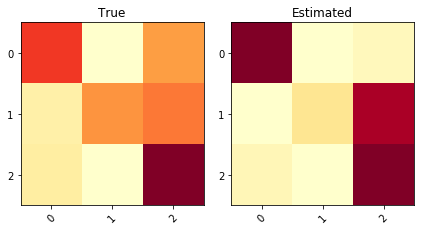

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


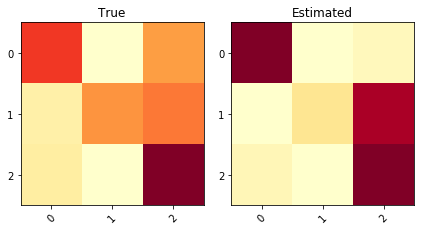

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


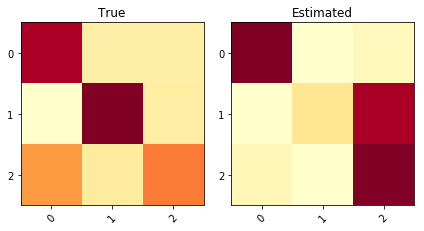

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


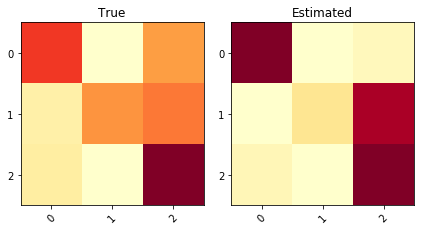

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


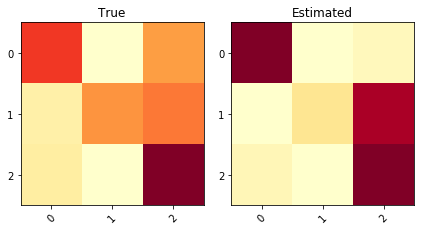

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


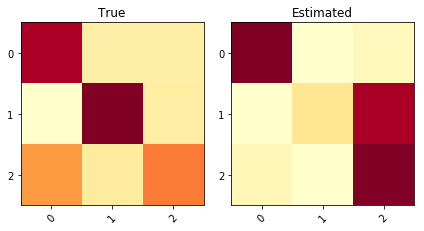

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


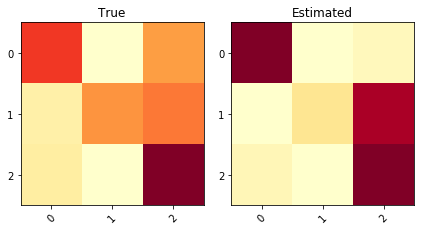

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


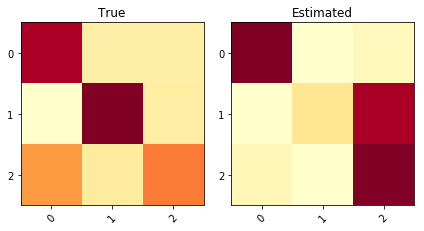

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


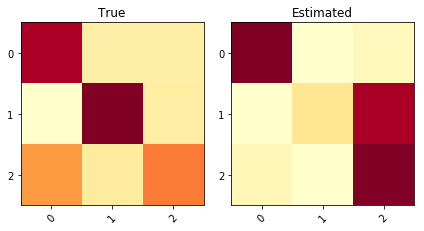

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


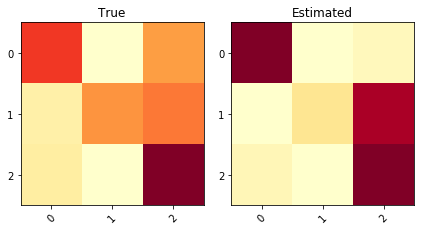

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


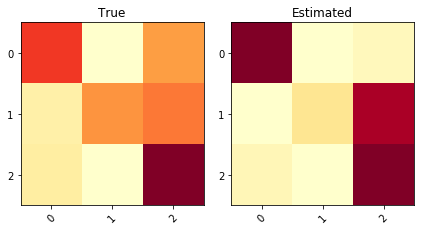

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


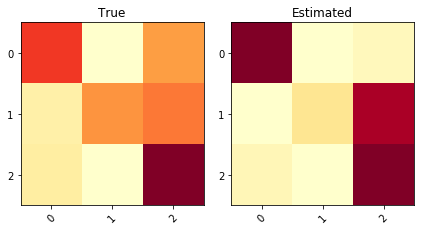

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


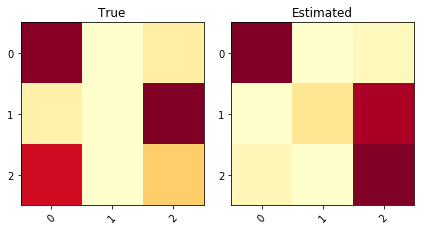

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7222


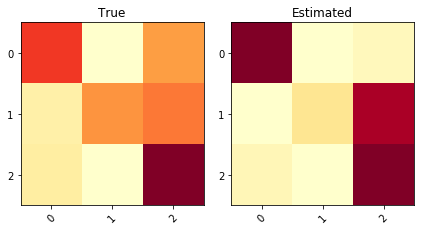

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


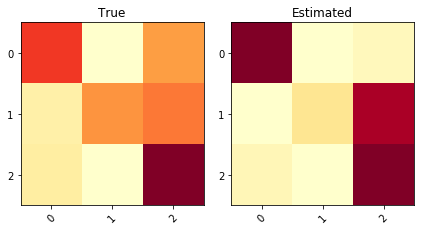

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.679691 |     0.679691 |     0.515368 |              0.426389 |
+----+--------+------------+--------------+--------------+-----------------------+


In [36]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


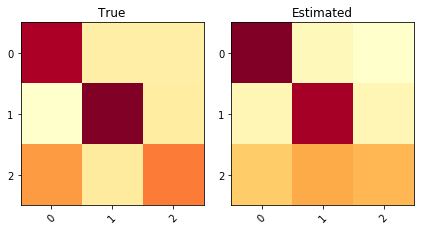

KL divergence: 0.1138	Pearson Correlation between diagonals: 0.9525


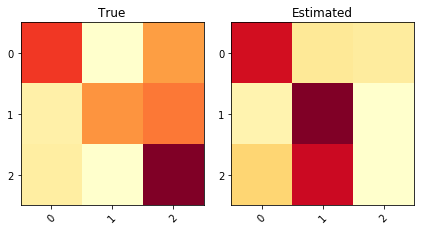

KL divergence: 3.5269	Pearson Correlation between diagonals: -0.9784


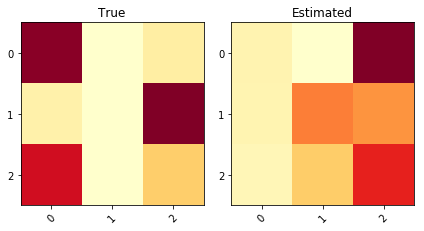

KL divergence: 1.2068	Pearson Correlation between diagonals: -0.8268


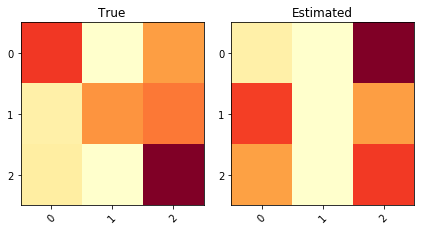

KL divergence: 2.4661	Pearson Correlation between diagonals: 0.9684


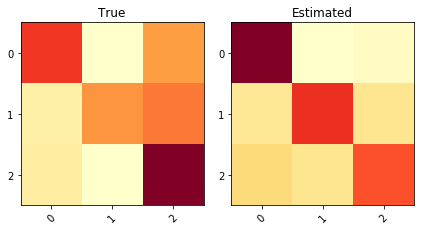

KL divergence: 0.4170	Pearson Correlation between diagonals: -0.3194


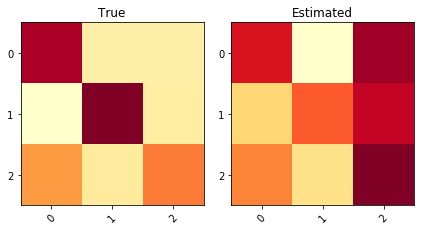

KL divergence: 0.4375	Pearson Correlation between diagonals: -0.9620


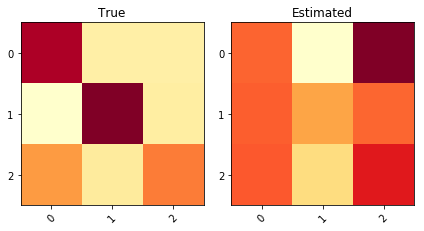

KL divergence: 0.5541	Pearson Correlation between diagonals: -0.9500


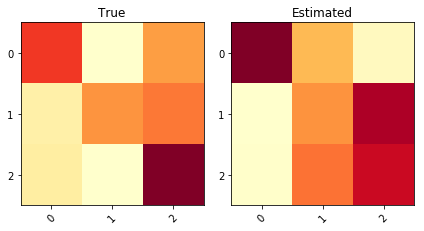

KL divergence: 0.6789	Pearson Correlation between diagonals: 0.5576


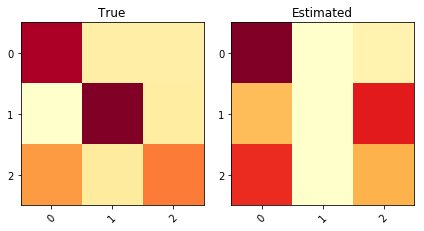

KL divergence: 5.6682	Pearson Correlation between diagonals: -0.0502


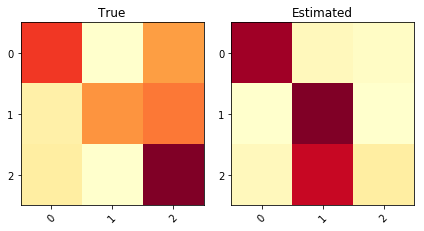

KL divergence: 1.3413	Pearson Correlation between diagonals: -0.9468


KL divergence: 2.1102	Pearson Correlation between diagonals: 0.8002


KL divergence: 0.1932	Pearson Correlation between diagonals: -0.0107


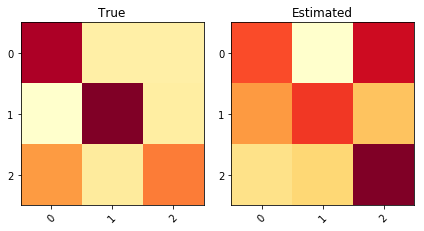

KL divergence: 0.4294	Pearson Correlation between diagonals: -0.9526


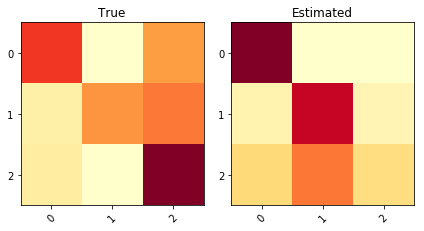

KL divergence: 0.7276	Pearson Correlation between diagonals: -0.8346


KL divergence: 2.2610	Pearson Correlation between diagonals: 0.4476
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.707367 |     0.707367 |      1.46083 |              0.151015 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.709402 |     0.709402 |
+----+--------+------------+--------------+


In [37]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


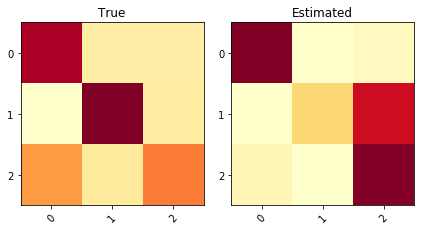

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


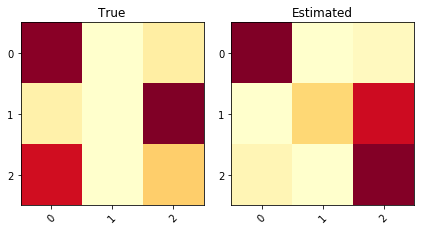

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7314


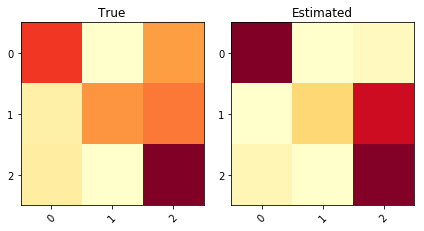

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


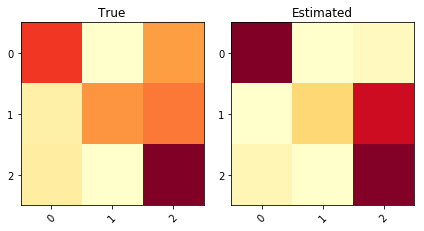

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


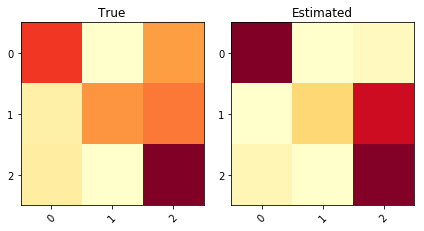

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


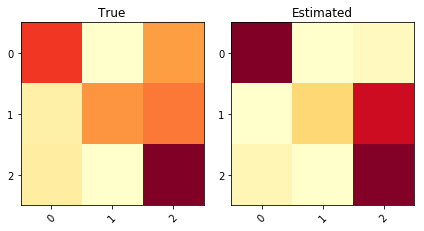

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


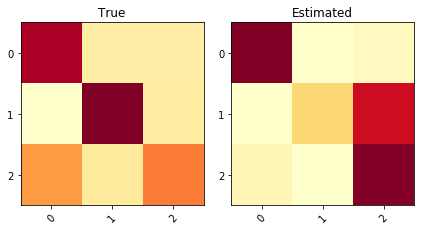

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


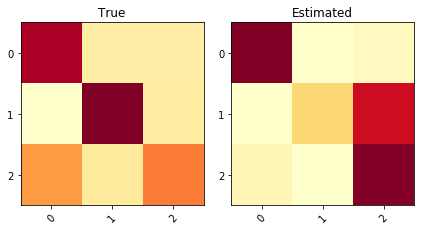

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


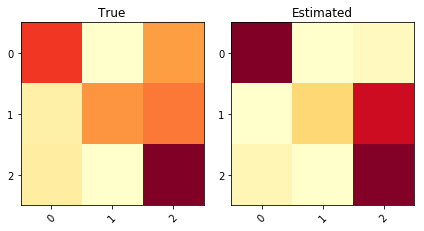

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


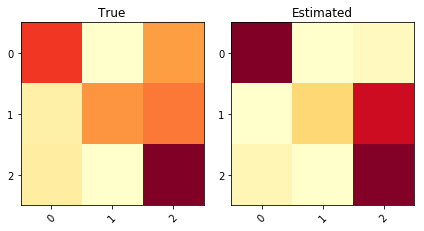

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


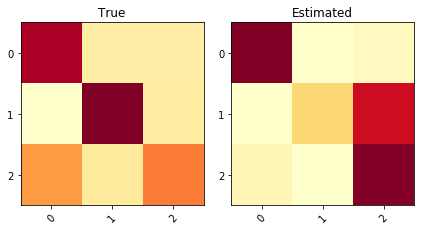

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


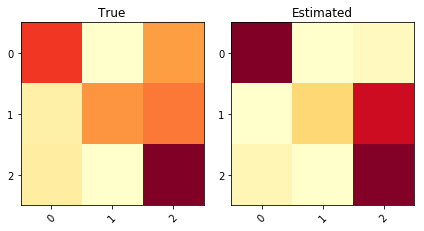

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


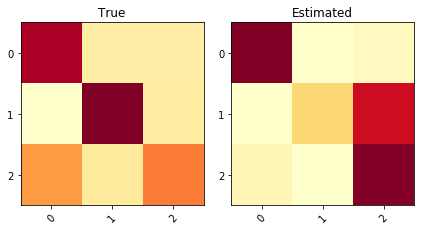

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


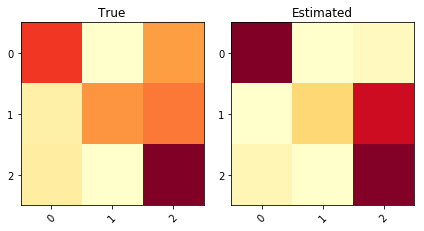

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.707367 |     0.707367 |     0.515368 |               0.42614 |
+----+--------+------------+--------------+--------------+-----------------------+


In [38]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


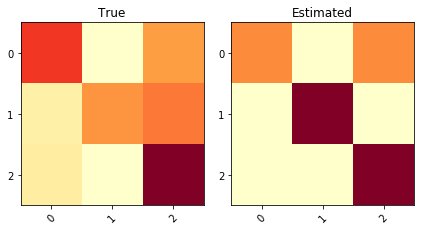

KL divergence: 3.2449	Pearson Correlation between diagonals: 0.1270


KL divergence: 2.0270	Pearson Correlation between diagonals: 0.4725


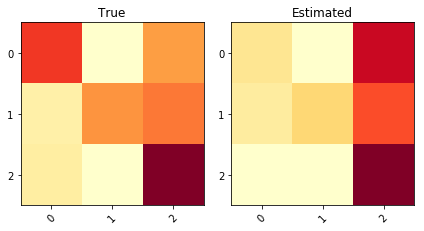

KL divergence: 0.6405	Pearson Correlation between diagonals: 0.8837


KL divergence: 8.7754	Pearson Correlation between diagonals: -0.6907


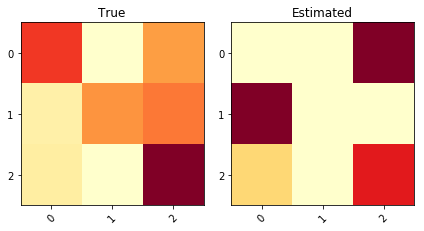

KL divergence: 7.6323	Pearson Correlation between diagonals: 0.9225


KL divergence: 2.8187	Pearson Correlation between diagonals: 0.9026


KL divergence: 2.5557	Pearson Correlation between diagonals: 0.9500


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


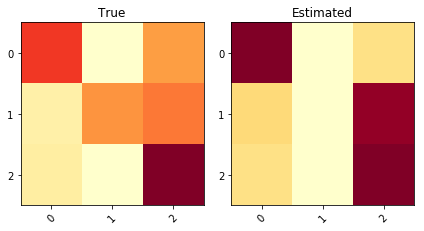

KL divergence: 2.1050	Pearson Correlation between diagonals: 0.7955


KL divergence: 7.7009	Pearson Correlation between diagonals: -0.9461


KL divergence: 2.3639	Pearson Correlation between diagonals: -0.2569


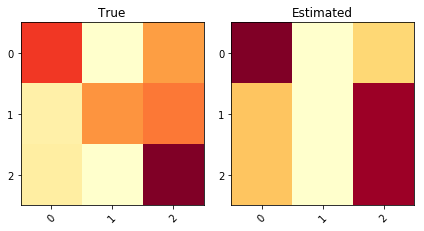

KL divergence: 2.1102	Pearson Correlation between diagonals: 0.7605


KL divergence: 2.7548	Pearson Correlation between diagonals: 0.7955


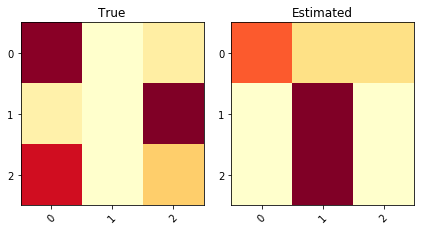

KL divergence: 10.5537	Pearson Correlation between diagonals: -0.1690


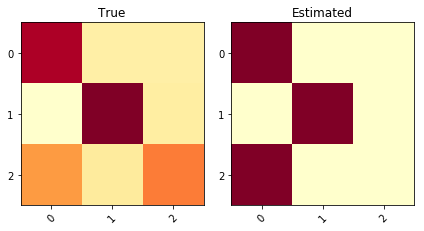

KL divergence: 4.1528	Pearson Correlation between diagonals: 0.9813


KL divergence: 0.3944	Pearson Correlation between diagonals: 0.9805
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.929996 |     0.929996 |      3.40725 |                   nan |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.945055 |     0.945055 |
+----+--------+------------+--------------+


In [39]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


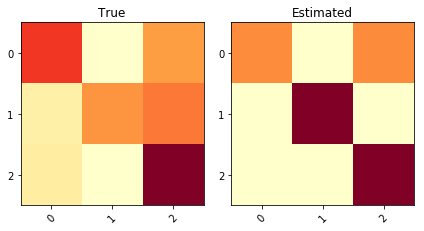

KL divergence: 0.2489	Pearson Correlation between diagonals: 0.1270


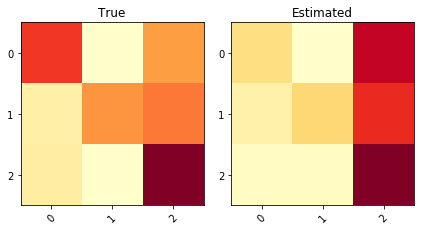

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.9049


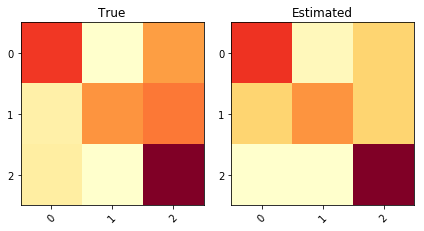

KL divergence: 0.1430	Pearson Correlation between diagonals: 0.9997


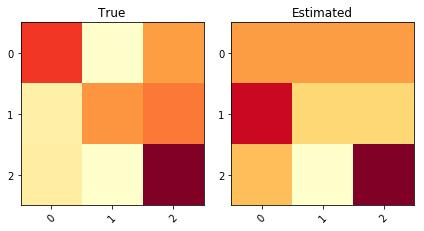

KL divergence: 0.3715	Pearson Correlation between diagonals: 0.9897


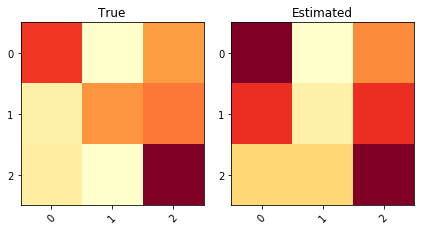

KL divergence: 0.2963	Pearson Correlation between diagonals: 0.7955


KL divergence: 0.3069	Pearson Correlation between diagonals: -0.8919


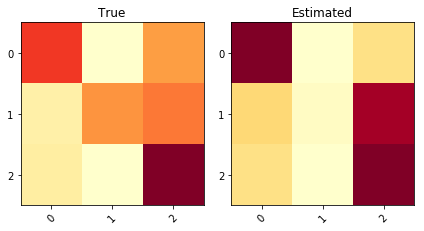

KL divergence: 0.2181	Pearson Correlation between diagonals: 0.7954


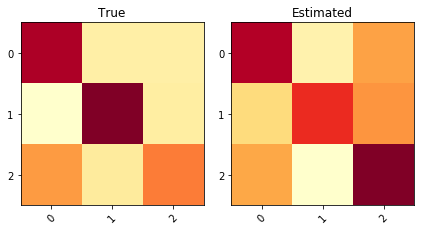

KL divergence: 0.2375	Pearson Correlation between diagonals: -0.8901


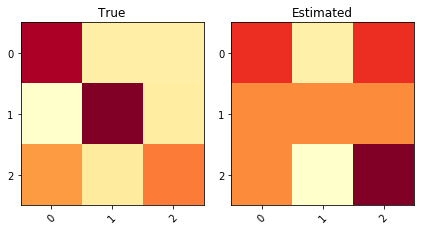

KL divergence: 0.3800	Pearson Correlation between diagonals: -0.9771


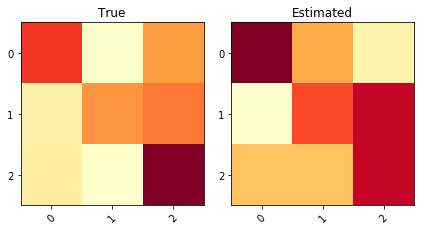

KL divergence: 0.2884	Pearson Correlation between diagonals: 0.4725


KL divergence: 0.4346	Pearson Correlation between diagonals: -0.9993


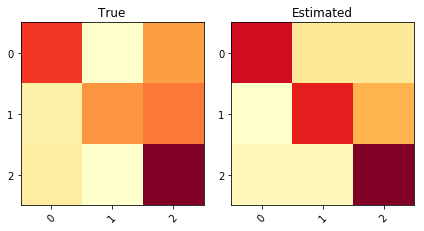

KL divergence: 0.1636	Pearson Correlation between diagonals: 0.9926


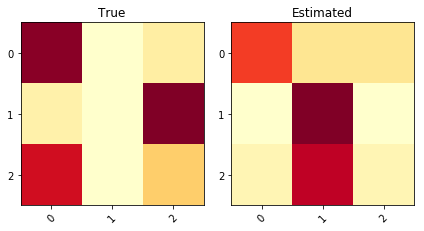

KL divergence: 0.9886	Pearson Correlation between diagonals: -0.1210


KL divergence: 0.4422	Pearson Correlation between diagonals: -0.9486


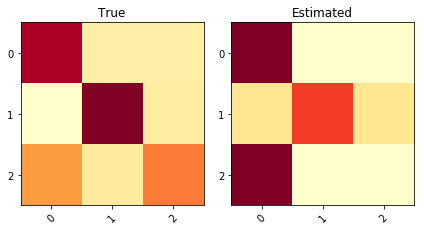

KL divergence: 0.2459	Pearson Correlation between diagonals: 0.8643
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.927961 |     0.927961 |     0.377019 |              0.135643 |       0.234728 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.49585 |                1.01583 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [40]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


KL divergence: 1.7701	Pearson Correlation between diagonals: -0.5259


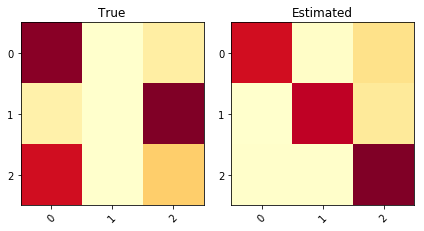

KL divergence: 1.7573	Pearson Correlation between diagonals: -0.5109


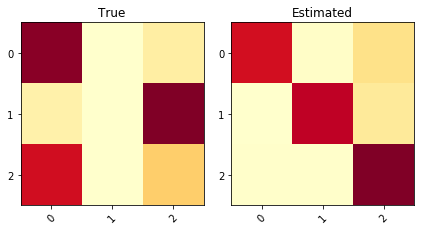

KL divergence: 1.7714	Pearson Correlation between diagonals: -0.5274


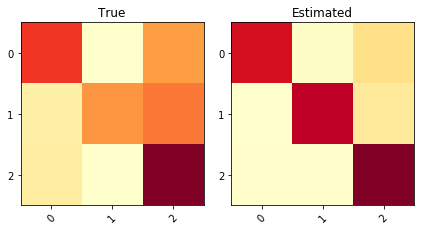

KL divergence: 0.3294	Pearson Correlation between diagonals: 0.7464


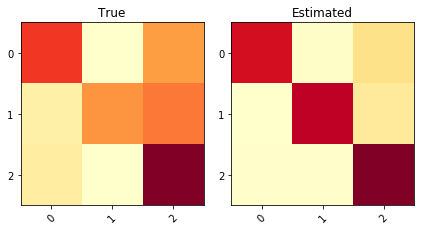

KL divergence: 0.3291	Pearson Correlation between diagonals: 0.7555


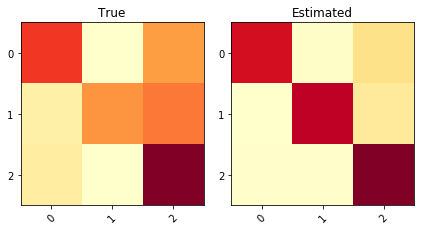

KL divergence: 0.3290	Pearson Correlation between diagonals: 0.7591


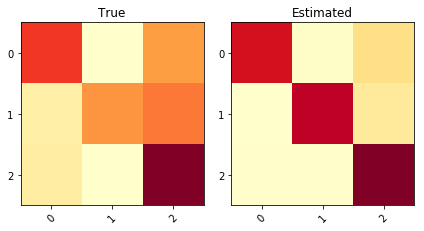

KL divergence: 0.3288	Pearson Correlation between diagonals: 0.7459


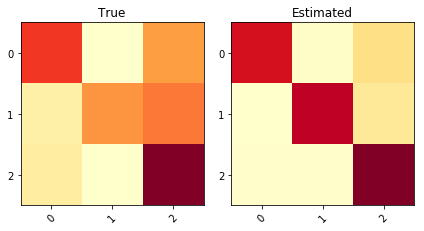

KL divergence: 0.3286	Pearson Correlation between diagonals: 0.7434


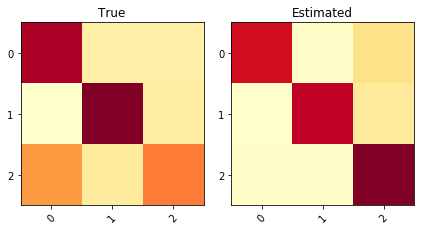

KL divergence: 0.6118	Pearson Correlation between diagonals: -0.8769


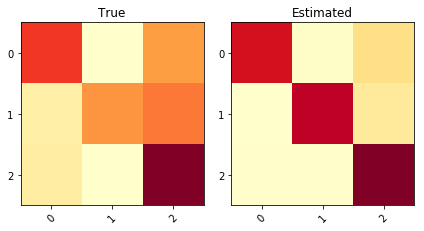

KL divergence: 0.3296	Pearson Correlation between diagonals: 0.7441


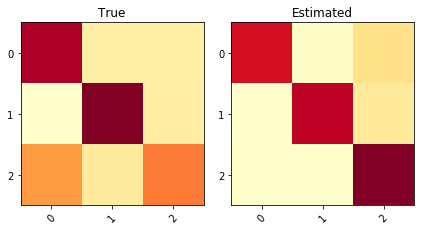

KL divergence: 0.6163	Pearson Correlation between diagonals: -0.8726


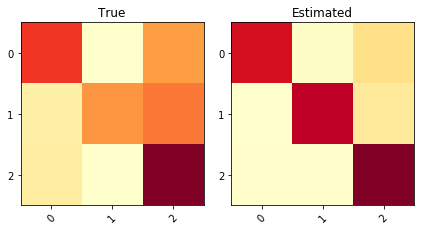

KL divergence: 0.3285	Pearson Correlation between diagonals: 0.7516


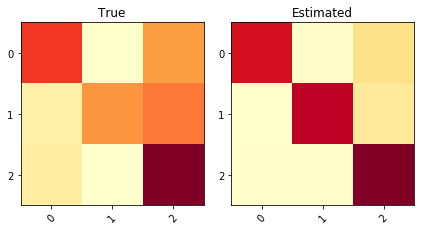

KL divergence: 0.3282	Pearson Correlation between diagonals: 0.7544


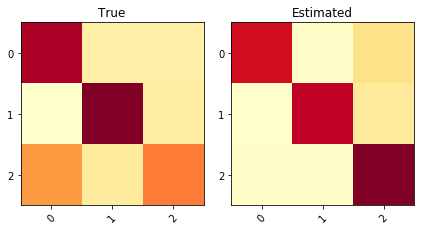

KL divergence: 0.6077	Pearson Correlation between diagonals: -0.8808


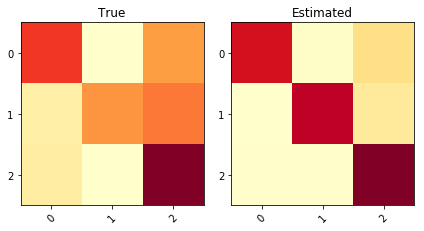

KL divergence: 0.3298	Pearson Correlation between diagonals: 0.7428
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.879121      0.879121      0.684328              0.0714332        0.186488
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.60342                0.802492
====  =======================  ======================
Test


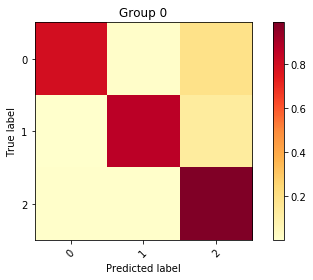

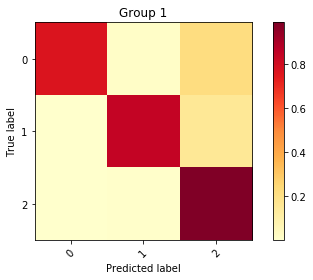

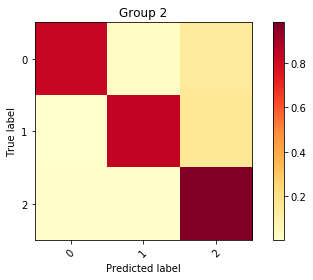

Inertia: 0.0012672375693606834
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.437364    2186   0.339188     0.884192   0.127093            0.938167    0.692308      0.692308
   1         1  0.377181    1885   0.366402     0.867399   0.147747            0.928456    0.672772      0.672772
   2         2  0.185455     927   0.359906     0.885049   0.125066            0.938987    0.675214      0.675214
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.875458      0.87

In [18]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


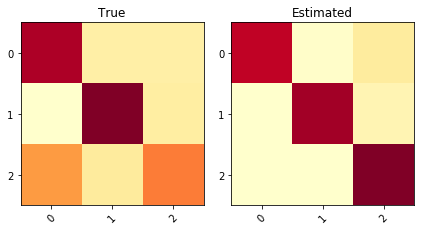

KL divergence: 0.8850	Pearson Correlation between diagonals: -0.7603


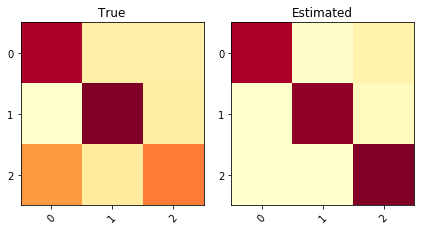

KL divergence: 0.9312	Pearson Correlation between diagonals: -0.6810


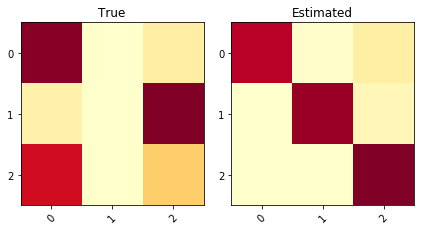

KL divergence: 2.4449	Pearson Correlation between diagonals: -0.7041


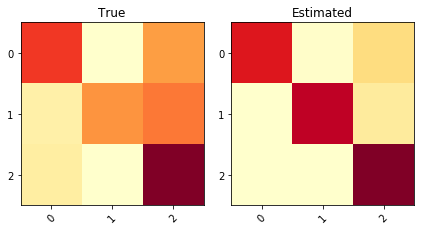

KL divergence: 0.3875	Pearson Correlation between diagonals: 0.6748


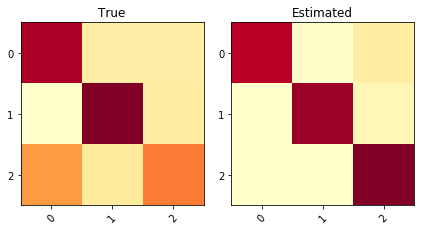

KL divergence: 0.8992	Pearson Correlation between diagonals: -0.7388


KL divergence: 0.4797	Pearson Correlation between diagonals: 0.6394


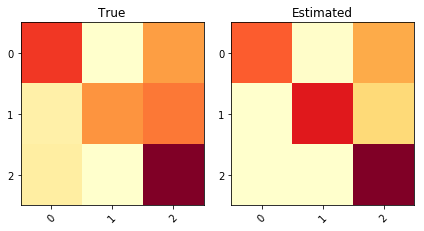

KL divergence: 0.2881	Pearson Correlation between diagonals: 0.6956


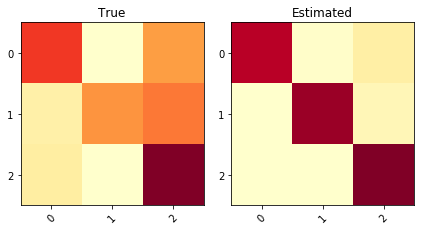

KL divergence: 0.5828	Pearson Correlation between diagonals: 0.5884


KL divergence: 0.2825	Pearson Correlation between diagonals: 0.6963


KL divergence: 0.3440	Pearson Correlation between diagonals: 0.6844


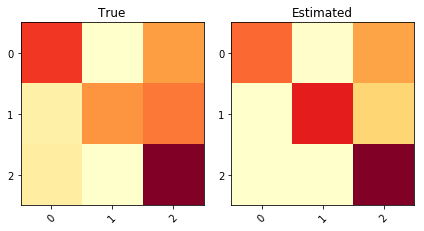

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.6973


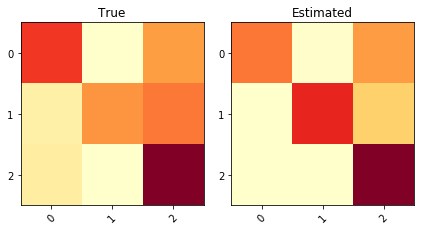

KL divergence: 0.2804	Pearson Correlation between diagonals: 0.6962


KL divergence: 0.8957	Pearson Correlation between diagonals: -0.7328


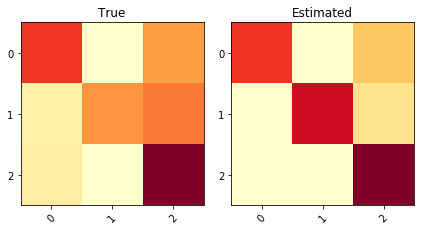

KL divergence: 0.3252	Pearson Correlation between diagonals: 0.6888


KL divergence: 0.8753	Pearson Correlation between diagonals: -0.7694
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.862027      0.862027      0.872728              0.0399778        0.156492
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.635078                0.758449
====  =======================  ======================
Test


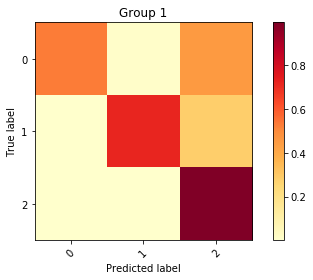

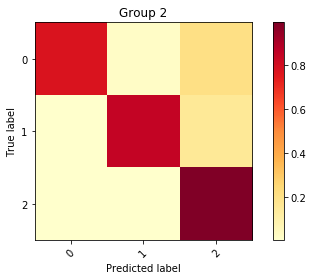

Inertia: 0.028337412513792515
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.47453     2372   0.163561     0.958927  0.0426241            0.978913    0.838828      0.838828
   1         1  0.344939    1724   0.45588      0.749184  0.321268             0.851638    0.547009      0.547009
   2         2  0.18053      902   0.359051     0.872339  0.141973             0.931209    0.667888      0.667888
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.864469      0.864

In [19]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


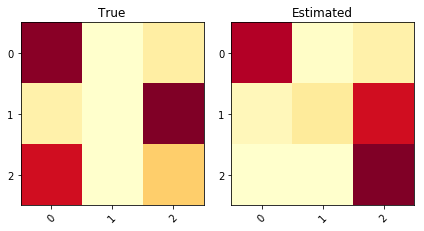

KL divergence: 1.1646	Pearson Correlation between diagonals: 0.6409


KL divergence: 0.5588	Pearson Correlation between diagonals: 0.2219


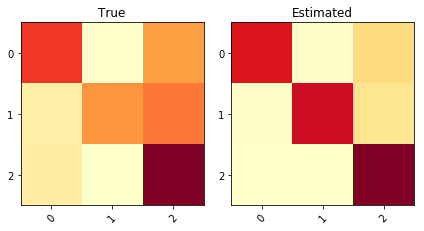

KL divergence: 0.2321	Pearson Correlation between diagonals: 0.8269


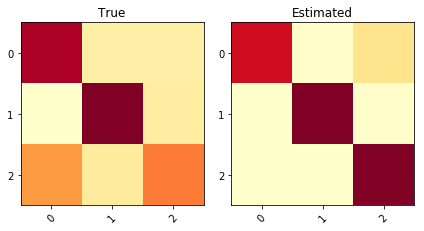

KL divergence: 0.6882	Pearson Correlation between diagonals: -0.3570


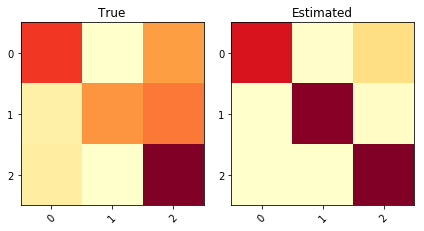

KL divergence: 0.5495	Pearson Correlation between diagonals: 0.2172


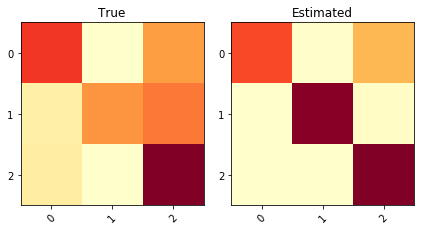

KL divergence: 0.5395	Pearson Correlation between diagonals: 0.1762


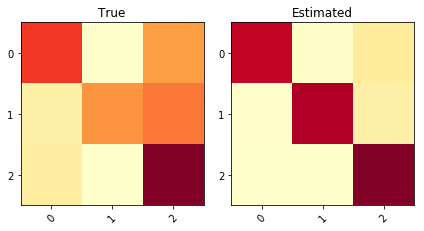

KL divergence: 0.3491	Pearson Correlation between diagonals: 0.7822


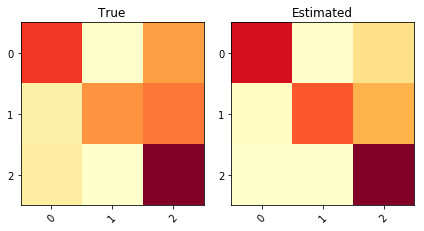

KL divergence: 0.1414	Pearson Correlation between diagonals: 0.9945


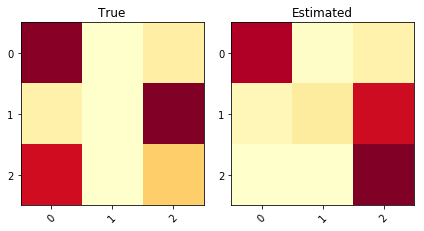

KL divergence: 1.1604	Pearson Correlation between diagonals: 0.6452


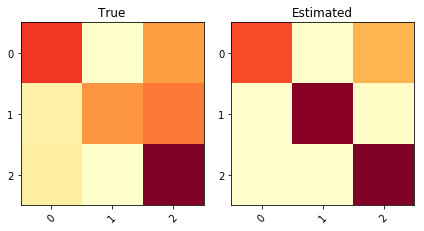

KL divergence: 0.5202	Pearson Correlation between diagonals: 0.1825


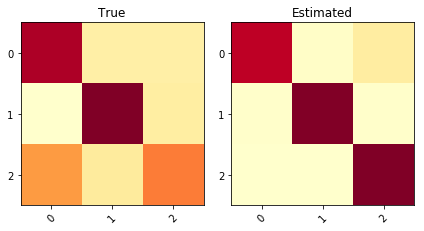

KL divergence: 0.6899	Pearson Correlation between diagonals: -0.3545


KL divergence: 0.5021	Pearson Correlation between diagonals: 0.1916


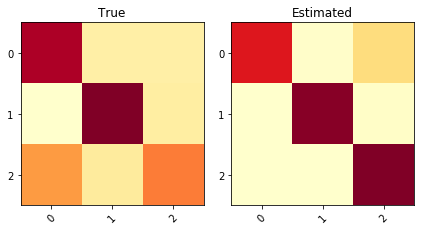

KL divergence: 0.6836	Pearson Correlation between diagonals: -0.3802


KL divergence: 0.6904	Pearson Correlation between diagonals: -0.3516


KL divergence: 0.5484	Pearson Correlation between diagonals: 0.1784
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.900692      0.900692      0.618431               0.277073        0.130664
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.686919                0.708123
====  =======================  ======================
Test


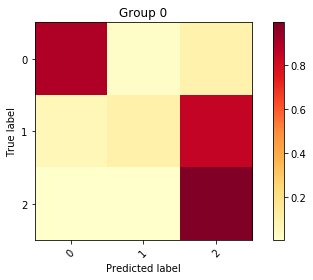

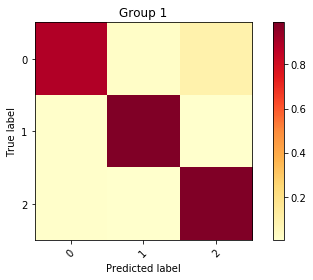

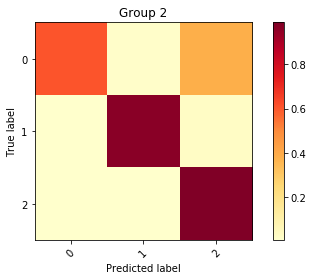

Inertia: 0.1217692531645298
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.272794    1363   0.322061     0.661478   0.814433            0.726401    0.64591       0.64591
   1         1  0.329308    1646   0.172086     0.956637   0.045573            0.977538    0.91453       0.91453
   2         2  0.397897    1989   0.314001     0.854963   0.180985            0.915633    0.892552      0.892552
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.904762      0.904762


In [20]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v3 ($T$ = 10000, $T_{data}$ = 40 )

In [127]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8196988196988197


*** Soft-Majority (Train with softMV) ***
Train


KL divergence: 3.4929	Pearson Correlation between diagonals: 0.9490


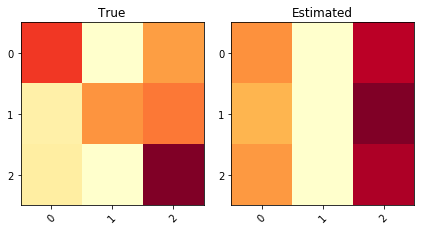

KL divergence: 2.1479	Pearson Correlation between diagonals: 0.9852


KL divergence: 2.1607	Pearson Correlation between diagonals: 0.9609


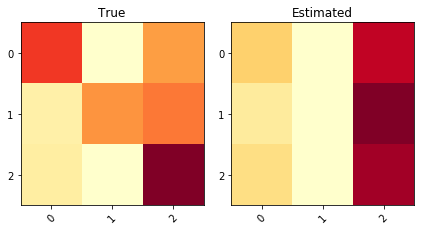

KL divergence: 2.1592	Pearson Correlation between diagonals: 0.9948


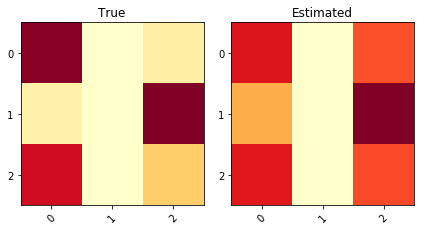

KL divergence: 0.1587	Pearson Correlation between diagonals: 0.8276


KL divergence: 0.3463	Pearson Correlation between diagonals: 0.9980


KL divergence: 0.2057	Pearson Correlation between diagonals: 0.9802


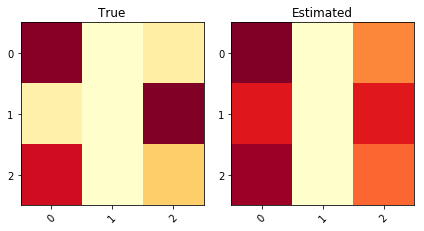

KL divergence: 0.1943	Pearson Correlation between diagonals: 0.9479


KL divergence: 0.3311	Pearson Correlation between diagonals: 0.9991


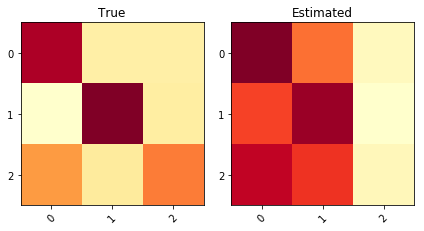

KL divergence: 0.3900	Pearson Correlation between diagonals: 0.9694


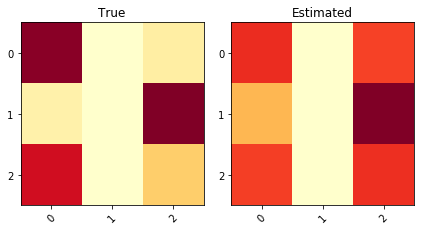

KL divergence: 0.1883	Pearson Correlation between diagonals: 0.7288


KL divergence: 0.1553	Pearson Correlation between diagonals: 0.9501


KL divergence: 0.4354	Pearson Correlation between diagonals: 0.1549


KL divergence: 0.5038	Pearson Correlation between diagonals: -0.8822


KL divergence: 0.5125	Pearson Correlation between diagonals: -0.1413
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.53195       0.53195   0.927163  0.0949629            0.688426
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.542125      0.542125
====  ======  ==========  ============


In [128]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


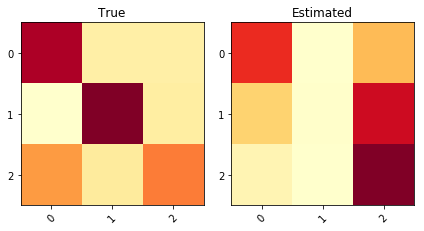

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.8443


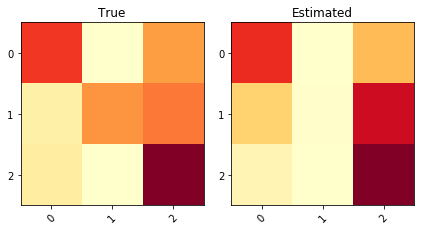

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.9349


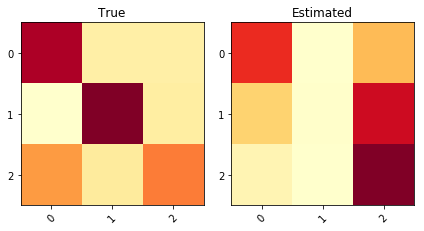

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.8443


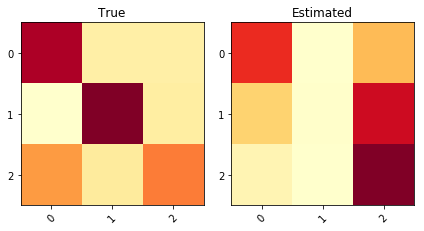

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.8443


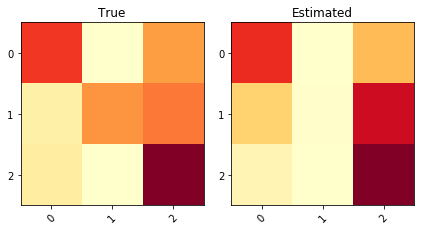

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.9349


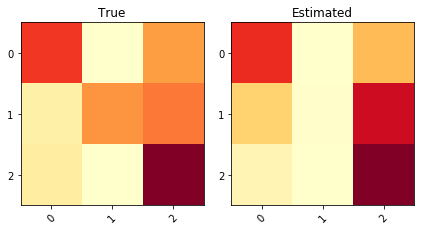

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.9349


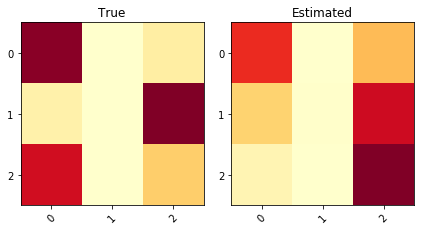

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.4972


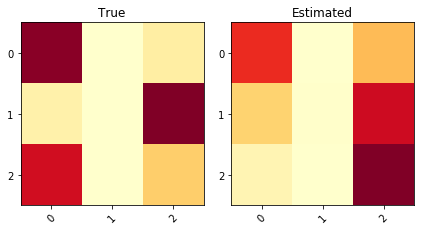

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.4972


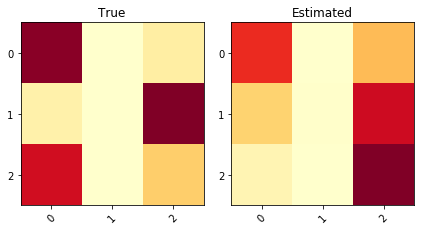

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.4972


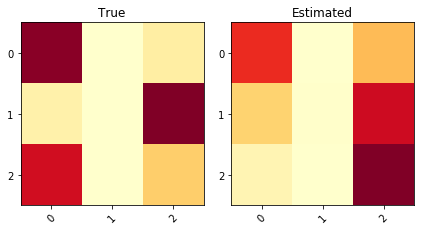

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.4972


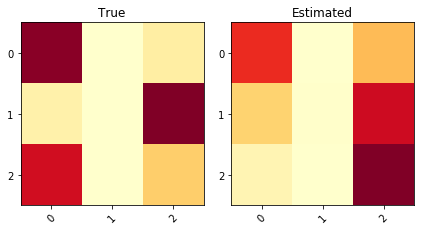

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.4972


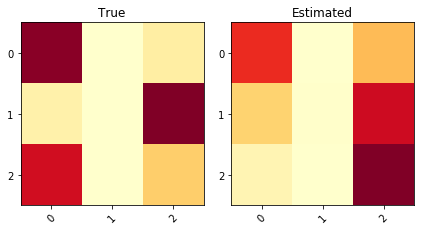

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.4972


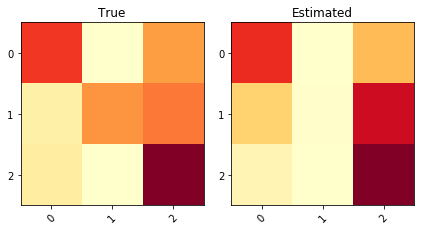

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.9349


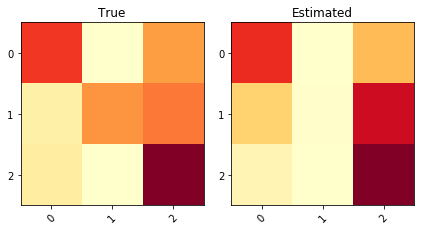

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.9349


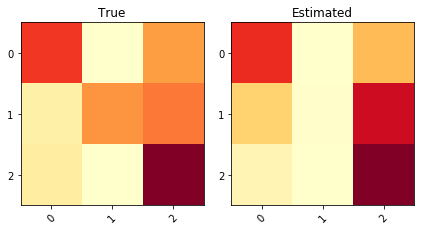

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.9349
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.53195       0.53195   0.525528  0.0960133            0.397673
====  ======  ==========  ============  =========  =========  ==================


In [129]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


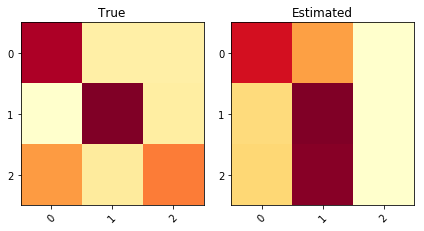

KL divergence: 3.4248	Pearson Correlation between diagonals: 1.0000


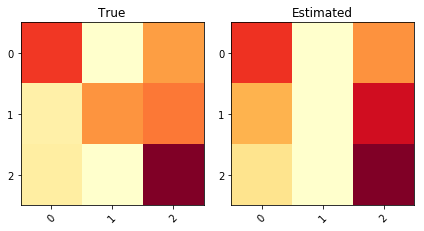

KL divergence: 2.0660	Pearson Correlation between diagonals: 0.9398


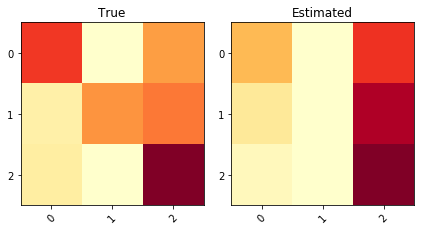

KL divergence: 2.1131	Pearson Correlation between diagonals: 0.9991


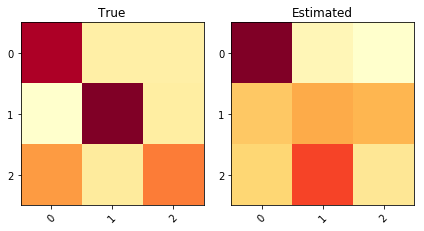

KL divergence: 0.3794	Pearson Correlation between diagonals: 0.5717


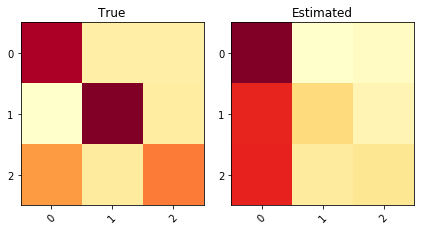

KL divergence: 0.4829	Pearson Correlation between diagonals: 0.3909


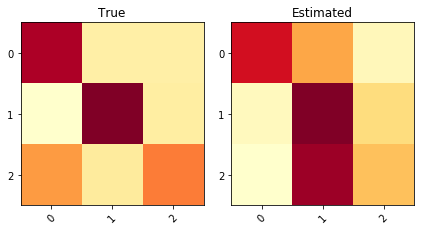

KL divergence: 0.3942	Pearson Correlation between diagonals: 0.9953


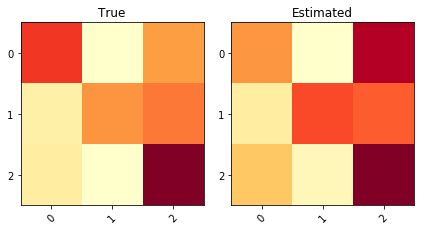

KL divergence: 0.1155	Pearson Correlation between diagonals: 0.7568


KL divergence: 0.1201	Pearson Correlation between diagonals: 0.9999


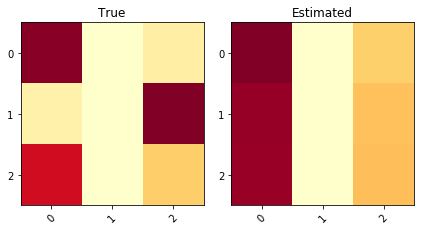

KL divergence: 0.3415	Pearson Correlation between diagonals: 0.9989


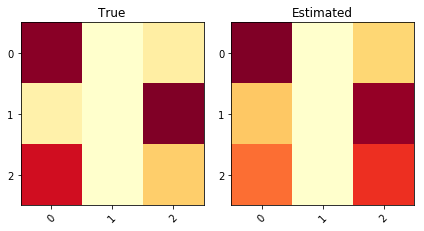

KL divergence: 0.0990	Pearson Correlation between diagonals: 0.8949


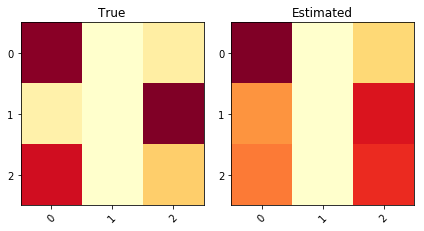

KL divergence: 0.1522	Pearson Correlation between diagonals: 0.8881


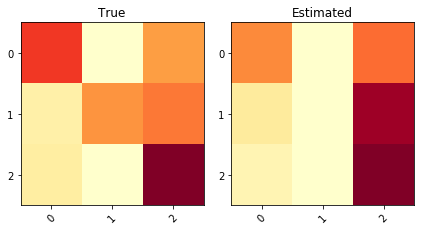

KL divergence: 2.0668	Pearson Correlation between diagonals: 0.9909


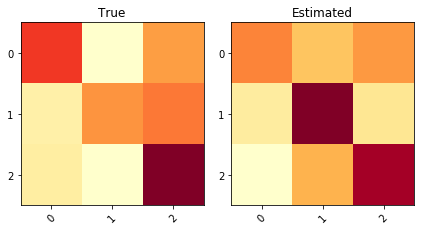

KL divergence: 0.3202	Pearson Correlation between diagonals: -0.0210


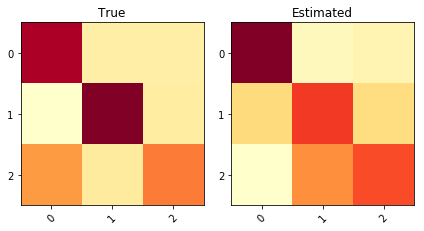

KL divergence: 0.2806	Pearson Correlation between diagonals: 0.4229


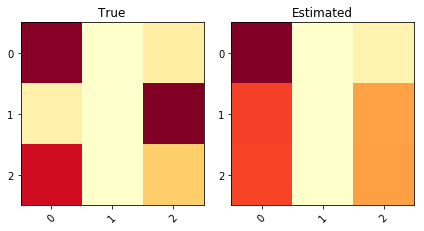

KL divergence: 0.2183	Pearson Correlation between diagonals: 0.9862
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.695157      0.695157   0.877581  0.0809558            0.687946
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.704518      0.704518
====  ======  ==========  ============


In [130]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


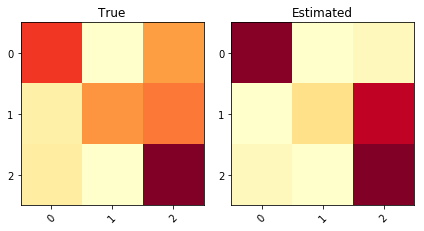

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8064


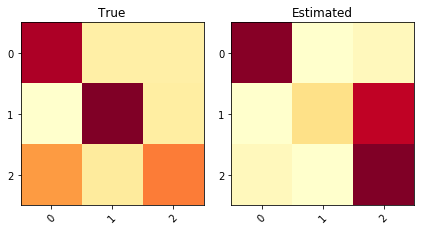

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6708


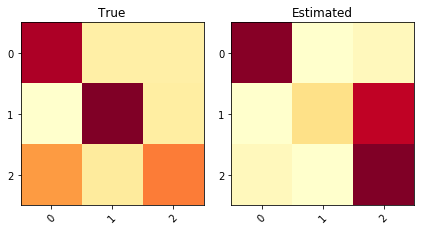

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6708


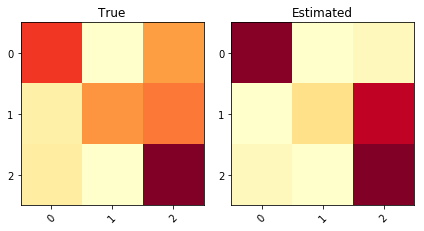

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8064


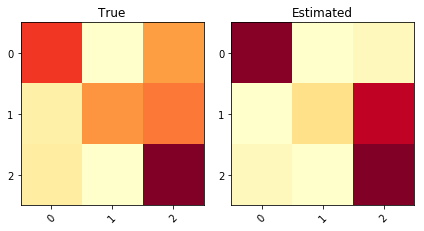

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8064


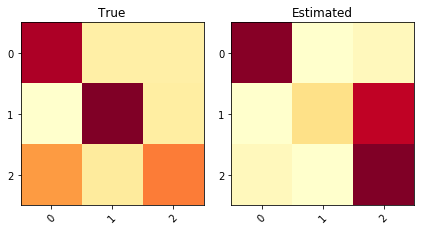

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6708


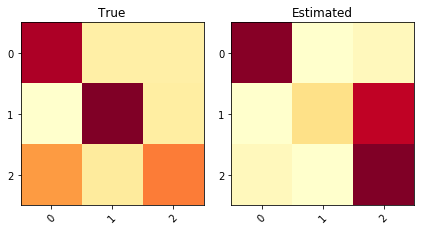

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6708


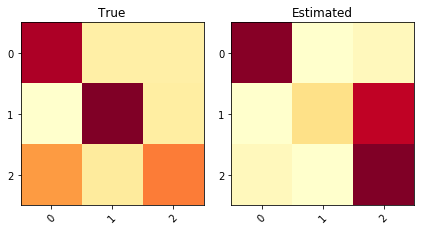

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6708


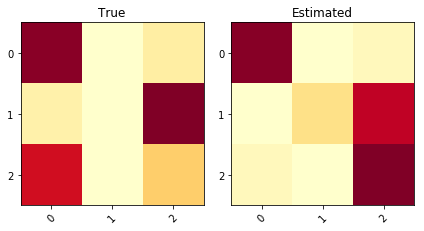

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7105


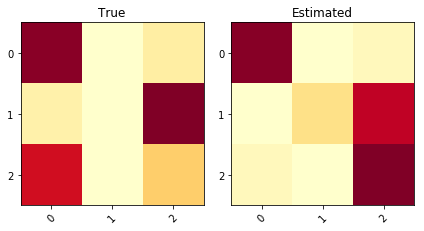

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7105


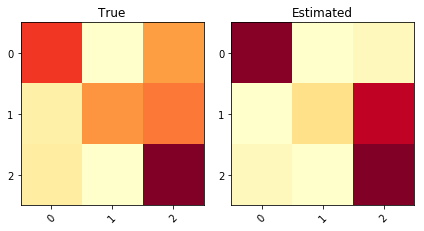

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8064


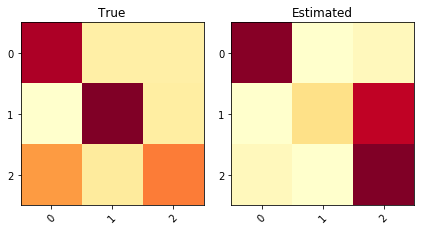

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6708


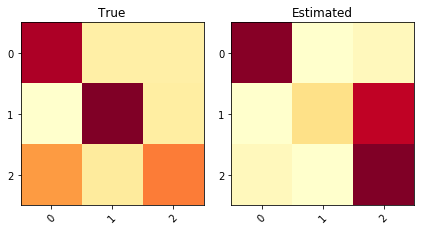

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6708


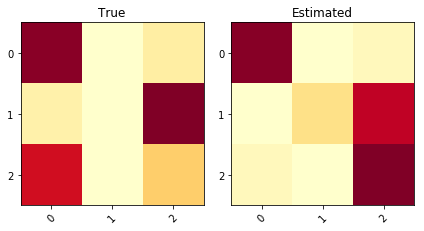

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7105


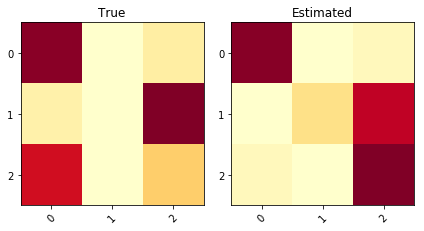

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7105
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.695157      0.695157   0.525528  0.0960133            0.414761
====  ======  ==========  ============  =========  =========  ==================


In [131]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


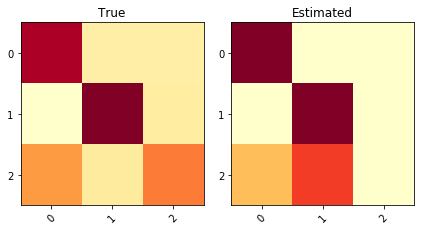

KL divergence: 3.6653	Pearson Correlation between diagonals: 0.9813


KL divergence: 2.5120	Pearson Correlation between diagonals: 0.9178


KL divergence: 0.5375	Pearson Correlation between diagonals: 0.9999


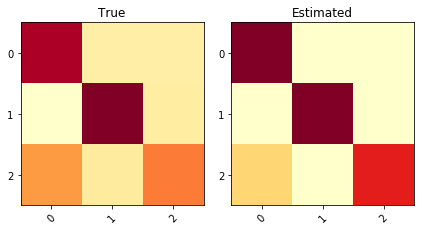

KL divergence: 1.8264	Pearson Correlation between diagonals: 0.9813


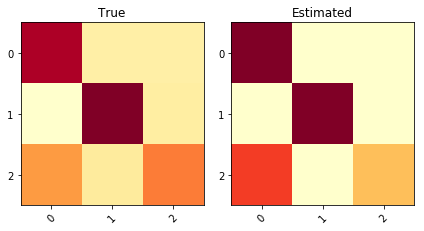

KL divergence: 1.8255	Pearson Correlation between diagonals: 0.9813


KL divergence: 0.8804	Pearson Correlation between diagonals: 0.9064


KL divergence: 2.9393	Pearson Correlation between diagonals: 0.9999


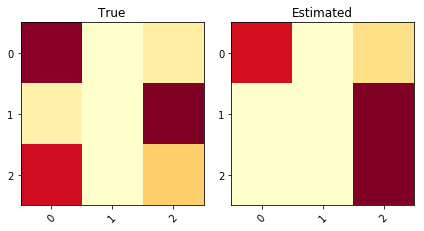

KL divergence: 4.1674	Pearson Correlation between diagonals: 0.5796


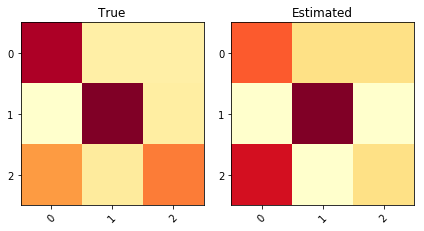

KL divergence: 1.0987	Pearson Correlation between diagonals: 0.9461


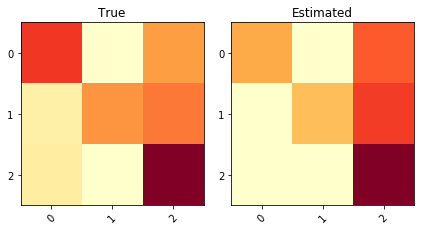

KL divergence: 0.8823	Pearson Correlation between diagonals: 0.9537


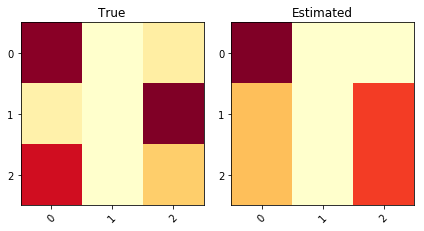

KL divergence: 0.6265	Pearson Correlation between diagonals: 0.9094


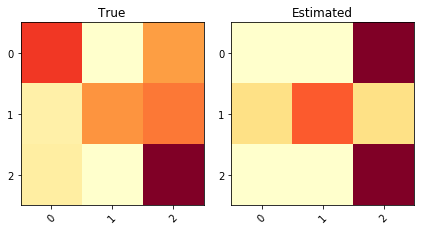

KL divergence: 3.5621	Pearson Correlation between diagonals: 0.5107


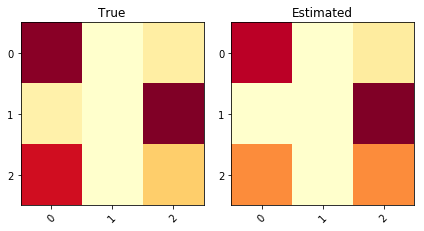

KL divergence: 0.4055	Pearson Correlation between diagonals: 0.9489


KL divergence: 1.3793	Pearson Correlation between diagonals: 0.9813


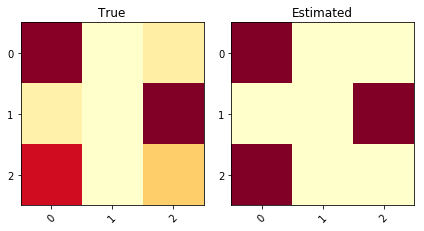

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: divide by zero encountered in double_scalars
  r = r_num / r_den


A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.921449      0.921449    2.18914   0.130586                 nan
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.934066      0.934066
====  ======  ==========  ============


In [132]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


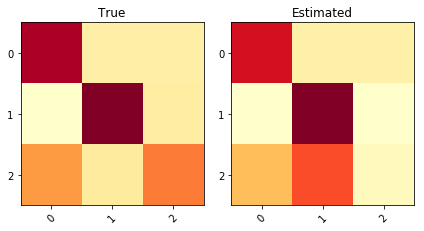

KL divergence: 0.2247	Pearson Correlation between diagonals: 1.0000


KL divergence: 0.1808	Pearson Correlation between diagonals: 0.7821


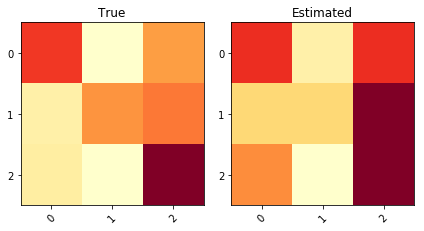

KL divergence: 0.2542	Pearson Correlation between diagonals: 0.9708


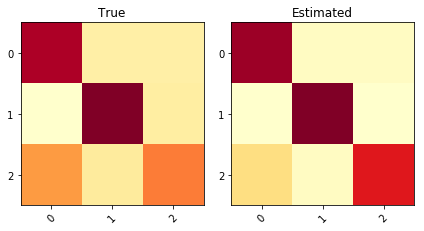

KL divergence: 0.1100	Pearson Correlation between diagonals: 0.9989


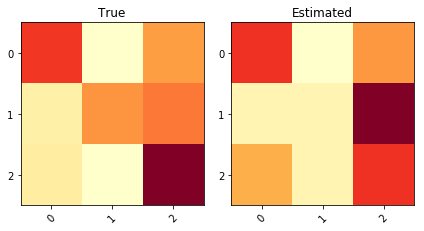

KL divergence: 0.2406	Pearson Correlation between diagonals: 0.7955


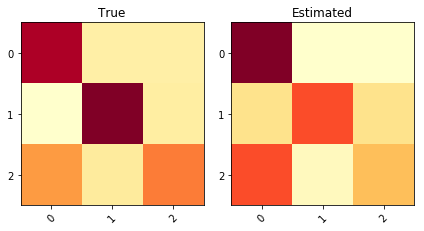

KL divergence: 0.1658	Pearson Correlation between diagonals: 0.7044


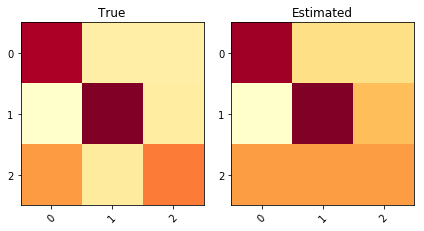

KL divergence: 0.1430	Pearson Correlation between diagonals: 0.9965


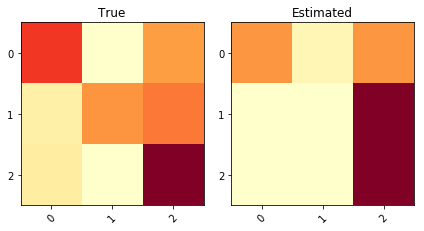

KL divergence: 0.2159	Pearson Correlation between diagonals: 0.9961


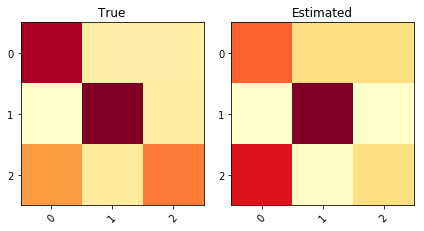

KL divergence: 0.1505	Pearson Correlation between diagonals: 0.9358


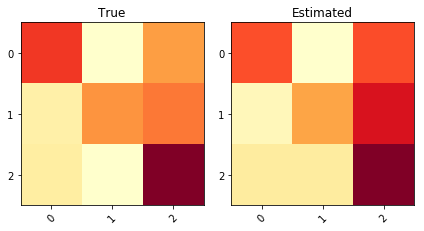

KL divergence: 0.1665	Pearson Correlation between diagonals: 0.9993


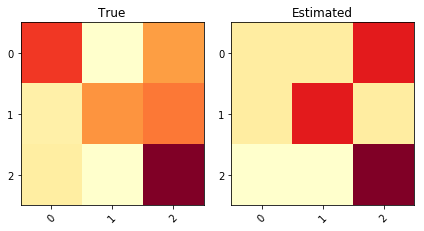

KL divergence: 0.2977	Pearson Correlation between diagonals: 0.3971


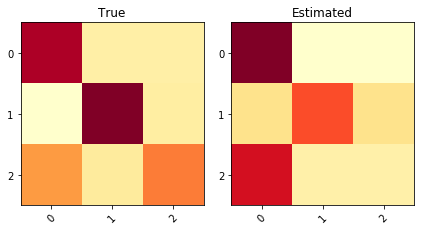

KL divergence: 0.2150	Pearson Correlation between diagonals: 0.8131


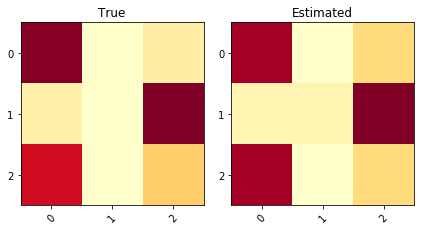

KL divergence: 0.1989	Pearson Correlation between diagonals: 0.9936


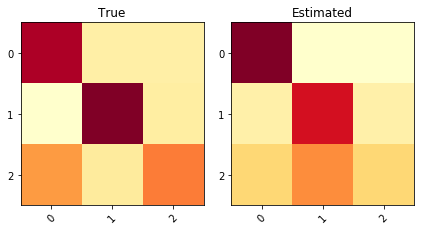

KL divergence: 0.1807	Pearson Correlation between diagonals: 0.8987


KL divergence: 0.1130	Pearson Correlation between diagonals: 0.8467


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.612536      0.612536   0.237111  0.0695195                 nan        0.200232
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.647602                0.874701
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.595849      0.595849
====  ======  ==========  ============


In [133]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


KL divergence: 0.2982	Pearson Correlation between diagonals: -0.8272


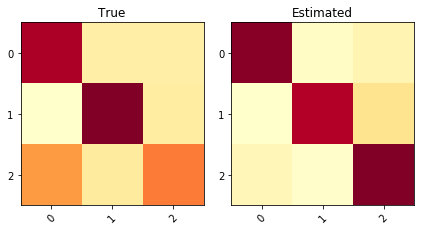

KL divergence: 0.2962	Pearson Correlation between diagonals: -0.7938


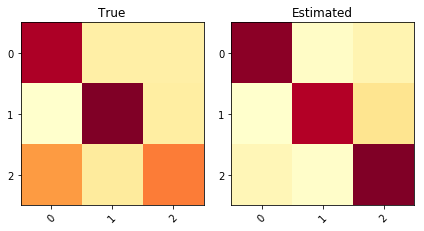

KL divergence: 0.2977	Pearson Correlation between diagonals: -0.8124


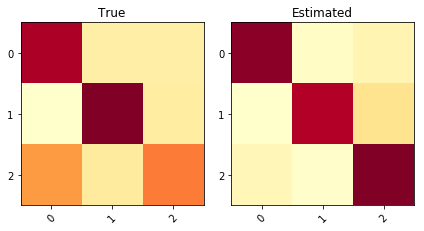

KL divergence: 0.2962	Pearson Correlation between diagonals: -0.8008


KL divergence: 0.2954	Pearson Correlation between diagonals: -0.7815


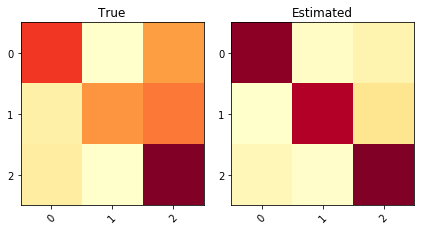

KL divergence: 0.3456	Pearson Correlation between diagonals: 0.9261


KL divergence: 0.3453	Pearson Correlation between diagonals: 0.9102


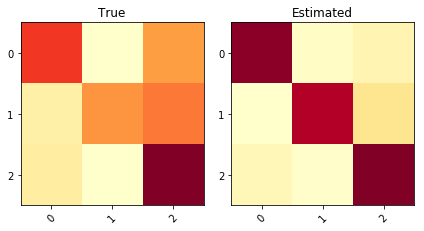

KL divergence: 0.3455	Pearson Correlation between diagonals: 0.9193


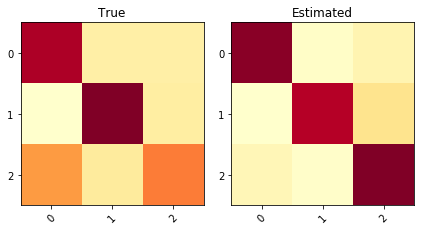

KL divergence: 0.2954	Pearson Correlation between diagonals: -0.7822


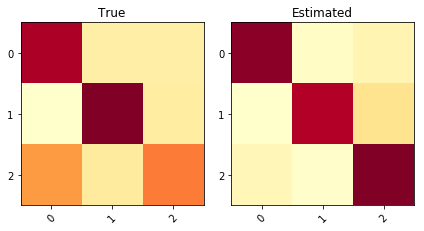

KL divergence: 0.2964	Pearson Correlation between diagonals: -0.8079


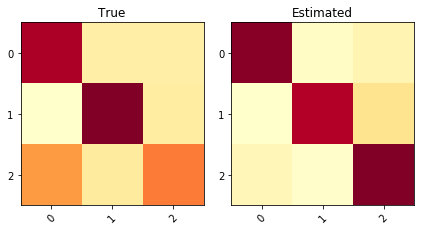

KL divergence: 0.2964	Pearson Correlation between diagonals: -0.7956


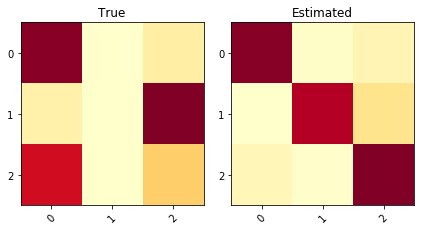

KL divergence: 1.1450	Pearson Correlation between diagonals: 0.6032


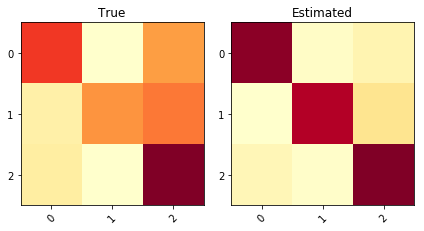

KL divergence: 0.3454	Pearson Correlation between diagonals: 0.9117


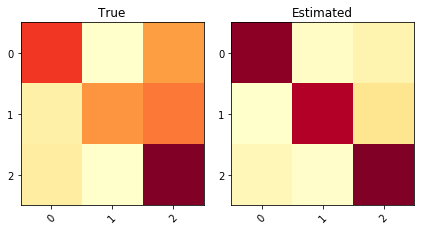

KL divergence: 0.3456	Pearson Correlation between diagonals: 0.9245


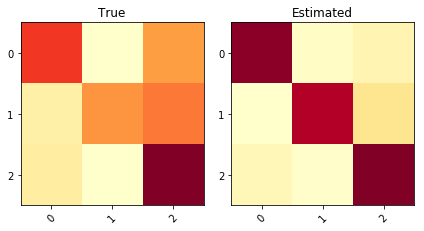

KL divergence: 0.3454	Pearson Correlation between diagonals: 0.9175
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.894587      0.894587   0.496286  0.0982524            0.414514        0.202896
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.604551                0.805568
====  =======================  ======================
Test


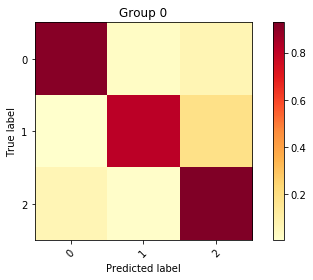

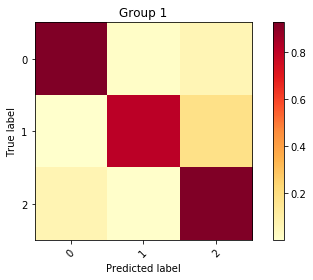

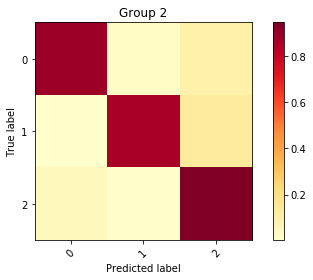

Inertia: 0.0014292192354332656
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.232797    2327   0.376441     0.884773   0.124123       0.939274   0.55144     0.661783      0.661783
   1         1  0.422576    4225   0.359635     0.888274   0.120322       0.941131   0.554941    0.663004      0.663004
   2         2  0.344627    3446   0.341041     0.901951   0.103854       0.948927   0.568618    0.717949      0.717949
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =====

In [134]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


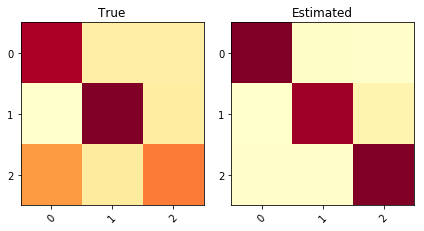

KL divergence: 0.6136	Pearson Correlation between diagonals: -0.7032


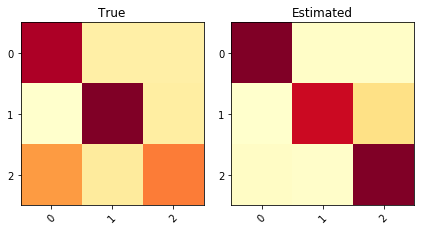

KL divergence: 0.4647	Pearson Correlation between diagonals: -0.6452


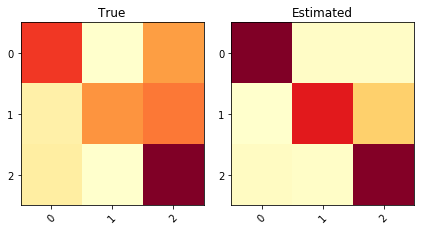

KL divergence: 0.4949	Pearson Correlation between diagonals: 0.7778


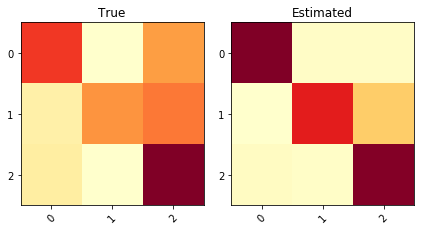

KL divergence: 0.4882	Pearson Correlation between diagonals: 0.7774


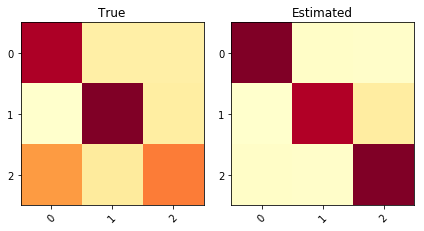

KL divergence: 0.5392	Pearson Correlation between diagonals: -0.6678


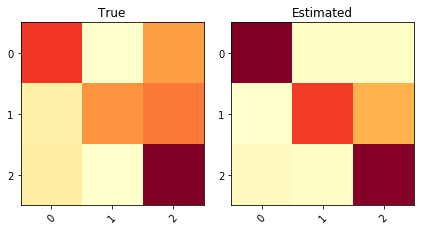

KL divergence: 0.4290	Pearson Correlation between diagonals: 0.7727


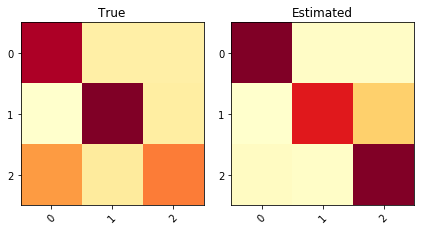

KL divergence: 0.4247	Pearson Correlation between diagonals: -0.6363


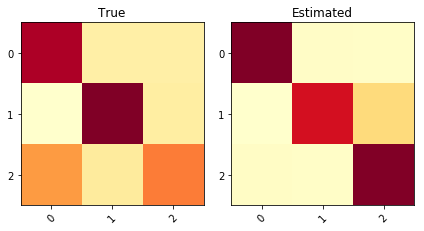

KL divergence: 0.4456	Pearson Correlation between diagonals: -0.6401


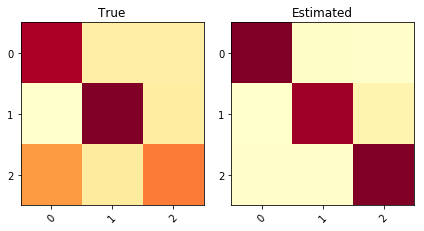

KL divergence: 0.6107	Pearson Correlation between diagonals: -0.7006


KL divergence: 0.4625	Pearson Correlation between diagonals: 0.7753


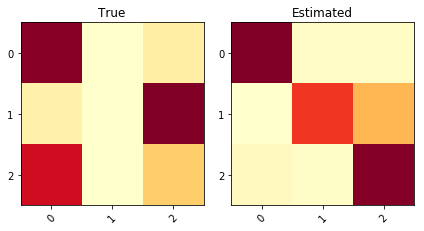

KL divergence: 1.0986	Pearson Correlation between diagonals: 0.7474


KL divergence: 1.2224	Pearson Correlation between diagonals: 0.7432


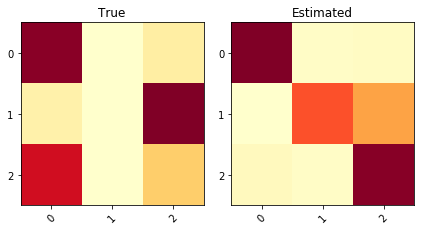

KL divergence: 1.0020	Pearson Correlation between diagonals: 0.7503


KL divergence: 0.4401	Pearson Correlation between diagonals: 0.7736


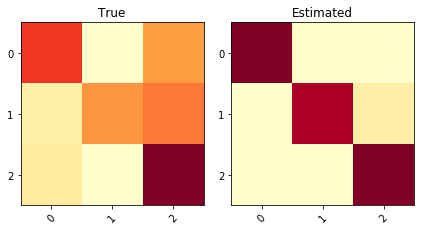

KL divergence: 0.7305	Pearson Correlation between diagonals: 0.8076
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.921449      0.921449   0.626395   0.102156            0.407804        0.153042
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.678316                0.779238
====  =======================  ======================
Test


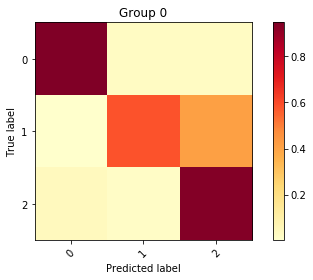

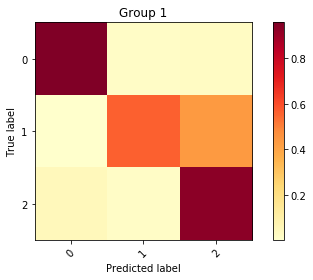

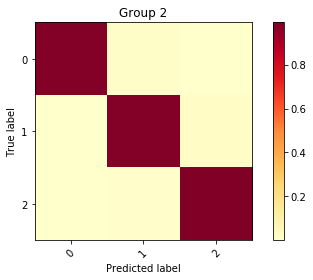

Inertia: 0.03619878049357794
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.216525    2165  0.39855       0.823732  0.218135        0.898138   0.490399    0.650794      0.650794
   1         1  0.391265    3912  0.389417      0.819452  0.227084        0.89457    0.486118    0.649573      0.649573
   2         2  0.39221     3922  0.0796368     0.985652  0.0144597       0.992787   0.652319    0.927961      0.927961
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [135]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 7) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [37]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6295811518324608


In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)